## KD with customized-TinyGPT

- customized-TinyGPT : about 51M parameters, 194MB

In [ ]:
# Check GPU -> It should be A100.

!nvidia-smi

Mon Aug 18 23:29:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Chapter 1
Model Making & Data Preprocessing

In [ ]:
# random seed fixing
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# customized-TinyGPT realization
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Optional, Tuple
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

@dataclass
class TinyGPTConfig:
  # Hyperparameters for TinyGPT
  vocab_size: int = 50257
  n_layers: int = 8 # transformer blocks
  n_head: int = 8 # head_dim
  d_model: int = 512 # hidden_size
  d_ff: int = 2048 # Feed-Forward hidden size
  max_position_embeddings: int = 256 # context length
  dropout = 0.2
  rotary_pct: float = 0.0
  tie_embeddings: bool = True
  device: str = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEmbedding(nn.Module):
  def __init__(self, d_model : int, max_len : int):
    super().__init__()
    pe = torch.zeros(max_len, d_model) # shape : (max_len, d_model)
    positions = torch.arange(0, max_len).unsqueeze(1) # shape : (max_len, 1)
    div_terms = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000) / d_model))
    pe[:,0::2] = torch.sin(positions * div_terms)
    pe[:,1::2] = torch.cos(positions * div_terms)
    self.register_buffer('pe', pe.unsqueeze(0), persistent=False) # (1, max_len, d_model)

  def forward(self, x: torch.Tensor) -> torch.Tensor: # (batch_size, T, C)
    return x + self.pe[:,:x.size(1),:]

class MHSA(nn.Module):
  def __init__(self,config=TinyGPTConfig):
    super().__init__()
    assert config.d_model % config.n_head == 0, "d_model must be divisible by n_head"
    self.d_model = config.d_model
    self.n_head = config.n_head
    self.head_dim = config.d_model // config.n_head
    self.qkv_linear = nn.Linear(config.d_model, 3 * config.d_model)
    self.linear = nn.Linear(config.d_model, config.d_model)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, x: torch.Tensor, return_attentions: bool, casual_mask:bool = True) -> torch.Tensor: # (batch_size, T, C)
    batch_size, T, C = x.shape # C == self.d_model
    qkv = self.qkv_linear(x) # (batch_size, T, 3C)
    q,k,v = qkv.chunk(3, dim=-1) # each shape : (batch_size, T, C)

    # reshape for multi-head. shape : (batch_size, n_head, T, head_dim)
    q = q.view(batch_size, T, self.n_head, self.head_dim).transpose(1,2)
    k = k.view(batch_size, T, self.n_head, self.head_dim).transpose(1,2)
    v = v.view(batch_size, T, self.n_head, self.head_dim).transpose(1,2)

    attn = torch.matmul(q, k.transpose(-1,-2)) / math.sqrt(self.head_dim) # (batch_size, n_head, T, T)
    if casual_mask:
      mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1) # up-triangle
      attn = attn.masked_fill(mask, float('-1e9')) # 1 -> -1e9
    attn = F.softmax(attn, dim=-1)
    attn = self.dropout(attn)

    attn_res = torch.matmul(attn, v) # shape : (batch_size, n_head, T, head_dim)
    attn_res = attn_res.transpose(1,2).contiguous().view(batch_size, T, C) # shape : (batch_size, T, C)
    attn_res = self.linear(attn_res)
    if return_attentions:
      return attn_res, attn
    else:
      return attn_res

class FFNN(nn.Module):
  def __init__(self, config=TinyGPTConfig):
    super().__init__()
    self.FFNN_net = nn.Sequential(
        nn.Linear(config.d_model, config.d_ff),
        nn.GELU(),
        nn.Linear(config.d_ff, config.d_model),
        nn.Dropout(config.dropout)
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor: # (batch_size, T, C)
    ffnn_res = self.FFNN_net(x)
    return ffnn_res

class TinyGPTBlock(nn.Module):
  def __init__(self, config=TinyGPTConfig):
    super().__init__()
    self.ln1 = nn.LayerNorm(config.d_model)
    self.attn = MHSA(config)
    self.ln2 = nn.LayerNorm(config.d_model)
    self.ff = FFNN(config)

  def forward(self, x:torch.Tensor, return_attentions: bool, casual_mask:bool = True) -> torch.Tensor:
    if return_attentions == True:
      attn_w, org_attn = self.attn(self.ln1(x), return_attentions, casual_mask=casual_mask)
      x = x + attn_w
      x = x + self.ff(self.ln2(x))
      return x, org_attn
    else:
      x = x + self.attn(self.ln1(x), return_attentions, casual_mask=casual_mask)
      x = x + self.ff(self.ln2(x))
      return x

class TinyGPT(nn.Module):
  def __init__(self, config: TinyGPTConfig):
    super().__init__()
    self.config = config

    self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
    self.pos_emb = PositionalEmbedding(config.d_model, config.max_position_embeddings)
    self.drop = nn.Dropout(config.dropout)

    self.blocks = nn.ModuleList([TinyGPTBlock(config) for _ in range(config.n_layers)])
    self.ln_f = nn.LayerNorm(config.d_model)
    self.Linear_f = nn.Linear(config.d_model, config.vocab_size, bias=False)

    if config.tie_embeddings:
      self.Linear_f.weight = self.token_emb.weight # weight tying

    self.apply(self._init_weights)
    self.to(config.device)

  @staticmethod # can use directly without calling out
  def _init_weights(module):
    if isinstance(module, nn.Linear): # initialization mathod in linear
      nn.init.normal_(module.weight, mean=0.0, std=0.02) # it is usually used in GPT-type models
      if module.bias is not None: # if bias exist,
        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
      nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self,
              input_ids: torch.Tensor,
              return_attentions: bool,
              labels: Optional[torch.Tensor]=None) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
    B, T = input_ids.shape
    if T > self.config.max_position_embeddings: # if seq_len > max_position_embeddings
      raise ValueError(f'Sequence length {T} must not be larger than limit : {self.config.max_position_embeddings}')

    x = self.token_emb(input_ids) # (B, T, C)
    x = self.pos_emb(x)
    x = self.drop(x)
    if return_attentions == True:
      all_attns = [] # list to save all attn
      for block in self.blocks:
        x, org_attn = block(x, return_attentions=True, casual_mask=True)
        all_attns.append(org_attn)
      x = self.ln_f(x)
      logits = self.Linear_f(x) # (B, T, vocab_size)

      return logits, all_attns
    else:
      for block in self.blocks:
        x = block(x, return_attentions=False, casual_mask=True)

      x = self.ln_f(x)
      logits = self.Linear_f(x) # (B, T, vocab_size)

      return logits


In [ ]:
# For using Dataset from huggingface
pip install -U datasets huggingface_hub fsspec

In [ ]:
# call WikiText-103
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-103-raw-v1")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [ ]:
from itertools import chain
import re
from transformers import GPT2TokenizerFast

# GPT2 Tokenizer setting
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
print(f'vocab_size should be {len(tokenizer)}')

# GPT2 doesn't have padding token -> replace it with EOS token
tokenizer.pad_token = tokenizer.eos_token

# preprocess function
def preprocess(sentence):
  # blank without alphabet, numbers and some special letters
  sent = re.sub('[^a-zA-Z0-9\'\".,!? ]+', ' ', sentence.strip())
  sent = re.sub('\s+', ' ', sent)  # multiple blank -> single blank
  return sent

# text tokenizeing
def tokenizing(example):
  # After preprocessing, combine to one str
  text = " ".join([preprocess(t) for t in example['text']])
  # tokeizer includes <eos> token processing
  return tokenizer(text, return_attention_mask=False, truncation=True, padding=False)

# Applying tokenizer to all datasets
tokenized_dataset = dataset.map(
    tokenizing,
    batched=True,
    remove_columns=["text"]  # Delete the original text column
)

# Function to split text into blocks for GPT training
block_size = 128  # hyper-parameters

def group_texts(examples):
  # Check if input_ids is list in the list
  input_ids = examples["input_ids"]

  # Make a long token sequences
  if isinstance(input_ids[0], list):  # if several sentences(batch)
    joined = list(chain(*input_ids))
  else:  # one sentence (not batch)
    joined = input_ids

  total_len = (len(joined) // block_size) * block_size
  joined = joined[:total_len]

  # Making blocks to input datasets to models
  input_blocks = [joined[i:i+block_size] for i in range(0, total_len, block_size)]

  return {
      "input_ids": input_blocks,
      "labels": [
          [-100 if token == tokenizer.pad_token_id else token for token in block]
          for block in input_blocks
          ]
    }

# Datset making
lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True
)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-791519425.py:16: SyntaxWarning: invalid escape sequence '\s'
  sent = re.sub('\s+', ' ', sent)  # 다중 공백을 단일 공백으로


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab_size should be 50257


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/5120 [00:00<?, ? examples/s]

Map:   0%|          | 0/1845248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4096 [00:00<?, ? examples/s]

In [ ]:
# Check dataset
print(f'lm_dataset : {lm_dataset}')
print(dataset['train']['text'][:5])
print([preprocess(sent) for sent in dataset['train']['text'][:5]])

print(lm_dataset['train']['input_ids'][:5])
print(lm_dataset['train']['labels'][0])
print(len(lm_dataset['train']['input_ids'][1])) # each length of train
print()

print(dataset['validation']['text'][:5])
print([preprocess(sent) for sent in dataset['validation']['text'][:5]])

print(lm_dataset['validation']['input_ids'][:5])
print(lm_dataset['validation']['labels'][0])
print(len(lm_dataset['validation']['input_ids'][1])) # each length of validation
print()

print(dataset['test']['text'][:5])
print([preprocess(sent) for sent in dataset['test']['text'][:5]])

print(lm_dataset['test']['input_ids'][:5])
print(lm_dataset['test']['labels'][0])
print(len(lm_dataset['test']['input_ids'][1])) # each length of test

lm_dataset : DatasetDict({
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 35
    })
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12916
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 28
    })
})
['', ' = Valkyria Chronicles III = \n', '', ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations

In [ ]:
'''
Make datasets to dataloaders
1. raw datasets -> tensor
2. tensor -> TensorDataset
3  TensorDataset -> DataLoader
'''
batch_size = 64 # Hyper-parameters. if OOM occured, batch_size should be 32, else 64

import torch
from torch.utils.data import TensorDataset, DataLoader

train_input_tensor = torch.tensor(lm_dataset['train']['input_ids'], dtype=torch.long)
train_label_tensor = torch.tensor(lm_dataset['train']['labels'], dtype=torch.long)

valid_input_tensor = torch.tensor(lm_dataset['validation']['input_ids'], dtype=torch.long)
valid_label_tensor = torch.tensor(lm_dataset['validation']['labels'], dtype=torch.long)

test_input_tensor = torch.tensor(lm_dataset['test']['input_ids'], dtype=torch.long)
test_label_tensor = torch.tensor(lm_dataset['test']['labels'], dtype=torch.long)

# Setting datasets and dataloaders
train_dataset = TensorDataset(train_input_tensor, train_label_tensor)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(valid_input_tensor, valid_label_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
print(len(train_dataset))

12916


## Chapter 2

No KD

PPL : 367.0832

Best Epoch : 21

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model = TinyGPT(TinyGPTConfig)
print(TinyGPTConfig.device) # Check device is GPU or CPU
print(model)

cuda
TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)


In [ ]:
print(len(train_dataloader))

202


In [ ]:
num_epochs = 50

In [ ]:
import torch
import math

loss_function = nn.CrossEntropyLoss(ignore_index=-100)
# betas:
# 1. weight for the moving average of gradients
# 2. weight for the moving average of squared gradients
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  '''
  For my experiments, scheduler was customized
  warmup steps = 100
  total steps = 10000
  '''
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(model, dataloader, loss_function, return_attentions, device):
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100  # Last token should be ignored

      outputs = model(input_ids, return_attentions=return_attentions)
      loss = loss_function(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
      ce_loss = F.cross_entropy(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  # return loss, acc, and ppl
  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
'''
Model training
'''
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  model.train()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100  # Last token should be ignored
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    outputs = model(input_ids, return_attentions=False)

    loss = loss_function(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    '''
    In GPT type models, clip_grad_norm_ is used to avoid gradient divergence
    Upper boundary is 1.0.
    If gradient is over than upper boundary, scaling is applied.
    '''

    scheduler.step()

  train_loss, train_acc, train_ppl = evaluation(model, train_dataloader, loss_function, False, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(model, valid_dataloader, loss_function, False, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  '''
  If valid loss and valid perplexity both don't reduce for six peochs,
  early-stopping is applied.
  '''
  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the Checkpoint')
    best_val_loss = valid_loss
    best_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_TinyGPT_checkpoint.pth')
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  else:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_epoch : {best_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 7.5475 | Train_Accuracy : 0.0509 | Train Perplexity : 1895.9428
Valid Loss : 7.5213 | Valid_Accuracy : 0.0402 | Valid Perplexity : 1846.9351
Valid Loss improved from inf to 7.5213
Save the Checkpoint


  2%|▏         | 1/50 [01:11<58:08, 71.20s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 7.4909 | Train_Accuracy : 0.0731 | Train Perplexity : 1791.5800
Valid Loss : 7.5006 | Valid_Accuracy : 0.0694 | Valid Perplexity : 1809.1408
Valid Loss improved from 7.5213 to 7.5006
Save the Checkpoint


  4%|▍         | 2/50 [02:07<49:44, 62.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 7.2116 | Train_Accuracy : 0.0924 | Train Perplexity : 1355.1553
Valid Loss : 7.2646 | Valid_Accuracy : 0.0836 | Valid Perplexity : 1428.8737
Valid Loss improved from 7.5006 to 7.2646
Save the Checkpoint


  6%|▌         | 3/50 [03:02<46:28, 59.32s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 6.8625 | Train_Accuracy : 0.1181 | Train Perplexity : 955.7839
Valid Loss : 6.9475 | Valid_Accuracy : 0.1097 | Valid Perplexity : 1040.5593
Valid Loss improved from 7.2646 to 6.9475
Save the Checkpoint


  8%|▊         | 4/50 [03:59<44:29, 58.03s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 6.7888 | Train_Accuracy : 0.1184 | Train Perplexity : 887.7756
Valid Loss : 6.8875 | Valid_Accuracy : 0.1117 | Valid Perplexity : 979.9760
Valid Loss improved from 6.9475 to 6.8875
Save the Checkpoint


 10%|█         | 5/50 [04:54<42:57, 57.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 6.5889 | Train_Accuracy : 0.1301 | Train Perplexity : 726.9883
Valid Loss : 6.7323 | Valid_Accuracy : 0.1207 | Valid Perplexity : 839.0429
Valid Loss improved from 6.8875 to 6.7323
Save the Checkpoint


 12%|█▏        | 6/50 [05:50<41:39, 56.82s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 6.4328 | Train_Accuracy : 0.1380 | Train Perplexity : 621.9152
Valid Loss : 6.5994 | Valid_Accuracy : 0.1239 | Valid Perplexity : 734.6417
Valid Loss improved from 6.7323 to 6.5994
Save the Checkpoint


 14%|█▍        | 7/50 [06:46<40:31, 56.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 6.2593 | Train_Accuracy : 0.1461 | Train Perplexity : 522.8465
Valid Loss : 6.4769 | Valid_Accuracy : 0.1312 | Valid Perplexity : 649.9261
Valid Loss improved from 6.5994 to 6.4769
Save the Checkpoint


 16%|█▌        | 8/50 [07:42<39:26, 56.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 6.0755 | Train_Accuracy : 0.1547 | Train Perplexity : 435.0677
Valid Loss : 6.3107 | Valid_Accuracy : 0.1474 | Valid Perplexity : 550.4330
Valid Loss improved from 6.4769 to 6.3107
Save the Checkpoint


 18%|█▊        | 9/50 [08:38<38:25, 56.24s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 5.9975 | Train_Accuracy : 0.1583 | Train Perplexity : 402.3921
Valid Loss : 6.2812 | Valid_Accuracy : 0.1482 | Valid Perplexity : 534.4170
Valid Loss improved from 6.3107 to 6.2812
Save the Checkpoint


 20%|██        | 10/50 [09:34<37:26, 56.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 5.8241 | Train_Accuracy : 0.1656 | Train Perplexity : 338.3362
Valid Loss : 6.1682 | Valid_Accuracy : 0.1539 | Valid Perplexity : 477.3394
Valid Loss improved from 6.2812 to 6.1682
Save the Checkpoint


 22%|██▏       | 11/50 [10:30<36:28, 56.11s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth


 24%|██▍       | 12/50 [11:26<35:24, 55.91s/it]

Epoch : 12 / 50
Train Loss : 5.7450 | Train_Accuracy : 0.1697 | Train Perplexity : 312.6181
Valid Loss : 6.1703 | Valid_Accuracy : 0.1542 | Valid Perplexity : 478.3222
Epoch : 13 / 50
Train Loss : 5.6323 | Train_Accuracy : 0.1725 | Train Perplexity : 279.3138
Valid Loss : 6.1253 | Valid_Accuracy : 0.1565 | Valid Perplexity : 457.3042
Valid Loss improved from 6.1682 to 6.1253
Save the Checkpoint


 26%|██▌       | 13/50 [12:22<34:28, 55.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 5.5117 | Train_Accuracy : 0.1779 | Train Perplexity : 247.5526
Valid Loss : 6.0739 | Valid_Accuracy : 0.1650 | Valid Perplexity : 434.3887
Valid Loss improved from 6.1253 to 6.0739
Save the Checkpoint


 28%|██▊       | 14/50 [13:18<33:33, 55.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 5.3827 | Train_Accuracy : 0.1838 | Train Perplexity : 217.6372
Valid Loss : 6.0377 | Valid_Accuracy : 0.1664 | Valid Perplexity : 418.9305
Valid Loss improved from 6.0739 to 6.0377
Save the Checkpoint


 30%|███       | 15/50 [14:14<32:37, 55.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 5.3394 | Train_Accuracy : 0.1871 | Train Perplexity : 208.3932
Valid Loss : 6.0315 | Valid_Accuracy : 0.1689 | Valid Perplexity : 416.3426
Valid Loss improved from 6.0377 to 6.0315
Save the Checkpoint


 32%|███▏      | 16/50 [15:09<31:41, 55.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 5.1842 | Train_Accuracy : 0.1935 | Train Perplexity : 178.4277
Valid Loss : 5.9809 | Valid_Accuracy : 0.1721 | Valid Perplexity : 395.8133
Valid Loss improved from 6.0315 to 5.9809
Save the Checkpoint


 34%|███▍      | 17/50 [16:05<30:45, 55.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 5.0416 | Train_Accuracy : 0.2013 | Train Perplexity : 154.7438
Valid Loss : 5.9325 | Valid_Accuracy : 0.1763 | Valid Perplexity : 377.0810
Valid Loss improved from 5.9809 to 5.9325
Save the Checkpoint


 36%|███▌      | 18/50 [17:01<29:49, 55.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 4.9282 | Train_Accuracy : 0.2055 | Train Perplexity : 138.1243
Valid Loss : 5.9312 | Valid_Accuracy : 0.1808 | Valid Perplexity : 376.5928
Valid Loss improved from 5.9325 to 5.9312
Save the Checkpoint


 38%|███▊      | 19/50 [17:57<28:53, 55.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 4.8709 | Train_Accuracy : 0.2098 | Train Perplexity : 130.4348
Valid Loss : 5.9301 | Valid_Accuracy : 0.1817 | Valid Perplexity : 376.1736
Valid Loss improved from 5.9312 to 5.9301
Save the Checkpoint


 40%|████      | 20/50 [18:53<27:58, 55.94s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.7217 | Train_Accuracy : 0.2180 | Train Perplexity : 112.3518
Valid Loss : 5.9056 | Valid_Accuracy : 0.1837 | Valid Perplexity : 367.0832
Valid Loss improved from 5.9301 to 5.9056
Save the Checkpoint


 42%|████▏     | 21/50 [19:49<27:02, 55.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_TinyGPT_checkpoint.pth


 44%|████▍     | 22/50 [20:45<26:01, 55.76s/it]

Epoch : 22 / 50
Train Loss : 4.6452 | Train_Accuracy : 0.2230 | Train Perplexity : 104.0874
Valid Loss : 5.9080 | Valid_Accuracy : 0.1842 | Valid Perplexity : 367.9825


 46%|████▌     | 23/50 [21:40<25:03, 55.68s/it]

Epoch : 23 / 50
Train Loss : 4.5625 | Train_Accuracy : 0.2271 | Train Perplexity : 95.8311
Valid Loss : 5.9108 | Valid_Accuracy : 0.1828 | Valid Perplexity : 368.9868


 48%|████▊     | 24/50 [22:35<24:05, 55.59s/it]

Epoch : 24 / 50
Train Loss : 4.4967 | Train_Accuracy : 0.2320 | Train Perplexity : 89.7276
Valid Loss : 5.9560 | Valid_Accuracy : 0.1800 | Valid Perplexity : 386.0777


 50%|█████     | 25/50 [23:31<23:08, 55.54s/it]

Epoch : 25 / 50
Train Loss : 4.4115 | Train_Accuracy : 0.2378 | Train Perplexity : 82.3883
Valid Loss : 5.9623 | Valid_Accuracy : 0.1820 | Valid Perplexity : 388.5007


 52%|█████▏    | 26/50 [24:26<22:12, 55.53s/it]

Epoch : 26 / 50
Train Loss : 4.2855 | Train_Accuracy : 0.2480 | Train Perplexity : 72.6310
Valid Loss : 5.9256 | Valid_Accuracy : 0.1831 | Valid Perplexity : 374.5141


 52%|█████▏    | 26/50 [25:22<23:25, 58.55s/it]

Epoch : 27 / 50
Train Loss : 4.1934 | Train_Accuracy : 0.2559 | Train Perplexity : 66.2398
Valid Loss : 5.9320 | Valid_Accuracy : 0.1834 | Valid Perplexity : 376.8965
best_epoch : 21


## Chapter 3
KL - logits

PPL : 197.1689

Best Epoch : 50

In [ ]:
# Loss Function
def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()

    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(
        student_logits.view(-1, student_logits.size(-1)),
        labels.view(-1),
        ignore_index=self.ignore_index,
        label_smoothing=self.label_smoothing
    )

    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Load model and tokenizer
model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=False)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model): # Functions for counting omdel's parameters
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)
# Student model has about 42% parameters of teacher models
print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100  # Last token should be ignored

      s_outputs = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids).logits
      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_outputs.reshape(-1, t_outputs.size(-1))) # 이건 나중에 shape 확인해봐야 할 듯.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  # return loss, acc, and ppl
  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
num_epochs = 50

import torch
import math

loss_function = TotalLoss(temperature=2.0, alpha=0.5)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  '''
  For my experiments, scheduler was customized
  warmup steps = 100
  total steps = 10000
  '''
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Training
'''
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_loss_epoch = 0
best_valid_epoch = 0
cnt_to_stop = 0
best_ppl = float('inf')

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100  # Last token should be ignored
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs = student_model(input_ids, return_attentions=False)
    t_outputs = teacher_model(input_ids).logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_outputs.reshape(-1, t_outputs.size(-1)))
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, False, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, False, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2442 | Train_Accuracy : 0.0501 | Train Perplexity : 2063.3424
Valid Loss : 6.2477 | Valid_Accuracy : 0.0428 | Valid Perplexity : 1926.4015
Valid Loss improved from inf to 6.2477
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1926.4015
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:44<3:03:29, 224.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2373 | Train_Accuracy : 0.0602 | Train Perplexity : 2030.3419
Valid Loss : 6.2466 | Valid_Accuracy : 0.0488 | Valid Perplexity : 1908.4210
Valid Loss improved from 6.2477 to 6.2466
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1926.4015 to 1908.4210
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:01<2:46:45, 208.45s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.8113 | Train_Accuracy : 0.0951 | Train Perplexity : 1307.4162
Valid Loss : 5.8380 | Valid_Accuracy : 0.0873 | Valid Perplexity : 1270.0845
Valid Loss improved from 6.2466 to 5.8380
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1908.4210 to 1270.0845
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:18<2:39:13, 203.27s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.6757 | Train_Accuracy : 0.1045 | Train Perplexity : 1148.3576
Valid Loss : 5.7227 | Valid_Accuracy : 0.0972 | Valid Perplexity : 1139.3703
Valid Loss improved from 5.8380 to 5.7227
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1270.0845 to 1139.3703
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [13:36<2:33:59, 200.87s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.5983 | Train_Accuracy : 0.1072 | Train Perplexity : 1086.0774
Valid Loss : 5.6495 | Valid_Accuracy : 0.0967 | Valid Perplexity : 1092.7038
Valid Loss improved from 5.7227 to 5.6495
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1139.3703 to 1092.7038
Save the Perplexity Checkpoint


 10%|█         | 5/50 [16:53<2:29:39, 199.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.2911 | Train_Accuracy : 0.1234 | Train Perplexity : 762.9445
Valid Loss : 5.3271 | Valid_Accuracy : 0.1128 | Valid Perplexity : 764.6118
Valid Loss improved from 5.6495 to 5.3271
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1092.7038 to 764.6118
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [20:10<2:25:39, 198.63s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.1727 | Train_Accuracy : 0.1319 | Train Perplexity : 652.5269
Valid Loss : 5.2224 | Valid_Accuracy : 0.1156 | Valid Perplexity : 675.0579
Valid Loss improved from 5.3271 to 5.2224
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 764.6118 to 675.0579
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [23:27<2:21:59, 198.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0386 | Train_Accuracy : 0.1369 | Train Perplexity : 562.7912
Valid Loss : 5.1043 | Valid_Accuracy : 0.1222 | Valid Perplexity : 597.8781
Valid Loss improved from 5.2224 to 5.1043
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 675.0579 to 597.8781
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [26:44<2:18:27, 197.80s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9628 | Train_Accuracy : 0.1413 | Train Perplexity : 508.2776
Valid Loss : 5.0046 | Valid_Accuracy : 0.1259 | Valid Perplexity : 530.9361
Valid Loss improved from 5.1043 to 5.0046
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 597.8781 to 530.9361
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [30:01<2:15:05, 197.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.9147 | Train_Accuracy : 0.1428 | Train Perplexity : 478.7672
Valid Loss : 4.9704 | Valid_Accuracy : 0.1307 | Valid Perplexity : 509.9682
Valid Loss improved from 5.0046 to 4.9704
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 530.9361 to 509.9682
Save the Perplexity Checkpoint


 20%|██        | 10/50 [33:18<2:11:39, 197.48s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.7895 | Train_Accuracy : 0.1545 | Train Perplexity : 408.7457
Valid Loss : 4.8613 | Valid_Accuracy : 0.1468 | Valid Perplexity : 446.5117
Valid Loss improved from 4.9704 to 4.8613
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 509.9682 to 446.5117
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [36:35<2:08:16, 197.34s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.7085 | Train_Accuracy : 0.1586 | Train Perplexity : 371.9416
Valid Loss : 4.8157 | Valid_Accuracy : 0.1494 | Valid Perplexity : 427.2878
Valid Loss improved from 4.8613 to 4.8157
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 446.5117 to 427.2878
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [39:52<2:04:53, 197.20s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 4.6334 | Train_Accuracy : 0.1639 | Train Perplexity : 336.6635
Valid Loss : 4.7510 | Valid_Accuracy : 0.1590 | Valid Perplexity : 395.0213
Valid Loss improved from 4.8157 to 4.7510
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 427.2878 to 395.0213
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [43:10<2:01:41, 197.35s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 4.5419 | Train_Accuracy : 0.1682 | Train Perplexity : 302.3479
Valid Loss : 4.6994 | Valid_Accuracy : 0.1553 | Valid Perplexity : 376.4525
Valid Loss improved from 4.7510 to 4.6994
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 395.0213 to 376.4525
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [46:27<1:58:22, 197.29s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 4.5062 | Train_Accuracy : 0.1730 | Train Perplexity : 284.3926
Valid Loss : 4.6775 | Valid_Accuracy : 0.1576 | Valid Perplexity : 361.0871
Valid Loss improved from 4.6994 to 4.6775
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 376.4525 to 361.0871
Save the Perplexity Checkpoint


 30%|███       | 15/50 [49:44<1:55:04, 197.27s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4578 | Train_Accuracy : 0.1768 | Train Perplexity : 266.7207
Valid Loss : 4.6287 | Valid_Accuracy : 0.1630 | Valid Perplexity : 341.5499
Valid Loss improved from 4.6775 to 4.6287
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 361.0871 to 341.5499
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [53:01<1:51:44, 197.20s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 4.3501 | Train_Accuracy : 0.1820 | Train Perplexity : 234.1337
Valid Loss : 4.5600 | Valid_Accuracy : 0.1670 | Valid Perplexity : 315.6868
Valid Loss improved from 4.6287 to 4.5600
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 341.5499 to 315.6868
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [56:18<1:48:26, 197.17s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 4.3187 | Train_Accuracy : 0.1852 | Train Perplexity : 222.5420
Valid Loss : 4.5405 | Valid_Accuracy : 0.1721 | Valid Perplexity : 307.3681
Valid Loss improved from 4.5600 to 4.5405
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 315.6868 to 307.3681
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [59:36<1:45:09, 197.17s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [1:02:51<1:41:38, 196.72s/it]

Epoch : 19 / 50
Train Loss : 4.2894 | Train_Accuracy : 0.1870 | Train Perplexity : 212.9915
Valid Loss : 4.5449 | Valid_Accuracy : 0.1712 | Valid Perplexity : 310.7553
Epoch : 20 / 50
Train Loss : 4.2319 | Train_Accuracy : 0.1915 | Train Perplexity : 196.8945
Valid Loss : 4.4971 | Valid_Accuracy : 0.1797 | Valid Perplexity : 292.0945
Valid Loss improved from 4.5405 to 4.4971
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 307.3681 to 292.0945
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:06:08<1:38:22, 196.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.1549 | Train_Accuracy : 0.1984 | Train Perplexity : 177.4406
Valid Loss : 4.4482 | Valid_Accuracy : 0.1842 | Valid Perplexity : 275.6696
Valid Loss improved from 4.4971 to 4.4482
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 292.0945 to 275.6696
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:09:25<1:35:10, 196.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 44%|████▍     | 22/50 [1:12:41<1:31:46, 196.66s/it]

Epoch : 22 / 50
Train Loss : 4.1391 | Train_Accuracy : 0.2001 | Train Perplexity : 171.4342
Valid Loss : 4.4491 | Valid_Accuracy : 0.1780 | Valid Perplexity : 275.8296


 46%|████▌     | 23/50 [1:15:57<1:28:21, 196.36s/it]

Epoch : 23 / 50
Train Loss : 4.0966 | Train_Accuracy : 0.2027 | Train Perplexity : 161.9411
Valid Loss : 4.4509 | Valid_Accuracy : 0.1811 | Valid Perplexity : 275.9520
Epoch : 24 / 50
Train Loss : 4.0185 | Train_Accuracy : 0.2104 | Train Perplexity : 145.4919
Valid Loss : 4.3760 | Valid_Accuracy : 0.1913 | Valid Perplexity : 252.6243
Valid Loss improved from 4.4482 to 4.3760
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 275.6696 to 252.6243
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:19:14<1:25:10, 196.56s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 50%|█████     | 25/50 [1:22:30<1:21:48, 196.35s/it]

Epoch : 25 / 50
Train Loss : 4.0356 | Train_Accuracy : 0.2083 | Train Perplexity : 147.8098
Valid Loss : 4.4395 | Valid_Accuracy : 0.1828 | Valid Perplexity : 272.6068
Epoch : 26 / 50
Train Loss : 3.9318 | Train_Accuracy : 0.2191 | Train Perplexity : 128.3525
Valid Loss : 4.3317 | Valid_Accuracy : 0.1947 | Valid Perplexity : 241.6565
Valid Loss improved from 4.3760 to 4.3317
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 252.6243 to 241.6565
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:25:47<1:18:37, 196.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:29:03<1:15:17, 196.41s/it]

Epoch : 27 / 50
Train Loss : 3.9338 | Train_Accuracy : 0.2200 | Train Perplexity : 126.8443
Valid Loss : 4.3476 | Valid_Accuracy : 0.1976 | Valid Perplexity : 245.4407
Epoch : 28 / 50
Train Loss : 3.8930 | Train_Accuracy : 0.2238 | Train Perplexity : 120.0645
Valid Loss : 4.3271 | Valid_Accuracy : 0.1930 | Valid Perplexity : 240.4312
Valid Loss improved from 4.3317 to 4.3271
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 241.6565 to 240.4312
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:32:21<1:12:09, 196.80s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:35:37<1:08:46, 196.49s/it]

Epoch : 29 / 50
Train Loss : 3.8721 | Train_Accuracy : 0.2273 | Train Perplexity : 115.5975
Valid Loss : 4.3357 | Valid_Accuracy : 0.1944 | Valid Perplexity : 240.8302
Epoch : 30 / 50
Train Loss : 3.7985 | Train_Accuracy : 0.2347 | Train Perplexity : 104.6445
Valid Loss : 4.2869 | Valid_Accuracy : 0.1916 | Valid Perplexity : 229.7992
Valid Loss improved from 4.3271 to 4.2869
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 240.4312 to 229.7992
Save the Perplexity Checkpoint


 60%|██████    | 30/50 [1:38:53<1:05:31, 196.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 31 / 50
Train Loss : 3.7943 | Train_Accuracy : 0.2358 | Train Perplexity : 102.9419
Valid Loss : 4.2724 | Valid_Accuracy : 0.1973 | Valid Perplexity : 223.8889
Valid Loss improved from 4.2869 to 4.2724
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 229.7992 to 223.8889
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:42:10<1:02:17, 196.72s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 32 / 50
Train Loss : 3.7528 | Train_Accuracy : 0.2411 | Train Perplexity : 97.1360
Valid Loss : 4.2576 | Valid_Accuracy : 0.1998 | Valid Perplexity : 220.3744
Valid Loss improved from 4.2724 to 4.2576
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 223.8889 to 220.3744
Save the Perplexity Checkpoint


 64%|██████▍   | 32/50 [1:45:27<59:01, 196.73s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 66%|██████▌   | 33/50 [1:48:43<55:40, 196.50s/it]

Epoch : 33 / 50
Train Loss : 3.7279 | Train_Accuracy : 0.2441 | Train Perplexity : 93.4969
Valid Loss : 4.2617 | Valid_Accuracy : 0.1976 | Valid Perplexity : 221.4886
Epoch : 34 / 50
Train Loss : 3.7100 | Train_Accuracy : 0.2469 | Train Perplexity : 90.7627
Valid Loss : 4.2356 | Valid_Accuracy : 0.2021 | Valid Perplexity : 214.8608
Valid Loss improved from 4.2576 to 4.2356
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 220.3744 to 214.8608
Save the Perplexity Checkpoint


 68%|██████▊   | 34/50 [1:52:00<52:26, 196.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 35 / 50
Train Loss : 3.6765 | Train_Accuracy : 0.2511 | Train Perplexity : 86.6065
Valid Loss : 4.2349 | Valid_Accuracy : 0.1987 | Valid Perplexity : 214.6524
Valid Loss improved from 4.2356 to 4.2349
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 214.8608 to 214.6524
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [1:55:18<49:14, 197.00s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.6671 | Train_Accuracy : 0.2530 | Train Perplexity : 84.8984
Valid Loss : 4.2273 | Valid_Accuracy : 0.2027 | Valid Perplexity : 212.1157
Valid Loss improved from 4.2349 to 4.2273
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 214.6524 to 212.1157
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [1:58:35<45:59, 197.08s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6453 | Train_Accuracy : 0.2556 | Train Perplexity : 82.2292
Valid Loss : 4.2155 | Valid_Accuracy : 0.2018 | Valid Perplexity : 209.7125
Valid Loss improved from 4.2273 to 4.2155
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 212.1157 to 209.7125
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [2:01:52<42:42, 197.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6182 | Train_Accuracy : 0.2592 | Train Perplexity : 79.1338
Valid Loss : 4.1992 | Valid_Accuracy : 0.2049 | Valid Perplexity : 205.6901
Valid Loss improved from 4.2155 to 4.1992
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.7125 to 205.6901
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:05:10<39:25, 197.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 78%|███████▊  | 39/50 [2:08:25<36:03, 196.72s/it]

Epoch : 39 / 50
Train Loss : 3.6162 | Train_Accuracy : 0.2598 | Train Perplexity : 78.6800
Valid Loss : 4.2123 | Valid_Accuracy : 0.2069 | Valid Perplexity : 208.6089
Epoch : 40 / 50
Train Loss : 3.5956 | Train_Accuracy : 0.2626 | Train Perplexity : 76.2630
Valid Loss : 4.1911 | Valid_Accuracy : 0.2089 | Valid Perplexity : 203.2323
Valid Loss improved from 4.1992 to 4.1911
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 205.6901 to 203.2323
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:11:42<32:47, 196.80s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.5864 | Train_Accuracy : 0.2640 | Train Perplexity : 75.1793
Valid Loss : 4.1895 | Valid_Accuracy : 0.2095 | Valid Perplexity : 203.0633
Valid Loss improved from 4.1911 to 4.1895
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.2323 to 203.0633
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:14:59<29:32, 196.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 42 / 50
Train Loss : 3.5790 | Train_Accuracy : 0.2653 | Train Perplexity : 74.1352
Valid Loss : 4.1828 | Valid_Accuracy : 0.2083 | Valid Perplexity : 201.2229
Valid Loss improved from 4.1895 to 4.1828
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.0633 to 201.2229
Save the Perplexity Checkpoint


 84%|████████▍ | 42/50 [2:18:17<26:15, 196.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 86%|████████▌ | 43/50 [2:21:32<22:56, 196.62s/it]

Epoch : 43 / 50
Train Loss : 3.5806 | Train_Accuracy : 0.2657 | Train Perplexity : 74.0266
Valid Loss : 4.1904 | Valid_Accuracy : 0.2058 | Valid Perplexity : 203.1634
Epoch : 44 / 50
Train Loss : 3.5642 | Train_Accuracy : 0.2678 | Train Perplexity : 72.3286
Valid Loss : 4.1721 | Valid_Accuracy : 0.2038 | Valid Perplexity : 198.5810
Valid Loss improved from 4.1828 to 4.1721
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 201.2229 to 198.5810
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:24:50<19:40, 196.77s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth


 90%|█████████ | 45/50 [2:28:05<16:22, 196.50s/it]

Epoch : 45 / 50
Train Loss : 3.5624 | Train_Accuracy : 0.2679 | Train Perplexity : 71.9185
Valid Loss : 4.1797 | Valid_Accuracy : 0.2072 | Valid Perplexity : 200.8778


 92%|█████████▏| 46/50 [2:31:21<13:05, 196.29s/it]

Epoch : 46 / 50
Train Loss : 3.5519 | Train_Accuracy : 0.2694 | Train Perplexity : 70.8803
Valid Loss : 4.1746 | Valid_Accuracy : 0.2072 | Valid Perplexity : 199.7862


 94%|█████████▍| 47/50 [2:34:37<09:48, 196.24s/it]

Epoch : 47 / 50
Train Loss : 3.5452 | Train_Accuracy : 0.2705 | Train Perplexity : 70.2037
Valid Loss : 4.1778 | Valid_Accuracy : 0.2080 | Valid Perplexity : 200.5692


 96%|█████████▌| 48/50 [2:37:53<06:32, 196.20s/it]

Epoch : 48 / 50
Train Loss : 3.5401 | Train_Accuracy : 0.2714 | Train Perplexity : 69.3918
Valid Loss : 4.1741 | Valid_Accuracy : 0.2078 | Valid Perplexity : 199.7538
Epoch : 49 / 50
Train Loss : 3.5332 | Train_Accuracy : 0.2722 | Train Perplexity : 68.6715
Valid Loss : 4.1696 | Valid_Accuracy : 0.2069 | Valid Perplexity : 198.2910
Valid Loss improved from 4.1721 to 4.1696
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 198.5810 to 198.2910
Save the Perplexity Checkpoint


 98%|█████████▊| 49/50 [2:41:10<03:16, 196.40s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
Epoch : 50 / 50
Train Loss : 3.5242 | Train_Accuracy : 0.2739 | Train Perplexity : 67.7393
Valid Loss : 4.1641 | Valid_Accuracy : 0.2069 | Valid Perplexity : 197.1689
Valid Loss improved from 4.1696 to 4.1641
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_TinyGPT_checkpoint.pth
Valid Perplexity improved from 198.2910 to 197.1689
Save the Perplexity Checkpoint


100%|██████████| 50/50 [2:44:27<00:00, 197.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_TinyGPT_checkpoint.pth
best_loss_epoch : 50
best_ppl_epoch : 50


## Chapter 4
MSE - layerwise & KL - Logits

PPL: 203.9260

Best Epoch: 50

In [ ]:
# Loss Function
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
  return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  '''
  s_attn : student attention list
  t_attn : teacher_attention list
  Each len means the number of layer of each model.
  '''
  assert len(t_attn) % 2 == 0, 'Len of teacher attention layers must be divisible by 2.'
  loss = 0.0
  num_s_layer = len(s_attn)
  num_t_layer = len(t_attn)
  idx_list = []
  t_attn_list = []

  if 2 * num_s_layer == num_t_layer:
    for i in range(num_s_layer):
      t_attn_list.append(t_attn[2*i+1]) # Save the odd layer of teacher
  elif 2 * num_s_layer > num_t_layer:
    for i in range(num_s_layer):
      if 2*i + 1 >= num_t_layer:
        break
      idx_list.append(2*i+1) # First, save the odd layer of teacher
    while len(idx_list) < num_s_layer: # Until saved index == the number of student layer
      for i in range(num_t_layer - 2, -1, -2): # From the last, which should not be saved before
        if i not in idx_list:
          idx_list.append(i)
        if len(idx_list) == num_s_layer:
          break
    idx_list.sort() # Sort the order
    for idx in idx_list: # Saved indexes saved to pick the teacher's layers
      t_attn_list.append(t_attn[idx])
  elif 2 * num_s_layer < num_t_layer:
    for i in range(num_t_layer-1, -1, -2): # From the last, layers are saved. interval = 2
      if len(idx_list) == 2 * num_s_layer:
        break
      idx_list.append(i)
    idx_list.sort() # Sort the order
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])
  assert num_s_layer == len(t_attn_list), f'Len of t_attn_list ({len(t_attn_list)}) do no match len of s_attn ({num_s_layer})'
  for i in range(num_s_layer): # Applying MSE Loss
    loss += torch.mean((average_head(s_attn[i]) - average_head(t_attn_list[i])) ** 2)
  loss /= num_s_layer
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    total_loss = kd_l + self.B * mse_l
    return total_loss, kd_l, mse_l

In [ ]:
# Load model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting epochs, loss function, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : KL-Divergence & CE Loss(1-alpha), beta : MSE
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss, _, _ = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):

    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss, kd_l, mse_l = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0: # To check the log of MSE Loss and CE Loss & KL-Divergence
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2444 | Train_Accuracy : 0.0501 | Train Perplexity : 2063.3408
Valid Loss : 6.2478 | Valid_Accuracy : 0.0428 | Valid Perplexity : 1926.4015
Valid Loss improved from inf to 6.2478
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1926.4015
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:49<3:07:30, 229.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2376 | Train_Accuracy : 0.0601 | Train Perplexity : 2030.5028
Valid Loss : 6.2470 | Valid_Accuracy : 0.0482 | Valid Perplexity : 1908.6492
Valid Loss improved from 6.2478 to 6.2470
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1926.4015 to 1908.6492
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:13<2:51:26, 214.31s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.8931 | Train_Accuracy : 0.0929 | Train Perplexity : 1377.7104
Valid Loss : 5.9275 | Valid_Accuracy : 0.0870 | Valid Perplexity : 1362.2171
Valid Loss improved from 6.2470 to 5.9275
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1908.6492 to 1362.2171
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:36<2:44:03, 209.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.6042 | Train_Accuracy : 0.1068 | Train Perplexity : 1088.8152
Valid Loss : 5.6521 | Valid_Accuracy : 0.0981 | Valid Perplexity : 1081.6924
Valid Loss improved from 5.9275 to 5.6521
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1362.2171 to 1081.6924
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [14:00<2:38:54, 207.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.5111 | Train_Accuracy : 0.1089 | Train Perplexity : 993.4773
Valid Loss : 5.5580 | Valid_Accuracy : 0.0944 | Valid Perplexity : 1000.9227
Valid Loss improved from 5.6521 to 5.5580
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1081.6924 to 1000.9227
Save the Perplexity Checkpoint


 10%|█         | 5/50 [17:24<2:34:28, 205.98s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.3931 | Train_Accuracy : 0.1217 | Train Perplexity : 829.5533
Valid Loss : 5.4299 | Valid_Accuracy : 0.1128 | Valid Perplexity : 832.1236
Valid Loss improved from 5.5580 to 5.4299
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1000.9227 to 832.1236
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [20:48<2:30:28, 205.20s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.2010 | Train_Accuracy : 0.1278 | Train Perplexity : 678.5131
Valid Loss : 5.2418 | Valid_Accuracy : 0.1120 | Valid Perplexity : 690.3789
Valid Loss improved from 5.4299 to 5.2418
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 832.1236 to 690.3789
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [24:11<2:26:40, 204.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0958 | Train_Accuracy : 0.1318 | Train Perplexity : 604.4734
Valid Loss : 5.1691 | Valid_Accuracy : 0.1176 | Valid Perplexity : 641.4207
Valid Loss improved from 5.2418 to 5.1691
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 690.3789 to 641.4207
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [27:35<2:23:08, 204.49s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9302 | Train_Accuracy : 0.1446 | Train Perplexity : 492.0752
Valid Loss : 4.9747 | Valid_Accuracy : 0.1301 | Valid Perplexity : 508.4660
Valid Loss improved from 5.1691 to 4.9747
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 641.4207 to 508.4660
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [30:59<2:19:34, 204.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.8807 | Train_Accuracy : 0.1447 | Train Perplexity : 469.1366
Valid Loss : 4.9505 | Valid_Accuracy : 0.1344 | Valid Perplexity : 506.8253
Valid Loss improved from 4.9747 to 4.9505
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 508.4660 to 506.8253
Save the Perplexity Checkpoint


 20%|██        | 10/50 [34:22<2:15:57, 203.95s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.7753 | Train_Accuracy : 0.1553 | Train Perplexity : 403.0857
Valid Loss : 4.8337 | Valid_Accuracy : 0.1477 | Valid Perplexity : 429.2709
Valid Loss improved from 4.9505 to 4.8337
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 506.8253 to 429.2709
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [37:46<2:12:32, 203.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 24%|██▍       | 12/50 [41:09<2:08:52, 203.48s/it]

Epoch : 12 / 50
Train Loss : 4.7319 | Train_Accuracy : 0.1559 | Train Perplexity : 385.2796
Valid Loss : 4.8346 | Valid_Accuracy : 0.1468 | Valid Perplexity : 434.2401
Epoch : 13 / 50
Train Loss : 4.6232 | Train_Accuracy : 0.1629 | Train Perplexity : 336.4041
Valid Loss : 4.7315 | Valid_Accuracy : 0.1582 | Valid Perplexity : 388.6100
Valid Loss improved from 4.8337 to 4.7315
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 429.2709 to 388.6100
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [44:32<2:05:30, 203.53s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 28%|██▊       | 14/50 [47:55<2:01:56, 203.24s/it]

Epoch : 14 / 50
Train Loss : 4.5981 | Train_Accuracy : 0.1641 | Train Perplexity : 323.9133
Valid Loss : 4.7430 | Valid_Accuracy : 0.1474 | Valid Perplexity : 391.7067
Epoch : 15 / 50
Train Loss : 4.5931 | Train_Accuracy : 0.1682 | Train Perplexity : 313.9097
Valid Loss : 4.7411 | Valid_Accuracy : 0.1610 | Valid Perplexity : 384.1965
Valid Perplexity improved from 388.6100 to 384.1965
Save the Perplexity Checkpoint


 30%|███       | 15/50 [51:18<1:58:30, 203.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4134 | Train_Accuracy : 0.1778 | Train Perplexity : 255.8550
Valid Loss : 4.5970 | Valid_Accuracy : 0.1641 | Valid Perplexity : 331.3598
Valid Loss improved from 4.7315 to 4.5970
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 384.1965 to 331.3598
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [54:41<1:55:10, 203.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 34%|███▍      | 17/50 [58:04<1:51:40, 203.05s/it]

Epoch : 17 / 50
Train Loss : 4.4668 | Train_Accuracy : 0.1777 | Train Perplexity : 266.0713
Valid Loss : 4.6292 | Valid_Accuracy : 0.1701 | Valid Perplexity : 338.6330
Epoch : 18 / 50
Train Loss : 4.3269 | Train_Accuracy : 0.1850 | Train Perplexity : 225.5039
Valid Loss : 4.5555 | Valid_Accuracy : 0.1740 | Valid Perplexity : 311.2886
Valid Loss improved from 4.5970 to 4.5555
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 331.3598 to 311.2886
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:01:28<1:48:24, 203.25s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [1:04:50<1:44:55, 203.07s/it]

Epoch : 19 / 50
Train Loss : 4.3086 | Train_Accuracy : 0.1831 | Train Perplexity : 219.4175
Valid Loss : 4.5858 | Valid_Accuracy : 0.1672 | Valid Perplexity : 326.9259
Epoch : 20 / 50
Train Loss : 4.2597 | Train_Accuracy : 0.1900 | Train Perplexity : 203.4699
Valid Loss : 4.5086 | Valid_Accuracy : 0.1752 | Valid Perplexity : 296.2925
Valid Loss improved from 4.5555 to 4.5086
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 311.2886 to 296.2925
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:08:14<1:41:37, 203.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.1812 | Train_Accuracy : 0.1962 | Train Perplexity : 183.4688
Valid Loss : 4.4729 | Valid_Accuracy : 0.1777 | Valid Perplexity : 282.3140
Valid Loss improved from 4.5086 to 4.4729
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 296.2925 to 282.3140
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:11:38<1:38:21, 203.49s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 4.1329 | Train_Accuracy : 0.2003 | Train Perplexity : 171.4249
Valid Loss : 4.4418 | Valid_Accuracy : 0.1857 | Valid Perplexity : 275.1564
Valid Loss improved from 4.4729 to 4.4418
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 282.3140 to 275.1564
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:15:02<1:35:01, 203.64s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 23 / 50
Train Loss : 4.1148 | Train_Accuracy : 0.2014 | Train Perplexity : 166.1341
Valid Loss : 4.4387 | Valid_Accuracy : 0.1803 | Valid Perplexity : 272.5435
Valid Loss improved from 4.4418 to 4.4387
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 275.1564 to 272.5435
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:18:26<1:31:41, 203.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 24 / 50
Train Loss : 4.0521 | Train_Accuracy : 0.2071 | Train Perplexity : 152.8594
Valid Loss : 4.4108 | Valid_Accuracy : 0.1868 | Valid Perplexity : 264.7332
Valid Loss improved from 4.4387 to 4.4108
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 272.5435 to 264.7332
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:21:50<1:28:17, 203.76s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 50%|█████     | 25/50 [1:25:12<1:24:46, 203.45s/it]

Epoch : 25 / 50
Train Loss : 4.0370 | Train_Accuracy : 0.2081 | Train Perplexity : 148.3781
Valid Loss : 4.4204 | Valid_Accuracy : 0.1851 | Valid Perplexity : 265.9631
Epoch : 26 / 50
Train Loss : 3.9557 | Train_Accuracy : 0.2168 | Train Perplexity : 132.9019
Valid Loss : 4.3551 | Valid_Accuracy : 0.1922 | Valid Perplexity : 247.7954
Valid Loss improved from 4.4108 to 4.3551
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 264.7332 to 247.7954
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:28:36<1:21:26, 203.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:31:59<1:17:58, 203.40s/it]

Epoch : 27 / 50
Train Loss : 3.9572 | Train_Accuracy : 0.2171 | Train Perplexity : 131.8020
Valid Loss : 4.3634 | Valid_Accuracy : 0.1936 | Valid Perplexity : 250.5443


 56%|█████▌    | 28/50 [1:35:22<1:14:29, 203.17s/it]

Epoch : 28 / 50
Train Loss : 3.9540 | Train_Accuracy : 0.2177 | Train Perplexity : 130.3412
Valid Loss : 4.3699 | Valid_Accuracy : 0.1950 | Valid Perplexity : 251.8607
Epoch : 29 / 50
Train Loss : 3.8755 | Train_Accuracy : 0.2264 | Train Perplexity : 116.8544
Valid Loss : 4.3265 | Valid_Accuracy : 0.1978 | Valid Perplexity : 239.3243
Valid Loss improved from 4.3551 to 4.3265
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 247.7954 to 239.3243
Save the Perplexity Checkpoint


 58%|█████▊    | 29/50 [1:38:46<1:11:11, 203.38s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 30 / 50
Train Loss : 3.8311 | Train_Accuracy : 0.2313 | Train Perplexity : 109.8680
Valid Loss : 4.3057 | Valid_Accuracy : 0.1973 | Valid Perplexity : 234.5951
Valid Loss improved from 4.3265 to 4.3057
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 239.3243 to 234.5951
Save the Perplexity Checkpoint


 60%|██████    | 30/50 [1:42:10<1:07:50, 203.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 31 / 50
Train Loss : 3.8055 | Train_Accuracy : 0.2340 | Train Perplexity : 105.3471
Valid Loss : 4.2849 | Valid_Accuracy : 0.2041 | Valid Perplexity : 228.2604
Valid Loss improved from 4.3057 to 4.2849
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 234.5951 to 228.2604
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:45:34<1:04:28, 203.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 32 / 50
Train Loss : 3.7674 | Train_Accuracy : 0.2391 | Train Perplexity : 99.8745
Valid Loss : 4.2678 | Valid_Accuracy : 0.2044 | Valid Perplexity : 223.4226
Valid Loss improved from 4.2849 to 4.2678
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 228.2604 to 223.4226
Save the Perplexity Checkpoint


 64%|██████▍   | 32/50 [1:48:58<1:01:07, 203.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 66%|██████▌   | 33/50 [1:52:20<57:39, 203.48s/it]  

Epoch : 33 / 50
Train Loss : 3.7541 | Train_Accuracy : 0.2415 | Train Perplexity : 97.2859
Valid Loss : 4.2781 | Valid_Accuracy : 0.2021 | Valid Perplexity : 226.6707


 68%|██████▊   | 34/50 [1:55:43<54:12, 203.27s/it]

Epoch : 34 / 50
Train Loss : 3.7386 | Train_Accuracy : 0.2433 | Train Perplexity : 95.0138
Valid Loss : 4.2686 | Valid_Accuracy : 0.2058 | Valid Perplexity : 224.7556
Epoch : 35 / 50
Train Loss : 3.7119 | Train_Accuracy : 0.2470 | Train Perplexity : 91.1020
Valid Loss : 4.2558 | Valid_Accuracy : 0.2078 | Valid Perplexity : 220.5823
Valid Loss improved from 4.2678 to 4.2558
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 223.4226 to 220.5823
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [1:59:07<50:51, 203.44s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.6841 | Train_Accuracy : 0.2507 | Train Perplexity : 87.3132
Valid Loss : 4.2421 | Valid_Accuracy : 0.2086 | Valid Perplexity : 216.8481
Valid Loss improved from 4.2558 to 4.2421
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 220.5823 to 216.8481
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [2:02:31<47:30, 203.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6650 | Train_Accuracy : 0.2532 | Train Perplexity : 84.8221
Valid Loss : 4.2338 | Valid_Accuracy : 0.2080 | Valid Perplexity : 215.1179
Valid Loss improved from 4.2421 to 4.2338
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 216.8481 to 215.1179
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [2:05:55<44:09, 203.77s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6460 | Train_Accuracy : 0.2557 | Train Perplexity : 82.3976
Valid Loss : 4.2196 | Valid_Accuracy : 0.2063 | Valid Perplexity : 210.9752
Valid Loss improved from 4.2338 to 4.2196
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 215.1179 to 210.9752
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:09:19<40:45, 203.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 78%|███████▊  | 39/50 [2:12:42<37:17, 203.45s/it]

Epoch : 39 / 50
Train Loss : 3.6357 | Train_Accuracy : 0.2572 | Train Perplexity : 81.1368
Valid Loss : 4.2288 | Valid_Accuracy : 0.2089 | Valid Perplexity : 214.0383
Epoch : 40 / 50
Train Loss : 3.6178 | Train_Accuracy : 0.2599 | Train Perplexity : 79.0497
Valid Loss : 4.2132 | Valid_Accuracy : 0.2095 | Valid Perplexity : 209.9312
Valid Loss improved from 4.2196 to 4.2132
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 210.9752 to 209.9312
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:16:06<33:55, 203.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.6094 | Train_Accuracy : 0.2611 | Train Perplexity : 78.0410
Valid Loss : 4.2087 | Valid_Accuracy : 0.2112 | Valid Perplexity : 209.3263
Valid Loss improved from 4.2132 to 4.2087
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.9312 to 209.3263
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:19:29<30:32, 203.65s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 42 / 50
Train Loss : 3.6026 | Train_Accuracy : 0.2621 | Train Perplexity : 77.0150
Valid Loss : 4.2099 | Valid_Accuracy : 0.2106 | Valid Perplexity : 208.9846
Valid Perplexity improved from 209.3263 to 208.9846
Save the Perplexity Checkpoint


 84%|████████▍ | 42/50 [2:22:53<27:08, 203.53s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 43 / 50
Train Loss : 3.5985 | Train_Accuracy : 0.2628 | Train Perplexity : 76.4504
Valid Loss : 4.2075 | Valid_Accuracy : 0.2089 | Valid Perplexity : 208.1813
Valid Loss improved from 4.2087 to 4.2075
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.9846 to 208.1813
Save the Perplexity Checkpoint


 86%|████████▌ | 43/50 [2:26:17<23:46, 203.74s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
Epoch : 44 / 50
Train Loss : 3.5906 | Train_Accuracy : 0.2640 | Train Perplexity : 75.4608
Valid Loss : 4.2040 | Valid_Accuracy : 0.2103 | Valid Perplexity : 207.2896
Valid Loss improved from 4.2075 to 4.2040
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.1813 to 207.2896
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:29:41<20:23, 203.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 90%|█████████ | 45/50 [2:33:04<16:58, 203.62s/it]

Epoch : 45 / 50
Train Loss : 3.5809 | Train_Accuracy : 0.2653 | Train Perplexity : 74.2253
Valid Loss : 4.2051 | Valid_Accuracy : 0.2120 | Valid Perplexity : 207.4454


 92%|█████████▏| 46/50 [2:36:27<13:33, 203.37s/it]

Epoch : 46 / 50
Train Loss : 3.5761 | Train_Accuracy : 0.2660 | Train Perplexity : 73.6458
Valid Loss : 4.2071 | Valid_Accuracy : 0.2069 | Valid Perplexity : 207.8969
Epoch : 47 / 50
Train Loss : 3.5596 | Train_Accuracy : 0.2682 | Train Perplexity : 71.9413
Valid Loss : 4.1930 | Valid_Accuracy : 0.2160 | Valid Perplexity : 204.8032
Valid Loss improved from 4.2040 to 4.1930
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 207.2896 to 204.8032
Save the Perplexity Checkpoint


 94%|█████████▍| 47/50 [2:39:51<10:10, 203.47s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth


 96%|█████████▌| 48/50 [2:43:13<06:46, 203.21s/it]

Epoch : 48 / 50
Train Loss : 3.5613 | Train_Accuracy : 0.2685 | Train Perplexity : 71.8224
Valid Loss : 4.1988 | Valid_Accuracy : 0.2115 | Valid Perplexity : 206.6954


 98%|█████████▊| 49/50 [2:46:36<03:23, 203.08s/it]

Epoch : 49 / 50
Train Loss : 3.5523 | Train_Accuracy : 0.2697 | Train Perplexity : 70.9113
Valid Loss : 4.1966 | Valid_Accuracy : 0.2117 | Valid Perplexity : 205.9966
Epoch : 50 / 50
Train Loss : 3.5452 | Train_Accuracy : 0.2710 | Train Perplexity : 70.0591
Valid Loss : 4.1913 | Valid_Accuracy : 0.2140 | Valid Perplexity : 203.9260
Valid Loss improved from 4.1930 to 4.1913
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 204.8032 to 203.9260
Save the Perplexity Checkpoint


100%|██████████| 50/50 [2:50:00<00:00, 204.00s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_attn_TinyGPT_checkpoint.pth
best_loss_epoch : 50
best_ppl_epoch : 50


## Chapter 5

MSE - layerwise & JS - logits

PPL : 293.6137

Best Epoch : 28

"In this code, the weight of JS-Divergence is 0.3 due to supplementary experiment."

In [ ]:
# Loss function
import torch
import torch.nn as nn
import torch.nn.functional as F

def JS_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def layerwise_MSE(s_attn, t_attn):
  assert len(t_attn) % 2 == 0, 'Len of teacher attention layers must be divisible by 2.'
  weighted_loss = 0.0
  eps = 1e-9
  num_s_layer = len(s_attn)
  num_t_layer = len(t_attn)

  idx_list = []
  t_attn_list = []
  if 2 * num_s_layer == num_t_layer:
    for i in range(num_s_layer):
      t_attn_list.append(t_attn[2*i+1])
  elif 2 * num_s_layer > num_t_layer:
    for i in range(num_s_layer):
      if 2*i + 1 >= num_t_layer:
        break
      idx_list.append(2*i+1)
    while len(idx_list) < num_s_layer:
      for i in range(num_t_layer - 2, -1, -2):
        if i not in idx_list:
          idx_list.append(i)
        if len(idx_list) == num_s_layer:
          break
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])
  elif 2 * num_s_layer < num_t_layer:
    for i in range(num_t_layer-1, -1, -2):
      if len(idx_list) == 2 * num_s_layer:
        break
      idx_list.append(i)
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])

  assert num_s_layer == len(t_attn_list), f'Len of t_attn_list ({len(t_attn_list)}) do no match len of s_attn ({num_s_layer})'

  per_layer_mse = []
  loss = 0.0
  for i in range(num_s_layer):
    s_avg = average_head(s_attn[i])
    t_avg = average_head(t_attn_list[i]).detach()
    diff = s_avg - t_avg
    mse = torch.mean(diff ** 2)
    loss += mse
  loss /= num_s_layer
  return loss

class TotalLoss(nn.Module):
  def __init__(self, alpha, beta, gamma, temperature=2.0, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.temperature = temperature
    self.label_smoothing = label_smoothing
    self.ignore_index = ignore_index

  def forward(self, s_attn, t_attn, s_logits, t_logits, labels):
    mask = (labels != self.ignore_index).float()
    with torch.no_grad():
      t_attn = [a.detach() for a in t_attn]
      t_logits = t_logits.detach()

    # 1. Attention Loss
    attn_loss = layerwise_MSE(s_attn, t_attn)

    # 2. JS Divergence
    js_loss = JS_divergence(s_logits, t_logits, self.temperature, mask)

    # 3. Cross-Entropy Loss
    ce_loss = F.cross_entropy(
        s_logits.view(-1, s_logits.size(-1)),
        labels.view(-1),
        ignore_index=self.ignore_index,
        label_smoothing=self.label_smoothing
    )

    # 4. Final loss
    total_loss = (
        self.alpha * attn_loss +
        self.beta * js_loss +
        self.gamma * ce_loss
    )

    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimizer, and scheduler

# alpha : attn loss, beta : JS Divergence, gamma : CE Loss
loss_function = TotalLoss(alpha = 0.05, beta = 0.4, gamma = 0.5)

num_epochs = 50

import torch
import math

optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1)) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    with torch.no_grad():
      t_outputs = teacher_model(input_ids, output_attentions=True)

    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1))
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.2692 | Train_Accuracy : 0.0507 | Train Perplexity : 1958.2949
Valid Loss : 4.2529 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1877.1775
Valid Loss improved from inf to 4.2529
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1877.1775
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:09<2:34:48, 189.57s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.1170 | Train_Accuracy : 0.0949 | Train Perplexity : 1410.6046
Valid Loss : 4.1184 | Valid_Accuracy : 0.0916 | Valid Perplexity : 1405.7845
Valid Loss improved from 4.2529 to 4.1184
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1877.1775 to 1405.7845
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [06:02<2:23:36, 179.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.0248 | Train_Accuracy : 0.1080 | Train Perplexity : 1138.0254
Valid Loss : 4.0282 | Valid_Accuracy : 0.0995 | Valid Perplexity : 1138.8897
Valid Loss improved from 4.1184 to 4.0282
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1405.7845 to 1138.8897
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [08:54<2:18:06, 176.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 3.8774 | Train_Accuracy : 0.1255 | Train Perplexity : 840.3674
Valid Loss : 3.9092 | Valid_Accuracy : 0.1199 | Valid Perplexity : 894.2421
Valid Loss improved from 4.0282 to 3.9092
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1138.8897 to 894.2421
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [11:46<2:13:58, 174.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 3.7932 | Train_Accuracy : 0.1372 | Train Perplexity : 693.2660
Valid Loss : 3.8194 | Valid_Accuracy : 0.1224 | Valid Perplexity : 730.1206
Valid Loss improved from 3.9092 to 3.8194
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 894.2421 to 730.1206
Save the Perplexity Checkpoint


 10%|█         | 5/50 [14:39<2:10:22, 173.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 3.6760 | Train_Accuracy : 0.1464 | Train Perplexity : 538.1517
Valid Loss : 3.7194 | Valid_Accuracy : 0.1335 | Valid Perplexity : 590.5568
Valid Loss improved from 3.8194 to 3.7194
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 730.1206 to 590.5568
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [17:31<2:07:10, 173.42s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.6107 | Train_Accuracy : 0.1563 | Train Perplexity : 468.5680
Valid Loss : 3.6665 | Valid_Accuracy : 0.1431 | Valid Perplexity : 529.0205
Valid Loss improved from 3.7194 to 3.6665
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 590.5568 to 529.0205
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [20:24<2:04:06, 173.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.5681 | Train_Accuracy : 0.1606 | Train Perplexity : 428.1598
Valid Loss : 3.6467 | Valid_Accuracy : 0.1474 | Valid Perplexity : 507.6194
Valid Loss improved from 3.6665 to 3.6467
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 529.0205 to 507.6194
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [23:17<2:01:08, 173.06s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.4642 | Train_Accuracy : 0.1711 | Train Perplexity : 341.1014
Valid Loss : 3.5623 | Valid_Accuracy : 0.1593 | Valid Perplexity : 422.6720
Valid Loss improved from 3.6467 to 3.5623
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 507.6194 to 422.6720
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [26:09<1:58:11, 172.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.4146 | Train_Accuracy : 0.1760 | Train Perplexity : 302.5473
Valid Loss : 3.5423 | Valid_Accuracy : 0.1661 | Valid Perplexity : 399.3853
Valid Loss improved from 3.5623 to 3.5423
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 422.6720 to 399.3853
Save the Perplexity Checkpoint


 20%|██        | 10/50 [29:02<1:55:13, 172.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.3714 | Train_Accuracy : 0.1795 | Train Perplexity : 275.2984
Valid Loss : 3.5268 | Valid_Accuracy : 0.1635 | Valid Perplexity : 388.0830
Valid Loss improved from 3.5423 to 3.5268
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 399.3853 to 388.0830
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [31:54<1:52:14, 172.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.3229 | Train_Accuracy : 0.1867 | Train Perplexity : 248.2857
Valid Loss : 3.5004 | Valid_Accuracy : 0.1723 | Valid Perplexity : 365.2112
Valid Loss improved from 3.5268 to 3.5004
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 388.0830 to 365.2112
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [34:47<1:49:17, 172.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.2764 | Train_Accuracy : 0.1922 | Train Perplexity : 223.2286
Valid Loss : 3.4858 | Valid_Accuracy : 0.1817 | Valid Perplexity : 352.4262
Valid Loss improved from 3.5004 to 3.4858
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 365.2112 to 352.4262
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [37:39<1:46:22, 172.49s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.2108 | Train_Accuracy : 0.1989 | Train Perplexity : 192.1088
Valid Loss : 3.4610 | Valid_Accuracy : 0.1837 | Valid Perplexity : 333.7924
Valid Loss improved from 3.4858 to 3.4610
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 352.4262 to 333.7924
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [40:32<1:43:33, 172.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 30%|███       | 15/50 [43:23<1:40:27, 172.22s/it]

Epoch : 15 / 50
Train Loss : 3.1801 | Train_Accuracy : 0.2018 | Train Perplexity : 180.2641
Valid Loss : 3.4700 | Valid_Accuracy : 0.1837 | Valid Perplexity : 340.9475
Epoch : 16 / 50
Train Loss : 3.1232 | Train_Accuracy : 0.2095 | Train Perplexity : 158.8104
Valid Loss : 3.4566 | Valid_Accuracy : 0.1854 | Valid Perplexity : 330.5171
Valid Loss improved from 3.4610 to 3.4566
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 333.7924 to 330.5171
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [46:15<1:37:35, 172.21s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 3.0868 | Train_Accuracy : 0.2154 | Train Perplexity : 144.4273
Valid Loss : 3.4516 | Valid_Accuracy : 0.1859 | Valid Perplexity : 323.2377
Valid Loss improved from 3.4566 to 3.4516
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 330.5171 to 323.2377
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [49:08<1:34:45, 172.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 3.0345 | Train_Accuracy : 0.2225 | Train Perplexity : 129.3656
Valid Loss : 3.4465 | Valid_Accuracy : 0.1842 | Valid Perplexity : 320.2157
Valid Loss improved from 3.4516 to 3.4465
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 323.2377 to 320.2157
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [52:00<1:31:53, 172.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 2.9834 | Train_Accuracy : 0.2303 | Train Perplexity : 114.6447
Valid Loss : 3.4411 | Valid_Accuracy : 0.1916 | Valid Perplexity : 314.7164
Valid Loss improved from 3.4465 to 3.4411
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 320.2157 to 314.7164
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [54:52<1:29:00, 172.29s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 2.9433 | Train_Accuracy : 0.2388 | Train Perplexity : 104.5048
Valid Loss : 3.4408 | Valid_Accuracy : 0.1930 | Valid Perplexity : 313.5439
Valid Loss improved from 3.4411 to 3.4408
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 314.7164 to 313.5439
Save the Perplexity Checkpoint


 40%|████      | 20/50 [57:45<1:26:11, 172.38s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 2.8813 | Train_Accuracy : 0.2497 | Train Perplexity : 90.5671
Valid Loss : 3.4340 | Valid_Accuracy : 0.1956 | Valid Perplexity : 307.1036
Valid Loss improved from 3.4408 to 3.4340
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 313.5439 to 307.1036
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:00:37<1:23:18, 172.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 2.8339 | Train_Accuracy : 0.2596 | Train Perplexity : 81.2810
Valid Loss : 3.4206 | Valid_Accuracy : 0.1993 | Valid Perplexity : 297.1031
Valid Loss improved from 3.4340 to 3.4206
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 307.1036 to 297.1031
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:03:30<1:20:26, 172.39s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 46%|████▌     | 23/50 [1:06:21<1:17:27, 172.15s/it]

Epoch : 23 / 50
Train Loss : 2.7988 | Train_Accuracy : 0.2665 | Train Perplexity : 74.9366
Valid Loss : 3.4321 | Valid_Accuracy : 0.1959 | Valid Perplexity : 304.7244


 48%|████▊     | 24/50 [1:09:13<1:14:31, 171.98s/it]

Epoch : 24 / 50
Train Loss : 2.7535 | Train_Accuracy : 0.2769 | Train Perplexity : 67.7131
Valid Loss : 3.4362 | Valid_Accuracy : 0.2012 | Valid Perplexity : 306.3716


 50%|█████     | 25/50 [1:12:04<1:11:33, 171.75s/it]

Epoch : 25 / 50
Train Loss : 2.7161 | Train_Accuracy : 0.2848 | Train Perplexity : 61.5377
Valid Loss : 3.4330 | Valid_Accuracy : 0.2015 | Valid Perplexity : 301.0472


 52%|█████▏    | 26/50 [1:14:55<1:08:38, 171.58s/it]

Epoch : 26 / 50
Train Loss : 2.6807 | Train_Accuracy : 0.2935 | Train Perplexity : 56.9698
Valid Loss : 3.4541 | Valid_Accuracy : 0.1956 | Valid Perplexity : 316.2877


 54%|█████▍    | 27/50 [1:17:47<1:05:43, 171.45s/it]

Epoch : 27 / 50
Train Loss : 2.6358 | Train_Accuracy : 0.3046 | Train Perplexity : 51.1676
Valid Loss : 3.4463 | Valid_Accuracy : 0.1961 | Valid Perplexity : 308.7213


 54%|█████▍    | 27/50 [1:20:38<1:08:41, 179.19s/it]

Epoch : 28 / 50
Train Loss : 2.5950 | Train_Accuracy : 0.3163 | Train Perplexity : 46.4881
Valid Loss : 3.4556 | Valid_Accuracy : 0.1927 | Valid Perplexity : 313.8461
best_loss_epoch : 22
best_ppl_epoch : 22


## Chapter 6

MSE - last layer & KL - logits

PPL : 201.0778

Best Epoch : 47

In [ ]:
# Loss Function
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  '''
  s_attn: list of student attention tensors (shape: [batch, heads, seq_len, seq_len])
  t_attn: list of teacher attention tensors (same shape)
  Returns:
    MSE Loss from the last layers
  '''
  last_t_attn = t_attn[-1]
  last_s_attn = s_attn[-1]
  loss = ((average_head(last_s_attn) - average_head(last_t_attn)) ** 2).mean()
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    total_loss = kd_l + self.B * mse_l
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : KL & CE(1-alpha), beta : MSE
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2443 | Train_Accuracy : 0.0501 | Train Perplexity : 2063.3422
Valid Loss : 6.2478 | Valid_Accuracy : 0.0428 | Valid Perplexity : 1926.4025
Valid Loss improved from inf to 6.2478
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1926.4025
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:50<3:08:18, 230.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2377 | Train_Accuracy : 0.0592 | Train Perplexity : 2031.0795
Valid Loss : 6.2472 | Valid_Accuracy : 0.0476 | Valid Perplexity : 1909.6343
Valid Loss improved from 6.2478 to 6.2472
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1926.4025 to 1909.6343
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:13<2:51:31, 214.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.8112 | Train_Accuracy : 0.0955 | Train Perplexity : 1276.3986
Valid Loss : 5.8341 | Valid_Accuracy : 0.0884 | Valid Perplexity : 1237.7357
Valid Loss improved from 6.2472 to 5.8341
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1909.6343 to 1237.7357
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:36<2:43:56, 209.29s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.5885 | Train_Accuracy : 0.0986 | Train Perplexity : 1080.4435
Valid Loss : 5.6293 | Valid_Accuracy : 0.0870 | Valid Perplexity : 1068.6466
Valid Loss improved from 5.8341 to 5.6293
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1237.7357 to 1068.6466
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [13:59<2:38:32, 206.80s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.5118 | Train_Accuracy : 0.1120 | Train Perplexity : 957.5590
Valid Loss : 5.5488 | Valid_Accuracy : 0.1046 | Valid Perplexity : 950.2782
Valid Loss improved from 5.6293 to 5.5488
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1068.6466 to 950.2782
Save the Perplexity Checkpoint


 10%|█         | 5/50 [17:22<2:34:04, 205.44s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.4080 | Train_Accuracy : 0.1225 | Train Perplexity : 829.8945
Valid Loss : 5.4441 | Valid_Accuracy : 0.1128 | Valid Perplexity : 828.3974
Valid Loss improved from 5.5488 to 5.4441
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 950.2782 to 828.3974
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [20:45<2:30:00, 204.56s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.2288 | Train_Accuracy : 0.1287 | Train Perplexity : 689.4290
Valid Loss : 5.2621 | Valid_Accuracy : 0.1182 | Valid Perplexity : 693.6890
Valid Loss improved from 5.4441 to 5.2621
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 828.3974 to 693.6890
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [24:08<2:26:09, 203.94s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0931 | Train_Accuracy : 0.1372 | Train Perplexity : 587.4027
Valid Loss : 5.1361 | Valid_Accuracy : 0.1227 | Valid Perplexity : 601.9332
Valid Loss improved from 5.2621 to 5.1361
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 693.6890 to 601.9332
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [27:31<2:22:29, 203.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9467 | Train_Accuracy : 0.1431 | Train Perplexity : 505.7544
Valid Loss : 4.9845 | Valid_Accuracy : 0.1293 | Valid Perplexity : 524.1274
Valid Loss improved from 5.1361 to 4.9845
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 601.9332 to 524.1274
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [30:53<2:18:56, 203.34s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.8928 | Train_Accuracy : 0.1456 | Train Perplexity : 470.3240
Valid Loss : 4.9845 | Valid_Accuracy : 0.1284 | Valid Perplexity : 522.9229
Valid Loss improved from 4.9845 to 4.9845
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 524.1274 to 522.9229
Save the Perplexity Checkpoint


 20%|██        | 10/50 [34:17<2:15:33, 203.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.8988 | Train_Accuracy : 0.1503 | Train Perplexity : 460.6435
Valid Loss : 4.9001 | Valid_Accuracy : 0.1395 | Valid Perplexity : 464.0212
Valid Loss improved from 4.9845 to 4.9001
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 522.9229 to 464.0212
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [37:40<2:12:06, 203.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.7134 | Train_Accuracy : 0.1549 | Train Perplexity : 375.2152
Valid Loss : 4.8176 | Valid_Accuracy : 0.1471 | Valid Perplexity : 430.0720
Valid Loss improved from 4.9001 to 4.8176
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 464.0212 to 430.0720
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [41:03<2:08:40, 203.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 4.6268 | Train_Accuracy : 0.1613 | Train Perplexity : 336.7871
Valid Loss : 4.7690 | Valid_Accuracy : 0.1525 | Valid Perplexity : 405.5191
Valid Loss improved from 4.8176 to 4.7690
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 430.0720 to 405.5191
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [44:27<2:05:24, 203.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 4.5932 | Train_Accuracy : 0.1621 | Train Perplexity : 324.9505
Valid Loss : 4.7418 | Valid_Accuracy : 0.1531 | Valid Perplexity : 398.6100
Valid Loss improved from 4.7690 to 4.7418
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 405.5191 to 398.6100
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [47:50<2:01:58, 203.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 4.5564 | Train_Accuracy : 0.1678 | Train Perplexity : 301.1095
Valid Loss : 4.7277 | Valid_Accuracy : 0.1601 | Valid Perplexity : 382.0399
Valid Loss improved from 4.7418 to 4.7277
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 398.6100 to 382.0399
Save the Perplexity Checkpoint


 30%|███       | 15/50 [51:13<1:58:32, 203.22s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4214 | Train_Accuracy : 0.1788 | Train Perplexity : 257.5531
Valid Loss : 4.6045 | Valid_Accuracy : 0.1667 | Valid Perplexity : 335.0932
Valid Loss improved from 4.7277 to 4.6045
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 382.0399 to 335.0932
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [54:36<1:55:09, 203.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 4.3644 | Train_Accuracy : 0.1814 | Train Perplexity : 237.1361
Valid Loss : 4.5861 | Valid_Accuracy : 0.1698 | Valid Perplexity : 325.2384
Valid Loss improved from 4.6045 to 4.5861
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 335.0932 to 325.2384
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [57:59<1:51:42, 203.12s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 4.3238 | Train_Accuracy : 0.1843 | Train Perplexity : 224.1920
Valid Loss : 4.5458 | Valid_Accuracy : 0.1678 | Valid Perplexity : 311.2183
Valid Loss improved from 4.5861 to 4.5458
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 325.2384 to 311.2183
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:01:22<1:48:17, 203.05s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 4.2675 | Train_Accuracy : 0.1891 | Train Perplexity : 207.5269
Valid Loss : 4.5388 | Valid_Accuracy : 0.1811 | Valid Perplexity : 308.5512
Valid Loss improved from 4.5458 to 4.5388
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 311.2183 to 308.5512
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [1:04:45<1:44:55, 203.07s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 4.2031 | Train_Accuracy : 0.1945 | Train Perplexity : 190.2152
Valid Loss : 4.4979 | Valid_Accuracy : 0.1820 | Valid Perplexity : 294.0489
Valid Loss improved from 4.5388 to 4.4979
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 308.5512 to 294.0489
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:08:08<1:41:32, 203.07s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 42%|████▏     | 21/50 [1:11:30<1:38:00, 202.76s/it]

Epoch : 21 / 50
Train Loss : 4.1934 | Train_Accuracy : 0.1948 | Train Perplexity : 185.3204
Valid Loss : 4.5096 | Valid_Accuracy : 0.1789 | Valid Perplexity : 295.5911
Epoch : 22 / 50
Train Loss : 4.1418 | Train_Accuracy : 0.1988 | Train Perplexity : 173.0539
Valid Loss : 4.4804 | Valid_Accuracy : 0.1800 | Valid Perplexity : 288.0384
Valid Loss improved from 4.4979 to 4.4804
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 294.0489 to 288.0384
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:14:53<1:34:36, 202.74s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 23 / 50
Train Loss : 4.1064 | Train_Accuracy : 0.2020 | Train Perplexity : 164.1134
Valid Loss : 4.4468 | Valid_Accuracy : 0.1859 | Valid Perplexity : 276.2717
Valid Loss improved from 4.4804 to 4.4468
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 288.0384 to 276.2717
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:18:15<1:31:11, 202.66s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 24 / 50
Train Loss : 4.0214 | Train_Accuracy : 0.2102 | Train Perplexity : 146.1073
Valid Loss : 4.3906 | Valid_Accuracy : 0.1851 | Valid Perplexity : 258.3030
Valid Loss improved from 4.4468 to 4.3906
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 276.2717 to 258.3030
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:21:38<1:27:47, 202.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 25 / 50
Train Loss : 3.9937 | Train_Accuracy : 0.2119 | Train Perplexity : 140.1120
Valid Loss : 4.3902 | Valid_Accuracy : 0.1885 | Valid Perplexity : 258.7487
Valid Loss improved from 4.3906 to 4.3902
Save the loss Checkpoint


 50%|█████     | 25/50 [1:25:00<1:24:20, 202.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 3.9381 | Train_Accuracy : 0.2185 | Train Perplexity : 129.3674
Valid Loss : 4.3481 | Valid_Accuracy : 0.1959 | Valid Perplexity : 246.3162
Valid Loss improved from 4.3902 to 4.3481
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 258.3030 to 246.3162
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:28:22<1:20:57, 202.38s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:31:43<1:17:27, 202.06s/it]

Epoch : 27 / 50
Train Loss : 3.9333 | Train_Accuracy : 0.2196 | Train Perplexity : 127.1761
Valid Loss : 4.3601 | Valid_Accuracy : 0.1922 | Valid Perplexity : 249.5611
Epoch : 28 / 50
Train Loss : 3.8667 | Train_Accuracy : 0.2267 | Train Perplexity : 116.4130
Valid Loss : 4.3127 | Valid_Accuracy : 0.1930 | Valid Perplexity : 236.7571
Valid Loss improved from 4.3481 to 4.3127
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 246.3162 to 236.7571
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:35:06<1:14:07, 202.17s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:38:27<1:10:40, 201.95s/it]

Epoch : 29 / 50
Train Loss : 3.8793 | Train_Accuracy : 0.2256 | Train Perplexity : 116.7499
Valid Loss : 4.3447 | Valid_Accuracy : 0.1919 | Valid Perplexity : 244.8268
Epoch : 30 / 50
Train Loss : 3.8027 | Train_Accuracy : 0.2349 | Train Perplexity : 105.2551
Valid Loss : 4.2959 | Valid_Accuracy : 0.1953 | Valid Perplexity : 232.0500
Valid Loss improved from 4.3127 to 4.2959
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 236.7571 to 232.0500
Save the Perplexity Checkpoint


 60%|██████    | 30/50 [1:41:50<1:07:23, 202.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 31 / 50
Train Loss : 3.7877 | Train_Accuracy : 0.2365 | Train Perplexity : 102.4205
Valid Loss : 4.2799 | Valid_Accuracy : 0.1973 | Valid Perplexity : 226.5675
Valid Loss improved from 4.2959 to 4.2799
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 232.0500 to 226.5675
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:45:12<1:04:03, 202.27s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 64%|██████▍   | 32/50 [1:48:34<1:00:36, 202.01s/it]

Epoch : 32 / 50
Train Loss : 3.7816 | Train_Accuracy : 0.2380 | Train Perplexity : 100.8776
Valid Loss : 4.2907 | Valid_Accuracy : 0.1984 | Valid Perplexity : 228.7008
Epoch : 33 / 50
Train Loss : 3.7383 | Train_Accuracy : 0.2425 | Train Perplexity : 94.8204
Valid Loss : 4.2651 | Valid_Accuracy : 0.1976 | Valid Perplexity : 222.8709
Valid Loss improved from 4.2799 to 4.2651
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 226.5675 to 222.8709
Save the Perplexity Checkpoint


 66%|██████▌   | 33/50 [1:51:56<57:16, 202.17s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 34 / 50
Train Loss : 3.7138 | Train_Accuracy : 0.2466 | Train Perplexity : 91.0937
Valid Loss : 4.2446 | Valid_Accuracy : 0.2018 | Valid Perplexity : 216.8825
Valid Loss improved from 4.2651 to 4.2446
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 222.8709 to 216.8825
Save the Perplexity Checkpoint


 68%|██████▊   | 34/50 [1:55:19<53:57, 202.32s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 35 / 50
Train Loss : 3.6892 | Train_Accuracy : 0.2495 | Train Perplexity : 87.9573
Valid Loss : 4.2416 | Valid_Accuracy : 0.1993 | Valid Perplexity : 216.6973
Valid Loss improved from 4.2446 to 4.2416
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 216.8825 to 216.6973
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [1:58:41<50:35, 202.39s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.6732 | Train_Accuracy : 0.2524 | Train Perplexity : 85.6014
Valid Loss : 4.2375 | Valid_Accuracy : 0.1970 | Valid Perplexity : 215.5134
Valid Loss improved from 4.2416 to 4.2375
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 216.6973 to 215.5134
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [2:02:04<47:14, 202.48s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6481 | Train_Accuracy : 0.2552 | Train Perplexity : 82.5269
Valid Loss : 4.2253 | Valid_Accuracy : 0.2055 | Valid Perplexity : 212.7557
Valid Loss improved from 4.2375 to 4.2253
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 215.5134 to 212.7557
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [2:05:27<43:52, 202.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6296 | Train_Accuracy : 0.2577 | Train Perplexity : 80.3491
Valid Loss : 4.2104 | Valid_Accuracy : 0.2024 | Valid Perplexity : 209.1679
Valid Loss improved from 4.2253 to 4.2104
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 212.7557 to 209.1679
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:08:50<40:32, 202.69s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 39 / 50
Train Loss : 3.6136 | Train_Accuracy : 0.2600 | Train Perplexity : 78.4043
Valid Loss : 4.2052 | Valid_Accuracy : 0.2044 | Valid Perplexity : 208.2021
Valid Loss improved from 4.2104 to 4.2052
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.1679 to 208.2021
Save the Perplexity Checkpoint


 78%|███████▊  | 39/50 [2:12:12<37:09, 202.65s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 40 / 50
Train Loss : 3.6039 | Train_Accuracy : 0.2618 | Train Perplexity : 77.1135
Valid Loss : 4.2003 | Valid_Accuracy : 0.2066 | Valid Perplexity : 206.5980
Valid Loss improved from 4.2052 to 4.2003
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.2021 to 206.5980
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:15:35<33:46, 202.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.5854 | Train_Accuracy : 0.2640 | Train Perplexity : 75.1367
Valid Loss : 4.1864 | Valid_Accuracy : 0.2029 | Valid Perplexity : 203.6278
Valid Loss improved from 4.2003 to 4.1864
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 206.5980 to 203.6278
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:18:57<30:22, 202.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 84%|████████▍ | 42/50 [2:22:19<26:57, 202.17s/it]

Epoch : 42 / 50
Train Loss : 3.5831 | Train_Accuracy : 0.2648 | Train Perplexity : 74.5247
Valid Loss : 4.1895 | Valid_Accuracy : 0.2061 | Valid Perplexity : 203.9338


 86%|████████▌ | 43/50 [2:25:40<23:33, 201.89s/it]

Epoch : 43 / 50
Train Loss : 3.5830 | Train_Accuracy : 0.2649 | Train Perplexity : 74.4557
Valid Loss : 4.1934 | Valid_Accuracy : 0.2038 | Valid Perplexity : 205.0751
Epoch : 44 / 50
Train Loss : 3.5618 | Train_Accuracy : 0.2678 | Train Perplexity : 72.2518
Valid Loss : 4.1782 | Valid_Accuracy : 0.2027 | Valid Perplexity : 201.4424
Valid Loss improved from 4.1864 to 4.1782
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.6278 to 201.4424
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:29:02<20:12, 202.09s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 90%|█████████ | 45/50 [2:32:24<16:49, 201.87s/it]

Epoch : 45 / 50
Train Loss : 3.5632 | Train_Accuracy : 0.2678 | Train Perplexity : 72.1304
Valid Loss : 4.1850 | Valid_Accuracy : 0.2015 | Valid Perplexity : 203.1642


 92%|█████████▏| 46/50 [2:35:45<13:26, 201.64s/it]

Epoch : 46 / 50
Train Loss : 3.5551 | Train_Accuracy : 0.2688 | Train Perplexity : 71.2488
Valid Loss : 4.1808 | Valid_Accuracy : 0.2049 | Valid Perplexity : 202.5138
Epoch : 47 / 50
Train Loss : 3.5428 | Train_Accuracy : 0.2706 | Train Perplexity : 69.9179
Valid Loss : 4.1758 | Valid_Accuracy : 0.2041 | Valid Perplexity : 201.0778
Valid Loss improved from 4.1782 to 4.1758
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 201.4424 to 201.0778
Save the Perplexity Checkpoint


 94%|█████████▍| 47/50 [2:39:07<10:05, 201.84s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 96%|█████████▌| 48/50 [2:42:29<06:43, 201.74s/it]

Epoch : 48 / 50
Train Loss : 3.5412 | Train_Accuracy : 0.2710 | Train Perplexity : 69.6065
Valid Loss : 4.1791 | Valid_Accuracy : 0.2029 | Valid Perplexity : 202.4422


 98%|█████████▊| 49/50 [2:45:50<03:21, 201.62s/it]

Epoch : 49 / 50
Train Loss : 3.5408 | Train_Accuracy : 0.2714 | Train Perplexity : 69.3381
Valid Loss : 4.1836 | Valid_Accuracy : 0.2072 | Valid Perplexity : 203.0005


100%|██████████| 50/50 [2:49:11<00:00, 203.04s/it]

Epoch : 50 / 50
Train Loss : 3.5297 | Train_Accuracy : 0.2732 | Train Perplexity : 68.1762
Valid Loss : 4.1759 | Valid_Accuracy : 0.2049 | Valid Perplexity : 201.1704
best_loss_epoch : 47
best_ppl_epoch : 47


## Chapter 7

MSE - last layer & JS - logits

PPL : 291.6763

Best Epoch : 29

In [ ]:
# Loss function
import torch
import torch.nn as nn
import torch.nn.functional as F

def JS_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  '''
  s_attn: list of student attention tensors (shape: [batch, heads, seq_len, seq_len])
  t_attn: list of teacher attention tensors (same shape)

  Returns:
    MSE Loss from the last layers
  '''
  last_t_attn = t_attn[-1]
  last_s_attn = s_attn[-1]
  loss = ((average_head(last_s_attn) - average_head(last_t_attn)) ** 2).mean()
  return loss

class TotalLoss(nn.Module):
  def __init__(self, alpha, beta, gamma, temperature=2.0, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.temperature = temperature
    self.label_smoothing = label_smoothing
    self.ignore_index = ignore_index

  def forward(self, s_attn, t_attn, s_logits, t_logits, labels):
    mask = (labels != self.ignore_index).float()
    with torch.no_grad():
      t_attn = [a.detach() for a in t_attn]
      t_logits = t_logits.detach()

    # 1. Attention Loss
    attn_loss = MSE(s_attn, t_attn)

    # 2. JS Divergence
    js_loss = JS_divergence(s_logits, t_logits, self.temperature, mask)

    # 3. Cross-Entropy Loss
    ce_loss = F.cross_entropy(
        s_logits.view(-1, s_logits.size(-1)),
        labels.view(-1),
        ignore_index=self.ignore_index,
        label_smoothing=self.label_smoothing
    )

    # 4. Final loss
    total_loss = (
        self.alpha * attn_loss +
        self.beta * js_loss +
        self.gamma * ce_loss
    )

    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimizer, and scheduler

# alpha : attn loss, beta : JS Divergence, gamma : CE Loss
loss_function = TotalLoss(alpha = 0.05, beta = 0.5, gamma = 0.5)

num_epochs = 50

import torch
import math

optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1)) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    with torch.no_grad():
      t_outputs = teacher_model(input_ids, output_attentions=True)

    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1))
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.4226 | Train_Accuracy : 0.0507 | Train Perplexity : 1957.2861
Valid Loss : 4.4042 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1860.7985
Valid Loss improved from inf to 4.4042
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1860.7985
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [02:44<2:14:02, 164.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.4095 | Train_Accuracy : 0.0683 | Train Perplexity : 1893.2095
Valid Loss : 4.3954 | Valid_Accuracy : 0.0646 | Valid Perplexity : 1816.6137
Valid Loss improved from 4.4042 to 4.3954
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1860.7985 to 1816.6137
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [05:16<2:05:54, 157.38s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.2353 | Train_Accuracy : 0.0972 | Train Perplexity : 1317.3702
Valid Loss : 4.2386 | Valid_Accuracy : 0.0882 | Valid Perplexity : 1312.2568
Valid Loss improved from 4.3954 to 4.2386
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1816.6137 to 1312.2568
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [07:49<2:01:35, 155.21s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 4.0866 | Train_Accuracy : 0.1162 | Train Perplexity : 972.2279
Valid Loss : 4.1009 | Valid_Accuracy : 0.1091 | Valid Perplexity : 991.3378
Valid Loss improved from 4.2386 to 4.1009
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1312.2568 to 991.3378
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [10:22<1:58:12, 154.19s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 4.0396 | Train_Accuracy : 0.1199 | Train Perplexity : 882.0022
Valid Loss : 4.0609 | Valid_Accuracy : 0.1122 | Valid Perplexity : 914.6034
Valid Loss improved from 4.1009 to 4.0609
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 991.3378 to 914.6034
Save the Perplexity Checkpoint


 10%|█         | 5/50 [12:54<1:55:11, 153.59s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 4.0216 | Train_Accuracy : 0.1224 | Train Perplexity : 841.8579
Valid Loss : 4.0526 | Valid_Accuracy : 0.1162 | Valid Perplexity : 890.8628
Valid Loss improved from 4.0609 to 4.0526
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 914.6034 to 890.8628
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [15:27<1:52:22, 153.24s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.9025 | Train_Accuracy : 0.1359 | Train Perplexity : 662.1750
Valid Loss : 3.9562 | Valid_Accuracy : 0.1241 | Valid Perplexity : 738.2634
Valid Loss improved from 4.0526 to 3.9562
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 890.8628 to 738.2634
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [17:59<1:49:39, 153.00s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.7990 | Train_Accuracy : 0.1462 | Train Perplexity : 536.7450
Valid Loss : 3.8460 | Valid_Accuracy : 0.1341 | Valid Perplexity : 590.4467
Valid Loss improved from 3.9562 to 3.8460
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 738.2634 to 590.4467
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [20:32<1:46:59, 152.86s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.7422 | Train_Accuracy : 0.1503 | Train Perplexity : 475.6207
Valid Loss : 3.8120 | Valid_Accuracy : 0.1349 | Valid Perplexity : 549.2635
Valid Loss improved from 3.8460 to 3.8120
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 590.4467 to 549.2635
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [23:04<1:44:23, 152.76s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.6804 | Train_Accuracy : 0.1558 | Train Perplexity : 416.2592
Valid Loss : 3.7632 | Valid_Accuracy : 0.1414 | Valid Perplexity : 496.4534
Valid Loss improved from 3.8120 to 3.7632
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 549.2635 to 496.4534
Save the Perplexity Checkpoint


 20%|██        | 10/50 [25:37<1:41:48, 152.70s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.6401 | Train_Accuracy : 0.1624 | Train Perplexity : 378.0515
Valid Loss : 3.7349 | Valid_Accuracy : 0.1477 | Valid Perplexity : 462.4102
Valid Loss improved from 3.7632 to 3.7349
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 496.4534 to 462.4102
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [28:09<1:39:14, 152.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.5978 | Train_Accuracy : 0.1636 | Train Perplexity : 348.9409
Valid Loss : 3.7209 | Valid_Accuracy : 0.1477 | Valid Perplexity : 454.9900
Valid Loss improved from 3.7349 to 3.7209
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 462.4102 to 454.9900
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [30:42<1:36:39, 152.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.5619 | Train_Accuracy : 0.1693 | Train Perplexity : 321.5581
Valid Loss : 3.7036 | Valid_Accuracy : 0.1590 | Valid Perplexity : 435.8627
Valid Loss improved from 3.7209 to 3.7036
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 454.9900 to 435.8627
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [33:14<1:34:04, 152.56s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.4790 | Train_Accuracy : 0.1747 | Train Perplexity : 270.9447
Valid Loss : 3.6534 | Valid_Accuracy : 0.1618 | Valid Perplexity : 396.2553
Valid Loss improved from 3.7036 to 3.6534
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 435.8627 to 396.2553
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [35:47<1:31:31, 152.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 3.4580 | Train_Accuracy : 0.1783 | Train Perplexity : 256.5584
Valid Loss : 3.6551 | Valid_Accuracy : 0.1647 | Valid Perplexity : 392.5474
Valid Perplexity improved from 396.2553 to 392.5474
Save the Perplexity Checkpoint


 30%|███       | 15/50 [38:19<1:28:53, 152.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 3.3788 | Train_Accuracy : 0.1878 | Train Perplexity : 216.0372
Valid Loss : 3.6066 | Valid_Accuracy : 0.1780 | Valid Perplexity : 353.8389
Valid Loss improved from 3.6534 to 3.6066
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 392.5474 to 353.8389
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [40:51<1:26:21, 152.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 34%|███▍      | 17/50 [43:23<1:23:39, 152.11s/it]

Epoch : 17 / 50
Train Loss : 3.3795 | Train_Accuracy : 0.1872 | Train Perplexity : 214.9726
Valid Loss : 3.6340 | Valid_Accuracy : 0.1766 | Valid Perplexity : 373.1600
Epoch : 18 / 50
Train Loss : 3.3054 | Train_Accuracy : 0.1955 | Train Perplexity : 182.5428
Valid Loss : 3.5886 | Valid_Accuracy : 0.1786 | Valid Perplexity : 337.8325
Valid Loss improved from 3.6066 to 3.5886
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 353.8389 to 337.8325
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [45:55<1:21:11, 152.22s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [48:27<1:18:31, 151.97s/it]

Epoch : 19 / 50
Train Loss : 3.2830 | Train_Accuracy : 0.1985 | Train Perplexity : 173.0553
Valid Loss : 3.5985 | Valid_Accuracy : 0.1814 | Valid Perplexity : 343.5947
Epoch : 20 / 50
Train Loss : 3.2229 | Train_Accuracy : 0.2056 | Train Perplexity : 152.1954
Valid Loss : 3.5716 | Valid_Accuracy : 0.1876 | Valid Perplexity : 326.3017
Valid Loss improved from 3.5886 to 3.5716
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 337.8325 to 326.3017
Save the Perplexity Checkpoint


 40%|████      | 20/50 [50:59<1:16:02, 152.09s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 3.1665 | Train_Accuracy : 0.2141 | Train Perplexity : 134.2078
Valid Loss : 3.5495 | Valid_Accuracy : 0.1876 | Valid Perplexity : 309.6472
Valid Loss improved from 3.5716 to 3.5495
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 326.3017 to 309.6472
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [53:31<1:13:34, 152.22s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 44%|████▍     | 22/50 [56:03<1:10:55, 151.99s/it]

Epoch : 22 / 50
Train Loss : 3.1428 | Train_Accuracy : 0.2169 | Train Perplexity : 127.3427
Valid Loss : 3.5600 | Valid_Accuracy : 0.1848 | Valid Perplexity : 316.2348


 46%|████▌     | 23/50 [58:34<1:08:18, 151.79s/it]

Epoch : 23 / 50
Train Loss : 3.0951 | Train_Accuracy : 0.2237 | Train Perplexity : 114.5012
Valid Loss : 3.5518 | Valid_Accuracy : 0.1845 | Valid Perplexity : 310.5438
Epoch : 24 / 50
Train Loss : 3.0785 | Train_Accuracy : 0.2260 | Train Perplexity : 109.4088
Valid Loss : 3.5537 | Valid_Accuracy : 0.1913 | Valid Perplexity : 309.5366
Valid Perplexity improved from 309.6472 to 309.5366
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:01:06<1:05:46, 151.81s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 25 / 50
Train Loss : 3.0333 | Train_Accuracy : 0.2333 | Train Perplexity : 99.1657
Valid Loss : 3.5437 | Valid_Accuracy : 0.1868 | Valid Perplexity : 303.5959
Valid Loss improved from 3.5495 to 3.5437
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 309.5366 to 303.5959
Save the Perplexity Checkpoint


 50%|█████     | 25/50 [1:03:39<1:03:21, 152.05s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 2.9979 | Train_Accuracy : 0.2401 | Train Perplexity : 91.2910
Valid Loss : 3.5450 | Valid_Accuracy : 0.1891 | Valid Perplexity : 302.6084
Valid Perplexity improved from 303.5959 to 302.6084
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:06:11<1:00:49, 152.04s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:08:42<58:13, 151.90s/it]  

Epoch : 27 / 50
Train Loss : 2.9738 | Train_Accuracy : 0.2438 | Train Perplexity : 86.2826
Valid Loss : 3.5510 | Valid_Accuracy : 0.1927 | Valid Perplexity : 305.5382
Epoch : 28 / 50
Train Loss : 2.9247 | Train_Accuracy : 0.2539 | Train Perplexity : 77.3145
Valid Loss : 3.5381 | Valid_Accuracy : 0.1939 | Valid Perplexity : 296.9705
Valid Loss improved from 3.5437 to 3.5381
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 302.6084 to 296.9705
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:11:15<55:46, 152.11s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 29 / 50
Train Loss : 2.9020 | Train_Accuracy : 0.2586 | Train Perplexity : 73.0296
Valid Loss : 3.5333 | Valid_Accuracy : 0.1930 | Valid Perplexity : 291.6763
Valid Loss improved from 3.5381 to 3.5333
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 296.9705 to 291.6763
Save the Perplexity Checkpoint


 58%|█████▊    | 29/50 [1:13:47<53:17, 152.25s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 60%|██████    | 30/50 [1:16:19<50:39, 151.98s/it]

Epoch : 30 / 50
Train Loss : 2.8756 | Train_Accuracy : 0.2638 | Train Perplexity : 68.9582
Valid Loss : 3.5428 | Valid_Accuracy : 0.1896 | Valid Perplexity : 298.6130


 62%|██████▏   | 31/50 [1:18:50<48:03, 151.77s/it]

Epoch : 31 / 50
Train Loss : 2.8635 | Train_Accuracy : 0.2659 | Train Perplexity : 66.5418
Valid Loss : 3.5592 | Valid_Accuracy : 0.1933 | Valid Perplexity : 306.0963


 64%|██████▍   | 32/50 [1:21:21<45:29, 151.65s/it]

Epoch : 32 / 50
Train Loss : 2.8315 | Train_Accuracy : 0.2733 | Train Perplexity : 61.9925
Valid Loss : 3.5471 | Valid_Accuracy : 0.1942 | Valid Perplexity : 298.2791


 66%|██████▌   | 33/50 [1:23:53<42:56, 151.56s/it]

Epoch : 33 / 50
Train Loss : 2.8087 | Train_Accuracy : 0.2779 | Train Perplexity : 58.7402
Valid Loss : 3.5525 | Valid_Accuracy : 0.1879 | Valid Perplexity : 301.2456


 68%|██████▊   | 34/50 [1:26:24<40:24, 151.53s/it]

Epoch : 34 / 50
Train Loss : 2.7896 | Train_Accuracy : 0.2828 | Train Perplexity : 56.1612
Valid Loss : 3.5502 | Valid_Accuracy : 0.1930 | Valid Perplexity : 298.7617


 68%|██████▊   | 34/50 [1:28:56<41:51, 156.94s/it]

Epoch : 35 / 50
Train Loss : 2.7607 | Train_Accuracy : 0.2895 | Train Perplexity : 52.6684
Valid Loss : 3.5393 | Valid_Accuracy : 0.1942 | Valid Perplexity : 291.8446
best_loss_epoch : 29
best_ppl_epoch : 29


## Chapter 8

MSE - last layer(custom) & KL - logits

PPL : 204.5668

Best Epoch : 50

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  '''
  s_attn: list of student attention tensors (shape: [batch, heads, seq_len, seq_len])
  t_attn: list of teacher attention tensors (same shape)

  Returns:
    Average MSE loss between each student attention layer and teacher's last attention layer
  '''
  last_t_attn = average_head(t_attn[-1])  # [batch, seq_len, seq_len]

  # loss initialization
  loss = torch.zeros((), device=last_t_attn.device, dtype=last_t_attn.dtype)

  for attn in s_attn:
    attn = average_head(attn)  # [batch, seq_len, seq_len]
    loss = loss + ((attn - last_t_attn) ** 2).mean()

  loss /= len(s_attn)
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    total_loss = kd_l + self.B * mse_l
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss functoin, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : KL & CE (1 - alpha), beta : MSE loss

loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2443 | Train_Accuracy : 0.0501 | Train Perplexity : 2063.3432
Valid Loss : 6.2478 | Valid_Accuracy : 0.0428 | Valid Perplexity : 1926.4079
Valid Loss improved from inf to 6.2478
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1926.4079
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:57<3:14:18, 237.94s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2380 | Train_Accuracy : 0.0593 | Train Perplexity : 2031.3430
Valid Loss : 6.2476 | Valid_Accuracy : 0.0476 | Valid Perplexity : 1909.9462
Valid Loss improved from 6.2478 to 6.2476
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1926.4079 to 1909.9462
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:22<2:54:31, 218.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.7891 | Train_Accuracy : 0.0892 | Train Perplexity : 1302.0746
Valid Loss : 5.8168 | Valid_Accuracy : 0.0833 | Valid Perplexity : 1268.2956
Valid Loss improved from 6.2476 to 5.8168
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1909.9462 to 1268.2956
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:46<2:46:05, 212.03s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.7182 | Train_Accuracy : 0.0995 | Train Perplexity : 1200.4960
Valid Loss : 5.7653 | Valid_Accuracy : 0.0955 | Valid Perplexity : 1194.8420
Valid Loss improved from 5.8168 to 5.7653
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1268.2956 to 1194.8420
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [14:11<2:40:15, 209.02s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.5278 | Train_Accuracy : 0.1098 | Train Perplexity : 1003.5501
Valid Loss : 5.5926 | Valid_Accuracy : 0.0984 | Valid Perplexity : 1022.2628
Valid Loss improved from 5.7653 to 5.5926
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1194.8420 to 1022.2628
Save the Perplexity Checkpoint


 10%|█         | 5/50 [17:35<2:35:33, 207.40s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.3971 | Train_Accuracy : 0.1138 | Train Perplexity : 866.5005
Valid Loss : 5.4329 | Valid_Accuracy : 0.1049 | Valid Perplexity : 869.6076
Valid Loss improved from 5.5926 to 5.4329
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1022.2628 to 869.6076
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [20:59<2:31:03, 206.00s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.2159 | Train_Accuracy : 0.1287 | Train Perplexity : 687.3879
Valid Loss : 5.2576 | Valid_Accuracy : 0.1173 | Valid Perplexity : 698.5033
Valid Loss improved from 5.4329 to 5.2576
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 869.6076 to 698.5033
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [24:21<2:26:52, 204.94s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0787 | Train_Accuracy : 0.1352 | Train Perplexity : 587.6223
Valid Loss : 5.1119 | Valid_Accuracy : 0.1267 | Valid Perplexity : 596.2657
Valid Loss improved from 5.2576 to 5.1119
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 698.5033 to 596.2657
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [27:45<2:23:12, 204.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9696 | Train_Accuracy : 0.1439 | Train Perplexity : 512.1690
Valid Loss : 4.9894 | Valid_Accuracy : 0.1315 | Valid Perplexity : 514.8932
Valid Loss improved from 5.1119 to 4.9894
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 596.2657 to 514.8932
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [31:08<2:19:23, 203.99s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.9006 | Train_Accuracy : 0.1450 | Train Perplexity : 475.7048
Valid Loss : 4.9603 | Valid_Accuracy : 0.1312 | Valid Perplexity : 509.8474
Valid Loss improved from 4.9894 to 4.9603
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 514.8932 to 509.8474
Save the Perplexity Checkpoint


 20%|██        | 10/50 [34:31<2:15:42, 203.57s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.8363 | Train_Accuracy : 0.1499 | Train Perplexity : 434.5024
Valid Loss : 4.8965 | Valid_Accuracy : 0.1389 | Valid Perplexity : 467.6934
Valid Loss improved from 4.9603 to 4.8965
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 509.8474 to 467.6934
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [37:54<2:12:11, 203.38s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.7262 | Train_Accuracy : 0.1573 | Train Perplexity : 381.3804
Valid Loss : 4.8378 | Valid_Accuracy : 0.1420 | Valid Perplexity : 439.6152
Valid Loss improved from 4.8965 to 4.8378
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 467.6934 to 439.6152
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [41:17<2:08:43, 203.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 4.6581 | Train_Accuracy : 0.1606 | Train Perplexity : 351.5346
Valid Loss : 4.7972 | Valid_Accuracy : 0.1522 | Valid Perplexity : 422.3111
Valid Loss improved from 4.8378 to 4.7972
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 439.6152 to 422.3111
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [44:40<2:05:21, 203.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 4.6142 | Train_Accuracy : 0.1634 | Train Perplexity : 331.9342
Valid Loss : 4.7671 | Valid_Accuracy : 0.1477 | Valid Perplexity : 407.4298
Valid Loss improved from 4.7972 to 4.7671
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 422.3111 to 407.4298
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [48:03<2:01:58, 203.29s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 30%|███       | 15/50 [51:25<1:58:17, 202.78s/it]

Epoch : 15 / 50
Train Loss : 4.6129 | Train_Accuracy : 0.1644 | Train Perplexity : 325.6635
Valid Loss : 4.7868 | Valid_Accuracy : 0.1542 | Valid Perplexity : 414.8476
Epoch : 16 / 50
Train Loss : 4.4325 | Train_Accuracy : 0.1770 | Train Perplexity : 261.8913
Valid Loss : 4.6261 | Valid_Accuracy : 0.1667 | Valid Perplexity : 342.8715
Valid Loss improved from 4.7671 to 4.6261
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 407.4298 to 342.8715
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [54:47<1:54:53, 202.74s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 34%|███▍      | 17/50 [58:09<1:51:20, 202.43s/it]

Epoch : 17 / 50
Train Loss : 4.4715 | Train_Accuracy : 0.1746 | Train Perplexity : 270.5392
Valid Loss : 4.6675 | Valid_Accuracy : 0.1633 | Valid Perplexity : 357.0297
Epoch : 18 / 50
Train Loss : 4.3652 | Train_Accuracy : 0.1811 | Train Perplexity : 237.3796
Valid Loss : 4.5836 | Valid_Accuracy : 0.1687 | Valid Perplexity : 325.8708
Valid Loss improved from 4.6261 to 4.5836
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 342.8715 to 325.8708
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:01:31<1:47:56, 202.40s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 4.2529 | Train_Accuracy : 0.1895 | Train Perplexity : 204.6791
Valid Loss : 4.5271 | Valid_Accuracy : 0.1763 | Valid Perplexity : 305.4530
Valid Loss improved from 4.5836 to 4.5271
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 325.8708 to 305.4530
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [1:04:54<1:44:37, 202.50s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 4.2254 | Train_Accuracy : 0.1916 | Train Perplexity : 197.6573
Valid Loss : 4.5234 | Valid_Accuracy : 0.1746 | Valid Perplexity : 303.9985
Valid Loss improved from 4.5271 to 4.5234
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 305.4530 to 303.9985
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:08:18<1:41:22, 202.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.1936 | Train_Accuracy : 0.1957 | Train Perplexity : 187.1080
Valid Loss : 4.4937 | Valid_Accuracy : 0.1823 | Valid Perplexity : 292.0655
Valid Loss improved from 4.5234 to 4.4937
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 303.9985 to 292.0655
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:11:40<1:37:58, 202.72s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 44%|████▍     | 22/50 [1:15:02<1:34:26, 202.38s/it]

Epoch : 22 / 50
Train Loss : 4.1891 | Train_Accuracy : 0.1965 | Train Perplexity : 183.2159
Valid Loss : 4.5045 | Valid_Accuracy : 0.1840 | Valid Perplexity : 294.8488
Epoch : 23 / 50
Train Loss : 4.1427 | Train_Accuracy : 0.1997 | Train Perplexity : 172.5951
Valid Loss : 4.4739 | Valid_Accuracy : 0.1814 | Valid Perplexity : 286.9917
Valid Loss improved from 4.4937 to 4.4739
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 292.0655 to 286.9917
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:18:24<1:31:04, 202.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 24 / 50
Train Loss : 4.0813 | Train_Accuracy : 0.2053 | Train Perplexity : 158.5847
Valid Loss : 4.4294 | Valid_Accuracy : 0.1854 | Valid Perplexity : 270.3822
Valid Loss improved from 4.4739 to 4.4294
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 286.9917 to 270.3822
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:21:47<1:27:43, 202.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 25 / 50
Train Loss : 4.0300 | Train_Accuracy : 0.2084 | Train Perplexity : 147.3279
Valid Loss : 4.4017 | Valid_Accuracy : 0.1834 | Valid Perplexity : 260.4896
Valid Loss improved from 4.4294 to 4.4017
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 270.3822 to 260.4896
Save the Perplexity Checkpoint


 50%|█████     | 25/50 [1:25:10<1:24:23, 202.56s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 3.9618 | Train_Accuracy : 0.2163 | Train Perplexity : 134.1733
Valid Loss : 4.3697 | Valid_Accuracy : 0.1874 | Valid Perplexity : 253.5633
Valid Loss improved from 4.4017 to 4.3697
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 260.4896 to 253.5633
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:28:32<1:21:02, 202.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:31:54<1:17:32, 202.29s/it]

Epoch : 27 / 50
Train Loss : 3.9769 | Train_Accuracy : 0.2157 | Train Perplexity : 135.4008
Valid Loss : 4.3968 | Valid_Accuracy : 0.1908 | Valid Perplexity : 260.6296
Epoch : 28 / 50
Train Loss : 3.9206 | Train_Accuracy : 0.2218 | Train Perplexity : 125.6639
Valid Loss : 4.3576 | Valid_Accuracy : 0.1891 | Valid Perplexity : 249.4783
Valid Loss improved from 4.3697 to 4.3576
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 253.5633 to 249.4783
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:35:16<1:14:12, 202.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:38:38<1:10:42, 202.04s/it]

Epoch : 29 / 50
Train Loss : 3.9074 | Train_Accuracy : 0.2230 | Train Perplexity : 122.0951
Valid Loss : 4.3675 | Valid_Accuracy : 0.1913 | Valid Perplexity : 251.2411


 60%|██████    | 30/50 [1:41:59<1:07:18, 201.92s/it]

Epoch : 30 / 50
Train Loss : 3.8983 | Train_Accuracy : 0.2241 | Train Perplexity : 120.0287
Valid Loss : 4.3741 | Valid_Accuracy : 0.1868 | Valid Perplexity : 255.0734
Epoch : 31 / 50
Train Loss : 3.8319 | Train_Accuracy : 0.2307 | Train Perplexity : 109.4912
Valid Loss : 4.3078 | Valid_Accuracy : 0.1981 | Valid Perplexity : 234.2559
Valid Loss improved from 4.3576 to 4.3078
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 249.4783 to 234.2559
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:45:22<1:04:00, 202.14s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 64%|██████▍   | 32/50 [1:48:43<1:00:35, 201.96s/it]

Epoch : 32 / 50
Train Loss : 3.8135 | Train_Accuracy : 0.2340 | Train Perplexity : 106.3117
Valid Loss : 4.3110 | Valid_Accuracy : 0.1942 | Valid Perplexity : 235.5979
Epoch : 33 / 50
Train Loss : 3.7892 | Train_Accuracy : 0.2367 | Train Perplexity : 102.4296
Valid Loss : 4.3059 | Valid_Accuracy : 0.1922 | Valid Perplexity : 233.7580
Valid Loss improved from 4.3078 to 4.3059
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 234.2559 to 233.7580
Save the Perplexity Checkpoint


 66%|██████▌   | 33/50 [1:52:06<57:16, 202.14s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 34 / 50
Train Loss : 3.7392 | Train_Accuracy : 0.2428 | Train Perplexity : 95.6180
Valid Loss : 4.2615 | Valid_Accuracy : 0.1959 | Valid Perplexity : 221.7530
Valid Loss improved from 4.3059 to 4.2615
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 233.7580 to 221.7530
Save the Perplexity Checkpoint


 68%|██████▊   | 34/50 [1:55:29<53:55, 202.24s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 70%|███████   | 35/50 [1:58:50<50:30, 202.02s/it]

Epoch : 35 / 50
Train Loss : 3.7284 | Train_Accuracy : 0.2440 | Train Perplexity : 93.8264
Valid Loss : 4.2745 | Valid_Accuracy : 0.1933 | Valid Perplexity : 225.0391
Epoch : 36 / 50
Train Loss : 3.7082 | Train_Accuracy : 0.2471 | Train Perplexity : 90.7881
Valid Loss : 4.2532 | Valid_Accuracy : 0.1942 | Valid Perplexity : 219.1607
Valid Loss improved from 4.2615 to 4.2532
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 221.7530 to 219.1607
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [2:02:13<47:11, 202.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 74%|███████▍  | 37/50 [2:05:34<43:46, 202.00s/it]

Epoch : 37 / 50
Train Loss : 3.6979 | Train_Accuracy : 0.2482 | Train Perplexity : 89.1415
Valid Loss : 4.2535 | Valid_Accuracy : 0.1984 | Valid Perplexity : 219.7281
Epoch : 38 / 50
Train Loss : 3.6663 | Train_Accuracy : 0.2522 | Train Perplexity : 85.4114
Valid Loss : 4.2317 | Valid_Accuracy : 0.1993 | Valid Perplexity : 214.2318
Valid Loss improved from 4.2532 to 4.2317
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 219.1607 to 214.2318
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:08:57<40:26, 202.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 78%|███████▊  | 39/50 [2:12:18<37:01, 202.00s/it]

Epoch : 39 / 50
Train Loss : 3.6673 | Train_Accuracy : 0.2525 | Train Perplexity : 85.1159
Valid Loss : 4.2366 | Valid_Accuracy : 0.1959 | Valid Perplexity : 215.1196
Epoch : 40 / 50
Train Loss : 3.6459 | Train_Accuracy : 0.2555 | Train Perplexity : 82.6055
Valid Loss : 4.2283 | Valid_Accuracy : 0.1947 | Valid Perplexity : 212.8977
Valid Loss improved from 4.2317 to 4.2283
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 214.2318 to 212.8977
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:15:41<33:41, 202.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.6285 | Train_Accuracy : 0.2575 | Train Perplexity : 80.5759
Valid Loss : 4.2137 | Valid_Accuracy : 0.1990 | Valid Perplexity : 209.2359
Valid Loss improved from 4.2283 to 4.2137
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 212.8977 to 209.2359
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:19:04<30:21, 202.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 84%|████████▍ | 42/50 [2:22:25<26:56, 202.11s/it]

Epoch : 42 / 50
Train Loss : 3.6274 | Train_Accuracy : 0.2582 | Train Perplexity : 80.0588
Valid Loss : 4.2181 | Valid_Accuracy : 0.1984 | Valid Perplexity : 210.1908


 86%|████████▌ | 43/50 [2:25:47<23:33, 201.90s/it]

Epoch : 43 / 50
Train Loss : 3.6272 | Train_Accuracy : 0.2580 | Train Perplexity : 79.8516
Valid Loss : 4.2179 | Valid_Accuracy : 0.1998 | Valid Perplexity : 210.3716
Epoch : 44 / 50
Train Loss : 3.6086 | Train_Accuracy : 0.2608 | Train Perplexity : 77.7548
Valid Loss : 4.2090 | Valid_Accuracy : 0.1964 | Valid Perplexity : 208.1439
Valid Loss improved from 4.2137 to 4.2090
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.2359 to 208.1439
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:29:10<20:13, 202.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 45 / 50
Train Loss : 3.6016 | Train_Accuracy : 0.2615 | Train Perplexity : 76.8968
Valid Loss : 4.2042 | Valid_Accuracy : 0.1973 | Valid Perplexity : 207.2093
Valid Loss improved from 4.2090 to 4.2042
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.1439 to 207.2093
Save the Perplexity Checkpoint


 90%|█████████ | 45/50 [2:32:33<16:52, 202.59s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 92%|█████████▏| 46/50 [2:35:55<13:29, 202.28s/it]

Epoch : 46 / 50
Train Loss : 3.5945 | Train_Accuracy : 0.2625 | Train Perplexity : 76.0310
Valid Loss : 4.2045 | Valid_Accuracy : 0.1987 | Valid Perplexity : 207.2470


 94%|█████████▍| 47/50 [2:39:16<10:06, 202.06s/it]

Epoch : 47 / 50
Train Loss : 3.5938 | Train_Accuracy : 0.2630 | Train Perplexity : 75.7618
Valid Loss : 4.2115 | Valid_Accuracy : 0.1970 | Valid Perplexity : 208.7500


 96%|█████████▌| 48/50 [2:42:38<06:43, 201.91s/it]

Epoch : 48 / 50
Train Loss : 3.5842 | Train_Accuracy : 0.2643 | Train Perplexity : 74.6637
Valid Loss : 4.2080 | Valid_Accuracy : 0.1959 | Valid Perplexity : 208.6674
Epoch : 49 / 50
Train Loss : 3.5745 | Train_Accuracy : 0.2653 | Train Perplexity : 73.5173
Valid Loss : 4.1997 | Valid_Accuracy : 0.1970 | Valid Perplexity : 206.4060
Valid Loss improved from 4.2042 to 4.1997
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 207.2093 to 206.4060
Save the Perplexity Checkpoint


 98%|█████████▊| 49/50 [2:46:01<03:22, 202.19s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 50 / 50
Train Loss : 3.5669 | Train_Accuracy : 0.2670 | Train Perplexity : 72.7042
Valid Loss : 4.1926 | Valid_Accuracy : 0.1978 | Valid Perplexity : 204.5668
Valid Loss improved from 4.1997 to 4.1926
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 206.4060 to 204.5668
Save the Perplexity Checkpoint


100%|██████████| 50/50 [2:49:23<00:00, 203.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
best_loss_epoch : 50
best_ppl_epoch : 50


## Chapter 9

MSE - last layer(custom) & JS - logits

PPL : 272.1792

Best Epoch : 22

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def JS_divergence(student_logits, teacher_logits, temperature, mask=None): # logits에 적용
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    JS_Loss = JS_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * JS_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  '''
  s_attn: list of student attention tensors (shape: [batch, heads, seq_len, seq_len])
  t_attn: list of teacher attention tensors (same shape)

  Returns:
    Average MSE loss between each student attention layer and teacher's last attention layer
  '''
  last_t_attn = average_head(t_attn[-1])  # [batch, seq_len, seq_len]

  loss = torch.zeros((), device=last_t_attn.device, dtype=last_t_attn.dtype)

  for attn in s_attn:
    attn = average_head(attn)  # [batch, seq_len, seq_len]
    loss = loss + ((attn - last_t_attn) ** 2).mean()

  loss /= len(s_attn)
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    total_loss = kd_l + self.B * mse_l
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimzer, and scheduler
num_epochs = 50

import torch
import math

# alpha : JS & CE (1-alpha), beta : MSE
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):

    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.4259 | Train_Accuracy : 0.0507 | Train Perplexity : 1968.4336
Valid Loss : 4.4097 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1880.8474
Valid Loss improved from inf to 4.4097
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1880.8474
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [04:45<3:53:06, 285.45s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.2608 | Train_Accuracy : 0.0965 | Train Perplexity : 1395.1080
Valid Loss : 4.2612 | Valid_Accuracy : 0.0935 | Valid Perplexity : 1381.7139
Valid Loss improved from 4.4097 to 4.2612
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1880.8474 to 1381.7139
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [08:49<3:28:53, 261.10s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.0929 | Train_Accuracy : 0.1140 | Train Perplexity : 987.4102
Valid Loss : 4.1077 | Valid_Accuracy : 0.1052 | Valid Perplexity : 1006.3383
Valid Loss improved from 4.2612 to 4.1077
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1381.7139 to 1006.3383
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [12:53<3:18:23, 253.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 4.0048 | Train_Accuracy : 0.1275 | Train Perplexity : 822.0382
Valid Loss : 4.0230 | Valid_Accuracy : 0.1182 | Valid Perplexity : 845.8413
Valid Loss improved from 4.1077 to 4.0230
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1006.3383 to 845.8413
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [16:57<3:11:19, 249.56s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 3.8737 | Train_Accuracy : 0.1408 | Train Perplexity : 632.0602
Valid Loss : 3.9097 | Valid_Accuracy : 0.1284 | Valid Perplexity : 677.3722
Valid Loss improved from 4.0230 to 3.9097
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 845.8413 to 677.3722
Save the Perplexity Checkpoint


 10%|█         | 5/50 [21:01<3:05:36, 247.48s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 3.8189 | Train_Accuracy : 0.1460 | Train Perplexity : 561.5114
Valid Loss : 3.8516 | Valid_Accuracy : 0.1352 | Valid Perplexity : 599.6227
Valid Loss improved from 3.9097 to 3.8516
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 677.3722 to 599.6227
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [25:05<3:00:37, 246.31s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.7613 | Train_Accuracy : 0.1481 | Train Perplexity : 501.3448
Valid Loss : 3.8195 | Valid_Accuracy : 0.1386 | Valid Perplexity : 568.0191
Valid Loss improved from 3.8516 to 3.8195
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 599.6227 to 568.0191
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [29:09<2:55:57, 245.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.6818 | Train_Accuracy : 0.1609 | Train Perplexity : 418.7763
Valid Loss : 3.7448 | Valid_Accuracy : 0.1528 | Valid Perplexity : 479.7109
Valid Loss improved from 3.8195 to 3.7448
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 568.0191 to 479.7109
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [33:12<2:51:28, 244.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.6061 | Train_Accuracy : 0.1676 | Train Perplexity : 356.4964
Valid Loss : 3.7059 | Valid_Accuracy : 0.1593 | Valid Perplexity : 441.1084
Valid Loss improved from 3.7448 to 3.7059
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 479.7109 to 441.1084
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [37:16<2:47:13, 244.71s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.5469 | Train_Accuracy : 0.1722 | Train Perplexity : 316.4320
Valid Loss : 3.6676 | Valid_Accuracy : 0.1607 | Valid Perplexity : 410.0151
Valid Loss improved from 3.7059 to 3.6676
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 441.1084 to 410.0151
Save the Perplexity Checkpoint


 20%|██        | 10/50 [41:20<2:42:56, 244.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.4778 | Train_Accuracy : 0.1800 | Train Perplexity : 272.2783
Valid Loss : 3.6162 | Valid_Accuracy : 0.1704 | Valid Perplexity : 367.8697
Valid Loss improved from 3.6676 to 3.6162
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 410.0151 to 367.8697
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [45:24<2:38:44, 244.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.4448 | Train_Accuracy : 0.1856 | Train Perplexity : 253.3825
Valid Loss : 3.6113 | Valid_Accuracy : 0.1811 | Valid Perplexity : 363.1274
Valid Loss improved from 3.6162 to 3.6113
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 367.8697 to 363.1274
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [49:28<2:34:34, 244.07s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.4156 | Train_Accuracy : 0.1889 | Train Perplexity : 236.2782
Valid Loss : 3.5982 | Valid_Accuracy : 0.1783 | Valid Perplexity : 350.6801
Valid Loss improved from 3.6113 to 3.5982
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 363.1274 to 350.6801
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [53:32<2:30:34, 244.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.3417 | Train_Accuracy : 0.1965 | Train Perplexity : 201.5110
Valid Loss : 3.5641 | Valid_Accuracy : 0.1882 | Valid Perplexity : 326.4922
Valid Loss improved from 3.5982 to 3.5641
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 350.6801 to 326.4922
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [57:36<2:26:26, 244.08s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 3.2797 | Train_Accuracy : 0.2039 | Train Perplexity : 177.1435
Valid Loss : 3.5419 | Valid_Accuracy : 0.1825 | Valid Perplexity : 313.6293
Valid Loss improved from 3.5641 to 3.5419
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 326.4922 to 313.6293
Save the Perplexity Checkpoint


 30%|███       | 15/50 [1:01:40<2:22:19, 243.98s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 3.2380 | Train_Accuracy : 0.2089 | Train Perplexity : 161.6031
Valid Loss : 3.5256 | Valid_Accuracy : 0.1882 | Valid Perplexity : 302.8589
Valid Loss improved from 3.5419 to 3.5256
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 313.6293 to 302.8589
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [1:05:44<2:18:13, 243.91s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 3.1911 | Train_Accuracy : 0.2151 | Train Perplexity : 144.3994
Valid Loss : 3.5229 | Valid_Accuracy : 0.1882 | Valid Perplexity : 297.8982
Valid Loss improved from 3.5256 to 3.5229
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 302.8589 to 297.8982
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [1:09:47<2:14:06, 243.84s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 36%|███▌      | 18/50 [1:13:50<2:09:51, 243.50s/it]

Epoch : 18 / 50
Train Loss : 3.1740 | Train_Accuracy : 0.2180 | Train Perplexity : 138.6615
Valid Loss : 3.5313 | Valid_Accuracy : 0.1888 | Valid Perplexity : 302.6015
Epoch : 19 / 50
Train Loss : 3.1015 | Train_Accuracy : 0.2289 | Train Perplexity : 118.1056
Valid Loss : 3.5091 | Valid_Accuracy : 0.1905 | Valid Perplexity : 288.5363
Valid Loss improved from 3.5229 to 3.5091
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 297.8982 to 288.5363
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [1:17:54<2:05:56, 243.76s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 3.0586 | Train_Accuracy : 0.2372 | Train Perplexity : 107.0371
Valid Loss : 3.4998 | Valid_Accuracy : 0.1944 | Valid Perplexity : 281.7413
Valid Loss improved from 3.5091 to 3.4998
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 288.5363 to 281.7413
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:21:58<2:01:53, 243.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 3.0177 | Train_Accuracy : 0.2443 | Train Perplexity : 97.6925
Valid Loss : 3.4965 | Valid_Accuracy : 0.1981 | Valid Perplexity : 279.5396
Valid Loss improved from 3.4998 to 3.4965
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 281.7413 to 279.5396
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:26:02<1:57:50, 243.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 2.9680 | Train_Accuracy : 0.2539 | Train Perplexity : 87.0110
Valid Loss : 3.4872 | Valid_Accuracy : 0.2024 | Valid Perplexity : 272.1792
Valid Loss improved from 3.4965 to 3.4872
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 279.5396 to 272.1792
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:30:06<1:53:49, 243.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 46%|████▌     | 23/50 [1:34:09<1:49:38, 243.64s/it]

Epoch : 23 / 50
Train Loss : 2.9318 | Train_Accuracy : 0.2615 | Train Perplexity : 80.1181
Valid Loss : 3.4928 | Valid_Accuracy : 0.1998 | Valid Perplexity : 275.4059


 48%|████▊     | 24/50 [1:38:12<1:45:26, 243.32s/it]

Epoch : 24 / 50
Train Loss : 2.8820 | Train_Accuracy : 0.2717 | Train Perplexity : 71.7690
Valid Loss : 3.4925 | Valid_Accuracy : 0.2004 | Valid Perplexity : 274.4773


 50%|█████     | 25/50 [1:42:14<1:41:18, 243.14s/it]

Epoch : 25 / 50
Train Loss : 2.8603 | Train_Accuracy : 0.2765 | Train Perplexity : 67.4500
Valid Loss : 3.5096 | Valid_Accuracy : 0.2061 | Valid Perplexity : 280.9874


 52%|█████▏    | 26/50 [1:46:17<1:37:11, 242.96s/it]

Epoch : 26 / 50
Train Loss : 2.8243 | Train_Accuracy : 0.2852 | Train Perplexity : 62.3876
Valid Loss : 3.5136 | Valid_Accuracy : 0.1998 | Valid Perplexity : 284.3473


 54%|█████▍    | 27/50 [1:50:20<1:33:06, 242.90s/it]

Epoch : 27 / 50
Train Loss : 2.7860 | Train_Accuracy : 0.2933 | Train Perplexity : 56.9739
Valid Loss : 3.5203 | Valid_Accuracy : 0.1959 | Valid Perplexity : 286.6892


 54%|█████▍    | 27/50 [1:54:23<1:37:26, 254.19s/it]

Epoch : 28 / 50
Train Loss : 2.7434 | Train_Accuracy : 0.3049 | Train Perplexity : 51.6878
Valid Loss : 3.5154 | Valid_Accuracy : 0.1970 | Valid Perplexity : 283.1749
best_loss_epoch : 22
best_ppl_epoch : 22


## Chapter 10

MSE - layerwise & KL and Cos - logits

PPL : 198.7038

Best Epoch : 49

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  assert len(t_attn) % 2 == 0, 'Len of teacher attention layers must be divisible by 2.'
  loss = 0.0
  num_s_layer = len(s_attn)
  num_t_layer = len(t_attn)
  idx_list = []
  t_attn_list = []
  if 2 * num_s_layer == num_t_layer:
    for i in range(num_s_layer):
      t_attn_list.append(t_attn[2*i+1])
  elif 2 * num_s_layer > num_t_layer:
    for i in range(num_s_layer):
      if 2*i + 1 >= num_t_layer:
        break
      idx_list.append(2*i+1)
    while len(idx_list) < num_s_layer:
      for i in range(num_t_layer - 2, -1, -2):
        if i not in idx_list:
          idx_list.append(i)
        if len(idx_list) == num_s_layer:
          break
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])
  elif 2 * num_s_layer < num_t_layer:
    for i in range(num_t_layer-1, -1, -2):
      if len(idx_list) == 2 * num_s_layer:
        break
      idx_list.append(i)
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])

  assert num_s_layer == len(t_attn_list), f'Len of t_attn_list ({len(t_attn_list)}) do no match len of s_attn ({num_s_layer})'
  for i in range(num_s_layer):
    loss += torch.mean((average_head(s_attn[i]) - average_head(t_attn_list[i])) ** 2)
  loss /= num_s_layer
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, gamma, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.G = gamma
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    mask = (labels != self.ignore_index).float()
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    logit_cos = logit_cosine_similarity(student_logits, teacher_logits, mask)
    total_loss = kd_l + self.B * mse_l + self.G * logit_cos
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimzer, and scheduler

# alpha : KL-divergence & CE loss (1-alpha)
# beta : MSE for layers
# gamma : cos for logits

loss_function = TotalLoss(temperature = 2.0, alpha = 0.5, beta = 0.05, gamma = 0.05)

num_epochs = 50

import torch
import math

optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):

    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    with torch.no_grad():
      t_outputs = teacher_model(input_ids, output_attentions=True)

    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_my_loss_function_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2539 | Train_Accuracy : 0.0507 | Train Perplexity : 2058.5437
Valid Loss : 6.2668 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1944.3027
Valid Loss improved from inf to 6.2668
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1944.3027
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [02:40<2:10:46, 160.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2373 | Train_Accuracy : 0.0632 | Train Perplexity : 2008.1948
Valid Loss : 6.2485 | Valid_Accuracy : 0.0524 | Valid Perplexity : 1902.6980
Valid Loss improved from 6.2668 to 6.2485
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1944.3027 to 1902.6980
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [05:08<2:02:35, 153.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.7926 | Train_Accuracy : 0.0911 | Train Perplexity : 1300.4858
Valid Loss : 5.8229 | Valid_Accuracy : 0.0799 | Valid Perplexity : 1279.0895
Valid Loss improved from 6.2485 to 5.8229
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1902.6980 to 1279.0895
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [07:36<1:58:07, 150.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.6192 | Train_Accuracy : 0.1046 | Train Perplexity : 1106.9544
Valid Loss : 5.6708 | Valid_Accuracy : 0.0938 | Valid Perplexity : 1110.2924
Valid Loss improved from 5.8229 to 5.6708
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1279.0895 to 1110.2924
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [10:03<1:54:29, 149.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.4253 | Train_Accuracy : 0.1179 | Train Perplexity : 882.0116
Valid Loss : 5.4824 | Valid_Accuracy : 0.1071 | Valid Perplexity : 891.6808
Valid Loss improved from 5.6708 to 5.4824
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1110.2924 to 891.6808
Save the Perplexity Checkpoint


 10%|█         | 5/50 [12:31<1:51:30, 148.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.3566 | Train_Accuracy : 0.1212 | Train Perplexity : 809.3449
Valid Loss : 5.4206 | Valid_Accuracy : 0.1088 | Valid Perplexity : 845.1608
Valid Loss improved from 5.4824 to 5.4206
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 891.6808 to 845.1608
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [14:58<1:48:37, 148.12s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.2290 | Train_Accuracy : 0.1312 | Train Perplexity : 678.9912
Valid Loss : 5.2323 | Valid_Accuracy : 0.1239 | Valid Perplexity : 660.7738
Valid Loss improved from 5.4206 to 5.2323
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 845.1608 to 660.7738
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [17:24<1:45:50, 147.70s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0894 | Train_Accuracy : 0.1357 | Train Perplexity : 578.2993
Valid Loss : 5.1183 | Valid_Accuracy : 0.1253 | Valid Perplexity : 581.1533
Valid Loss improved from 5.2323 to 5.1183
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 660.7738 to 581.1533
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [19:51<1:43:06, 147.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9651 | Train_Accuracy : 0.1436 | Train Perplexity : 500.4581
Valid Loss : 5.0240 | Valid_Accuracy : 0.1298 | Valid Perplexity : 532.0038
Valid Loss improved from 5.1183 to 5.0240
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 581.1533 to 532.0038
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [22:17<1:40:29, 147.07s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.8532 | Train_Accuracy : 0.1503 | Train Perplexity : 440.1106
Valid Loss : 4.9369 | Valid_Accuracy : 0.1344 | Valid Perplexity : 484.1135
Valid Loss improved from 5.0240 to 4.9369
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 532.0038 to 484.1135
Save the Perplexity Checkpoint


 20%|██        | 10/50 [24:44<1:37:53, 146.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.7313 | Train_Accuracy : 0.1564 | Train Perplexity : 383.8557
Valid Loss : 4.8030 | Valid_Accuracy : 0.1471 | Valid Perplexity : 420.1173
Valid Loss improved from 4.9369 to 4.8030
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 484.1135 to 420.1173
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [27:10<1:35:23, 146.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.6638 | Train_Accuracy : 0.1609 | Train Perplexity : 352.4440
Valid Loss : 4.7976 | Valid_Accuracy : 0.1477 | Valid Perplexity : 417.5582
Valid Loss improved from 4.8030 to 4.7976
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 420.1173 to 417.5582
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [29:37<1:32:53, 146.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 26%|██▌       | 13/50 [32:03<1:30:17, 146.42s/it]

Epoch : 13 / 50
Train Loss : 4.6901 | Train_Accuracy : 0.1584 | Train Perplexity : 357.1914
Valid Loss : 4.8559 | Valid_Accuracy : 0.1499 | Valid Perplexity : 444.3626
Epoch : 14 / 50
Train Loss : 4.5647 | Train_Accuracy : 0.1671 | Train Perplexity : 307.6186
Valid Loss : 4.7309 | Valid_Accuracy : 0.1514 | Valid Perplexity : 387.8292
Valid Loss improved from 4.7976 to 4.7309
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 417.5582 to 387.8292
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [34:29<1:27:51, 146.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 4.4965 | Train_Accuracy : 0.1703 | Train Perplexity : 280.3853
Valid Loss : 4.6862 | Valid_Accuracy : 0.1630 | Valid Perplexity : 365.9777
Valid Loss improved from 4.7309 to 4.6862
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 387.8292 to 365.9777
Save the Perplexity Checkpoint


 30%|███       | 15/50 [36:57<1:25:35, 146.74s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4148 | Train_Accuracy : 0.1778 | Train Perplexity : 252.2326
Valid Loss : 4.6316 | Valid_Accuracy : 0.1687 | Valid Perplexity : 347.1828
Valid Loss improved from 4.6862 to 4.6316
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 365.9777 to 347.1828
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [39:23<1:23:07, 146.71s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 4.4313 | Train_Accuracy : 0.1784 | Train Perplexity : 253.2309
Valid Loss : 4.6319 | Valid_Accuracy : 0.1652 | Valid Perplexity : 341.1788
Valid Perplexity improved from 347.1828 to 341.1788
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [41:49<1:20:34, 146.49s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 4.3013 | Train_Accuracy : 0.1862 | Train Perplexity : 216.9985
Valid Loss : 4.5416 | Valid_Accuracy : 0.1732 | Valid Perplexity : 312.0896
Valid Loss improved from 4.6316 to 4.5416
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 341.1788 to 312.0896
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [44:16<1:18:08, 146.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 4.2435 | Train_Accuracy : 0.1916 | Train Perplexity : 199.5576
Valid Loss : 4.4944 | Valid_Accuracy : 0.1752 | Valid Perplexity : 292.6566
Valid Loss improved from 4.5416 to 4.4944
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 312.0896 to 292.6566
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [46:43<1:15:44, 146.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 4.1514 | Train_Accuracy : 0.1985 | Train Perplexity : 176.3942
Valid Loss : 4.4367 | Valid_Accuracy : 0.1806 | Valid Perplexity : 272.8808
Valid Loss improved from 4.4944 to 4.4367
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 292.6566 to 272.8808
Save the Perplexity Checkpoint


 40%|████      | 20/50 [49:09<1:13:19, 146.64s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 42%|████▏     | 21/50 [51:35<1:10:41, 146.26s/it]

Epoch : 21 / 50
Train Loss : 4.1796 | Train_Accuracy : 0.1961 | Train Perplexity : 180.5908
Valid Loss : 4.4790 | Valid_Accuracy : 0.1772 | Valid Perplexity : 286.6798
Epoch : 22 / 50
Train Loss : 4.1005 | Train_Accuracy : 0.2020 | Train Perplexity : 162.7157
Valid Loss : 4.4241 | Valid_Accuracy : 0.1837 | Valid Perplexity : 269.2365
Valid Loss improved from 4.4367 to 4.4241
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 272.8808 to 269.2365
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [54:02<1:08:23, 146.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 23 / 50
Train Loss : 4.0819 | Train_Accuracy : 0.2047 | Train Perplexity : 157.7185
Valid Loss : 4.4260 | Valid_Accuracy : 0.1871 | Valid Perplexity : 269.2299
Valid Perplexity improved from 269.2365 to 269.2299
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [56:28<1:05:53, 146.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 24 / 50
Train Loss : 4.0313 | Train_Accuracy : 0.2095 | Train Perplexity : 146.4589
Valid Loss : 4.3916 | Valid_Accuracy : 0.1817 | Valid Perplexity : 258.7557
Valid Loss improved from 4.4241 to 4.3916
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 269.2299 to 258.7557
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [58:55<1:03:29, 146.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 25 / 50
Train Loss : 3.9859 | Train_Accuracy : 0.2138 | Train Perplexity : 137.3881
Valid Loss : 4.3693 | Valid_Accuracy : 0.1857 | Valid Perplexity : 252.2816
Valid Loss improved from 4.3916 to 4.3693
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 258.7557 to 252.2816
Save the Perplexity Checkpoint


 50%|█████     | 25/50 [1:01:21<1:01:02, 146.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 3.9508 | Train_Accuracy : 0.2182 | Train Perplexity : 130.3480
Valid Loss : 4.3433 | Valid_Accuracy : 0.1893 | Valid Perplexity : 244.1539
Valid Loss improved from 4.3693 to 4.3433
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 252.2816 to 244.1539
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:03:47<58:33, 146.42s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 27 / 50
Train Loss : 3.8858 | Train_Accuracy : 0.2242 | Train Perplexity : 119.4369
Valid Loss : 4.3231 | Valid_Accuracy : 0.1905 | Valid Perplexity : 237.7785
Valid Loss improved from 4.3433 to 4.3231
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 244.1539 to 237.7785
Save the Perplexity Checkpoint


 54%|█████▍    | 27/50 [1:06:14<56:05, 146.35s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 28 / 50
Train Loss : 3.8551 | Train_Accuracy : 0.2286 | Train Perplexity : 113.6967
Valid Loss : 4.2975 | Valid_Accuracy : 0.1933 | Valid Perplexity : 230.9574
Valid Loss improved from 4.3231 to 4.2975
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 237.7785 to 230.9574
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:08:40<53:43, 146.51s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 29 / 50
Train Loss : 3.8218 | Train_Accuracy : 0.2324 | Train Perplexity : 107.7640
Valid Loss : 4.2861 | Valid_Accuracy : 0.1959 | Valid Perplexity : 226.9910
Valid Loss improved from 4.2975 to 4.2861
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 230.9574 to 226.9910
Save the Perplexity Checkpoint


 58%|█████▊    | 29/50 [1:11:07<51:17, 146.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 60%|██████    | 30/50 [1:13:33<48:44, 146.24s/it]

Epoch : 30 / 50
Train Loss : 3.8212 | Train_Accuracy : 0.2335 | Train Perplexity : 106.8071
Valid Loss : 4.3043 | Valid_Accuracy : 0.1993 | Valid Perplexity : 231.9208
Epoch : 31 / 50
Train Loss : 3.7673 | Train_Accuracy : 0.2396 | Train Perplexity : 99.2698
Valid Loss : 4.2711 | Valid_Accuracy : 0.1978 | Valid Perplexity : 223.4398
Valid Loss improved from 4.2861 to 4.2711
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 226.9910 to 223.4398
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:15:59<46:20, 146.32s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 32 / 50
Train Loss : 3.7332 | Train_Accuracy : 0.2437 | Train Perplexity : 94.2958
Valid Loss : 4.2490 | Valid_Accuracy : 0.2012 | Valid Perplexity : 217.0776
Valid Loss improved from 4.2711 to 4.2490
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 223.4398 to 217.0776
Save the Perplexity Checkpoint


 64%|██████▍   | 32/50 [1:18:26<43:54, 146.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 33 / 50
Train Loss : 3.7067 | Train_Accuracy : 0.2473 | Train Perplexity : 90.6456
Valid Loss : 4.2298 | Valid_Accuracy : 0.1987 | Valid Perplexity : 213.2599
Valid Loss improved from 4.2490 to 4.2298
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 217.0776 to 213.2599
Save the Perplexity Checkpoint


 66%|██████▌   | 33/50 [1:20:52<41:28, 146.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 68%|██████▊   | 34/50 [1:23:18<38:59, 146.20s/it]

Epoch : 34 / 50
Train Loss : 3.6986 | Train_Accuracy : 0.2485 | Train Perplexity : 88.9117
Valid Loss : 4.2418 | Valid_Accuracy : 0.2004 | Valid Perplexity : 215.7379
Epoch : 35 / 50
Train Loss : 3.6692 | Train_Accuracy : 0.2527 | Train Perplexity : 85.3682
Valid Loss : 4.2307 | Valid_Accuracy : 0.2032 | Valid Perplexity : 213.1103
Valid Perplexity improved from 213.2599 to 213.1103
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [1:25:44<36:31, 146.11s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.6470 | Train_Accuracy : 0.2557 | Train Perplexity : 82.3793
Valid Loss : 4.2132 | Valid_Accuracy : 0.2038 | Valid Perplexity : 208.2130
Valid Loss improved from 4.2298 to 4.2132
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 213.1103 to 208.2130
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [1:28:10<34:07, 146.27s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6310 | Train_Accuracy : 0.2577 | Train Perplexity : 80.3418
Valid Loss : 4.2075 | Valid_Accuracy : 0.1990 | Valid Perplexity : 207.3096
Valid Loss improved from 4.2132 to 4.2075
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.2130 to 207.3096
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [1:30:37<31:42, 146.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6255 | Train_Accuracy : 0.2588 | Train Perplexity : 79.3443
Valid Loss : 4.1975 | Valid_Accuracy : 0.2018 | Valid Perplexity : 204.6468
Valid Loss improved from 4.2075 to 4.1975
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 207.3096 to 204.6468
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [1:33:04<29:17, 146.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 78%|███████▊  | 39/50 [1:35:29<26:46, 146.08s/it]

Epoch : 39 / 50
Train Loss : 3.6094 | Train_Accuracy : 0.2613 | Train Perplexity : 77.4649
Valid Loss : 4.2079 | Valid_Accuracy : 0.1984 | Valid Perplexity : 207.2546
Epoch : 40 / 50
Train Loss : 3.5897 | Train_Accuracy : 0.2640 | Train Perplexity : 75.3631
Valid Loss : 4.1899 | Valid_Accuracy : 0.2032 | Valid Perplexity : 203.2435
Valid Loss improved from 4.1975 to 4.1899
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 204.6468 to 203.2435
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [1:37:55<24:21, 146.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.5864 | Train_Accuracy : 0.2645 | Train Perplexity : 74.7239
Valid Loss : 4.1927 | Valid_Accuracy : 0.2001 | Valid Perplexity : 203.0898
Valid Perplexity improved from 203.2435 to 203.0898
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [1:40:21<21:55, 146.14s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 42 / 50
Train Loss : 3.5710 | Train_Accuracy : 0.2672 | Train Perplexity : 73.0364
Valid Loss : 4.1857 | Valid_Accuracy : 0.2046 | Valid Perplexity : 201.7978
Valid Loss improved from 4.1899 to 4.1857
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.0898 to 201.7978
Save the Perplexity Checkpoint


 84%|████████▍ | 42/50 [1:42:48<19:30, 146.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 43 / 50
Train Loss : 3.5631 | Train_Accuracy : 0.2679 | Train Perplexity : 72.1325
Valid Loss : 4.1840 | Valid_Accuracy : 0.2061 | Valid Perplexity : 201.5610
Valid Loss improved from 4.1857 to 4.1840
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 201.7978 to 201.5610
Save the Perplexity Checkpoint


 86%|████████▌ | 43/50 [1:45:15<17:04, 146.42s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


 88%|████████▊ | 44/50 [1:47:40<14:37, 146.21s/it]

Epoch : 44 / 50
Train Loss : 3.5587 | Train_Accuracy : 0.2689 | Train Perplexity : 71.5014
Valid Loss : 4.1857 | Valid_Accuracy : 0.2021 | Valid Perplexity : 201.7063
Epoch : 45 / 50
Train Loss : 3.5486 | Train_Accuracy : 0.2704 | Train Perplexity : 70.4232
Valid Loss : 4.1821 | Valid_Accuracy : 0.2058 | Valid Perplexity : 200.7486
Valid Loss improved from 4.1840 to 4.1821
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 201.5610 to 200.7486
Save the Perplexity Checkpoint


 90%|█████████ | 45/50 [1:50:07<12:11, 146.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 46 / 50
Train Loss : 3.5448 | Train_Accuracy : 0.2709 | Train Perplexity : 69.8855
Valid Loss : 4.1768 | Valid_Accuracy : 0.2029 | Valid Perplexity : 199.9349
Valid Loss improved from 4.1821 to 4.1768
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 200.7486 to 199.9349
Save the Perplexity Checkpoint


 92%|█████████▏| 46/50 [1:52:34<09:45, 146.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 47 / 50
Train Loss : 3.5364 | Train_Accuracy : 0.2718 | Train Perplexity : 68.9543
Valid Loss : 4.1767 | Valid_Accuracy : 0.2046 | Valid Perplexity : 199.8334
Valid Loss improved from 4.1768 to 4.1767
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 199.9349 to 199.8334
Save the Perplexity Checkpoint


 94%|█████████▍| 47/50 [1:55:00<07:19, 146.45s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 48 / 50
Train Loss : 3.5315 | Train_Accuracy : 0.2730 | Train Perplexity : 68.3067
Valid Loss : 4.1751 | Valid_Accuracy : 0.2049 | Valid Perplexity : 199.2545
Valid Loss improved from 4.1767 to 4.1751
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 199.8334 to 199.2545
Save the Perplexity Checkpoint


 96%|█████████▌| 48/50 [1:57:27<04:52, 146.47s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Epoch : 49 / 50
Train Loss : 3.5216 | Train_Accuracy : 0.2742 | Train Perplexity : 67.3592
Valid Loss : 4.1719 | Valid_Accuracy : 0.2024 | Valid Perplexity : 198.7038
Valid Loss improved from 4.1751 to 4.1719
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth
Valid Perplexity improved from 199.2545 to 198.7038
Save the Perplexity Checkpoint


 98%|█████████▊| 49/50 [1:59:53<02:26, 146.50s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_my_loss_function_TinyGPT_checkpoint.pth


100%|██████████| 50/50 [2:02:19<00:00, 146.79s/it]

Epoch : 50 / 50
Train Loss : 3.5144 | Train_Accuracy : 0.2756 | Train Perplexity : 66.5345
Valid Loss : 4.1742 | Valid_Accuracy : 0.2032 | Valid Perplexity : 199.2251
best_loss_epoch : 49
best_ppl_epoch : 49


## Chapter 11

MSE - layerwise & JS and Cos - logits

PPL : 276.6832

Best Epoch : 28

In [ ]:
# Loss function
import torch
import torch.nn as nn
import torch.nn.functional as F

def JS_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

def average_head(attn):  # [B, H, L, L] → [B, L, L]
    return attn.mean(dim=1)

def layerwise_MSE(s_attn, t_attn):
  assert len(t_attn) % 2 == 0, 'Len of teacher attention layers must be divisible by 2.'
  weighted_loss = 0.0
  eps = 1e-9
  num_s_layer = len(s_attn)
  num_t_layer = len(t_attn)
  idx_list = []
  t_attn_list = []
  if 2 * num_s_layer == num_t_layer:
    for i in range(num_s_layer):
      t_attn_list.append(t_attn[2*i+1])
  elif 2 * num_s_layer > num_t_layer:
    for i in range(num_s_layer):
      if 2*i + 1 >= num_t_layer:
        break
      idx_list.append(2*i+1)
    while len(idx_list) < num_s_layer:
      for i in range(num_t_layer - 2, -1, -2):
        if i not in idx_list:
          idx_list.append(i)
        if len(idx_list) == num_s_layer:
          break
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])
  elif 2 * num_s_layer < num_t_layer:
    for i in range(num_t_layer-1, -1, -2):
      if len(idx_list) == 2 * num_s_layer:
        break
      idx_list.append(i)
    idx_list.sort()
    for idx in idx_list:
      t_attn_list.append(t_attn[idx])

  assert num_s_layer == len(t_attn_list), f'Len of t_attn_list ({len(t_attn_list)}) do no match len of s_attn ({num_s_layer})'

  per_layer_mse = []
  loss = 0.0
  for i in range(num_s_layer):
    s_avg = average_head(s_attn[i])
    t_avg = average_head(t_attn_list[i]).detach()
    diff = s_avg - t_avg
    mse = torch.mean(diff ** 2)
    loss += mse
  loss /= num_s_layer
  return loss

class TotalLoss(nn.Module):
  def __init__(self, alpha, beta, gamma, delta, temperature=2.0, label_smoothing=0.1, ignore_index=-100):
      super().__init__()
      self.alpha = alpha
      self.beta = beta
      self.gamma = gamma
      self.delta = delta
      self.temperature = temperature
      self.label_smoothing = label_smoothing
      self.ignore_index = ignore_index

  def forward(self, s_attn, t_attn, s_logits, t_logits, labels):
    mask = (labels != self.ignore_index).float()
    with torch.no_grad():
      t_attn = [a.detach() for a in t_attn]
      t_logits = t_logits.detach()

    # 1. Attention Loss
    attn_loss = layerwise_MSE(s_attn, t_attn)

    # 2. JS Divergence
    js_loss = JS_divergence(s_logits, t_logits, self.temperature, mask)

    # 3. Cross-Entropy Loss
    ce_loss = F.cross_entropy(
        s_logits.view(-1, s_logits.size(-1)),
        labels.view(-1),
        ignore_index=self.ignore_index,
        label_smoothing=self.label_smoothing
    )

    # 4. Cos for logits
    logit_cos = logit_cosine_similarity(s_logits, t_logits, mask)

    # 4. Final loss
    total_loss = (
        self.alpha * attn_loss +
        self.beta * js_loss +
        self.gamma * ce_loss +
        self.delta * logit_cos
    )

    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimzer, and scheduler
num_epochs = 50

import torch
import math

'''
self.alpha * attn_loss +
self.beta * js_loss +
self.gamma * ce_loss +
self.delta * logit_cos
'''
loss_function = TotalLoss(alpha= 0.05, beta= 0.5, gamma= 0.5, delta= 0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1)) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_attn, t_attn, s_outputs.reshape(-1, s_outputs.size(-1)), t_logits.reshape(-1, t_logits.size(-1)), labels.reshape(-1))
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.4311 | Train_Accuracy : 0.0507 | Train Perplexity : 1968.8800
Valid Loss : 4.4148 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1880.5205
Valid Loss improved from inf to 4.4148
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1880.5205
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:03<2:29:44, 183.35s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.2703 | Train_Accuracy : 0.0924 | Train Perplexity : 1410.8175
Valid Loss : 4.2710 | Valid_Accuracy : 0.0882 | Valid Perplexity : 1398.3865
Valid Loss improved from 4.4148 to 4.2710
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1880.5205 to 1398.3865
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [06:05<2:26:20, 182.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.1663 | Train_Accuracy : 0.1030 | Train Perplexity : 1146.5921
Valid Loss : 4.1779 | Valid_Accuracy : 0.0927 | Valid Perplexity : 1160.7957
Valid Loss improved from 4.2710 to 4.1779
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1398.3865 to 1160.7957
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [09:08<2:23:13, 182.85s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 4.0020 | Train_Accuracy : 0.1284 | Train Perplexity : 809.6438
Valid Loss : 4.0336 | Valid_Accuracy : 0.1190 | Valid Perplexity : 855.4391
Valid Loss improved from 4.1779 to 4.0336
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1160.7957 to 855.4391
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [12:11<2:20:10, 182.84s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 3.8998 | Train_Accuracy : 0.1379 | Train Perplexity : 655.3231
Valid Loss : 3.9297 | Valid_Accuracy : 0.1224 | Valid Perplexity : 692.7315
Valid Loss improved from 4.0336 to 3.9297
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 855.4391 to 692.7315
Save the Perplexity Checkpoint


 10%|█         | 5/50 [15:14<2:17:07, 182.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 3.7925 | Train_Accuracy : 0.1484 | Train Perplexity : 526.8983
Valid Loss : 3.8219 | Valid_Accuracy : 0.1355 | Valid Perplexity : 559.5460
Valid Loss improved from 3.9297 to 3.8219
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 692.7315 to 559.5460
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [18:17<2:14:04, 182.82s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.7477 | Train_Accuracy : 0.1501 | Train Perplexity : 482.4461
Valid Loss : 3.8184 | Valid_Accuracy : 0.1346 | Valid Perplexity : 559.6696
Valid Loss improved from 3.8219 to 3.8184
Save the loss Checkpoint


 14%|█▍        | 7/50 [21:19<2:10:51, 182.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.6687 | Train_Accuracy : 0.1611 | Train Perplexity : 405.9931
Valid Loss : 3.7359 | Valid_Accuracy : 0.1539 | Valid Perplexity : 466.8189
Valid Loss improved from 3.8184 to 3.7359
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 559.5460 to 466.8189
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [24:21<2:07:49, 182.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.6110 | Train_Accuracy : 0.1670 | Train Perplexity : 359.0203
Valid Loss : 3.6948 | Valid_Accuracy : 0.1565 | Valid Perplexity : 428.8381
Valid Loss improved from 3.7359 to 3.6948
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 466.8189 to 428.8381
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [27:24<2:04:44, 182.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.5458 | Train_Accuracy : 0.1722 | Train Perplexity : 312.8153
Valid Loss : 3.6732 | Valid_Accuracy : 0.1576 | Valid Perplexity : 410.5471
Valid Loss improved from 3.6948 to 3.6732
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 428.8381 to 410.5471
Save the Perplexity Checkpoint


 20%|██        | 10/50 [30:26<2:01:42, 182.55s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.4754 | Train_Accuracy : 0.1814 | Train Perplexity : 268.3242
Valid Loss : 3.6107 | Valid_Accuracy : 0.1635 | Valid Perplexity : 359.7132
Valid Loss improved from 3.6732 to 3.6107
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 410.5471 to 359.7132
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [33:29<1:58:42, 182.63s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.4297 | Train_Accuracy : 0.1858 | Train Perplexity : 243.9896
Valid Loss : 3.6020 | Valid_Accuracy : 0.1738 | Valid Perplexity : 353.6693
Valid Loss improved from 3.6107 to 3.6020
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 359.7132 to 353.6693
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [36:33<1:55:50, 182.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.3996 | Train_Accuracy : 0.1905 | Train Perplexity : 227.9988
Valid Loss : 3.5857 | Valid_Accuracy : 0.1828 | Valid Perplexity : 340.8322
Valid Loss improved from 3.6020 to 3.5857
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 353.6693 to 340.8322
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [39:35<1:52:44, 182.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.3366 | Train_Accuracy : 0.1966 | Train Perplexity : 197.8415
Valid Loss : 3.5598 | Valid_Accuracy : 0.1825 | Valid Perplexity : 322.2102
Valid Loss improved from 3.5857 to 3.5598
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 340.8322 to 322.2102
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [42:38<1:49:40, 182.78s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 30%|███       | 15/50 [45:40<1:46:23, 182.38s/it]

Epoch : 15 / 50
Train Loss : 3.3060 | Train_Accuracy : 0.1997 | Train Perplexity : 185.7181
Valid Loss : 3.5628 | Valid_Accuracy : 0.1814 | Valid Perplexity : 325.2333
Epoch : 16 / 50
Train Loss : 3.2429 | Train_Accuracy : 0.2090 | Train Perplexity : 161.1680
Valid Loss : 3.5404 | Valid_Accuracy : 0.1868 | Valid Perplexity : 308.2635
Valid Loss improved from 3.5598 to 3.5404
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 322.2102 to 308.2635
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [48:42<1:43:21, 182.39s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 3.2353 | Train_Accuracy : 0.2093 | Train Perplexity : 156.5303
Valid Loss : 3.5432 | Valid_Accuracy : 0.1854 | Valid Perplexity : 307.3423
Valid Perplexity improved from 308.2635 to 307.3423
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [51:44<1:40:15, 182.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 3.1798 | Train_Accuracy : 0.2174 | Train Perplexity : 139.1614
Valid Loss : 3.5259 | Valid_Accuracy : 0.1888 | Valid Perplexity : 296.9025
Valid Loss improved from 3.5404 to 3.5259
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 307.3423 to 296.9025
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [54:47<1:37:19, 182.49s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 3.1315 | Train_Accuracy : 0.2231 | Train Perplexity : 123.9913
Valid Loss : 3.5277 | Valid_Accuracy : 0.1908 | Valid Perplexity : 295.2977
Valid Perplexity improved from 296.9025 to 295.2977
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [57:49<1:34:14, 182.39s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 3.0602 | Train_Accuracy : 0.2357 | Train Perplexity : 105.8527
Valid Loss : 3.5071 | Valid_Accuracy : 0.1902 | Valid Perplexity : 281.8508
Valid Loss improved from 3.5259 to 3.5071
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 295.2977 to 281.8508
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:00:52<1:31:13, 182.44s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 42%|████▏     | 21/50 [1:03:53<1:28:03, 182.18s/it]

Epoch : 21 / 50
Train Loss : 3.0168 | Train_Accuracy : 0.2440 | Train Perplexity : 96.3473
Valid Loss : 3.5073 | Valid_Accuracy : 0.1967 | Valid Perplexity : 282.6724
Epoch : 22 / 50
Train Loss : 2.9825 | Train_Accuracy : 0.2512 | Train Perplexity : 88.8119
Valid Loss : 3.5054 | Valid_Accuracy : 0.2018 | Valid Perplexity : 279.3387
Valid Loss improved from 3.5071 to 3.5054
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 281.8508 to 279.3387
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:06:56<1:25:04, 182.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 46%|████▌     | 23/50 [1:09:58<1:21:58, 182.15s/it]

Epoch : 23 / 50
Train Loss : 2.9477 | Train_Accuracy : 0.2570 | Train Perplexity : 81.9588
Valid Loss : 3.5081 | Valid_Accuracy : 0.1967 | Valid Perplexity : 281.4202


 48%|████▊     | 24/50 [1:12:59<1:18:52, 182.01s/it]

Epoch : 24 / 50
Train Loss : 2.8957 | Train_Accuracy : 0.2686 | Train Perplexity : 73.0695
Valid Loss : 3.5075 | Valid_Accuracy : 0.2015 | Valid Perplexity : 280.6039


 50%|█████     | 25/50 [1:16:01<1:15:46, 181.84s/it]

Epoch : 25 / 50
Train Loss : 2.8653 | Train_Accuracy : 0.2749 | Train Perplexity : 67.1843
Valid Loss : 3.5158 | Valid_Accuracy : 0.2069 | Valid Perplexity : 281.0288
Epoch : 26 / 50
Train Loss : 2.8167 | Train_Accuracy : 0.2868 | Train Perplexity : 60.7756
Valid Loss : 3.5072 | Valid_Accuracy : 0.2032 | Valid Perplexity : 277.9291
Valid Perplexity improved from 279.3387 to 277.9291
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:19:03<1:12:44, 181.86s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 27 / 50
Train Loss : 2.7806 | Train_Accuracy : 0.2956 | Train Perplexity : 55.9532
Valid Loss : 3.5080 | Valid_Accuracy : 0.2010 | Valid Perplexity : 277.3673
Valid Perplexity improved from 277.9291 to 277.3673
Save the Perplexity Checkpoint


 54%|█████▍    | 27/50 [1:22:05<1:09:44, 181.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 28 / 50
Train Loss : 2.7444 | Train_Accuracy : 0.3048 | Train Perplexity : 51.2358
Valid Loss : 3.5099 | Valid_Accuracy : 0.1976 | Valid Perplexity : 276.6832
Valid Perplexity improved from 277.3673 to 276.6832
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:25:07<1:06:43, 181.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:28:08<1:03:39, 181.87s/it]

Epoch : 29 / 50
Train Loss : 2.7208 | Train_Accuracy : 0.3116 | Train Perplexity : 48.4654
Valid Loss : 3.5207 | Valid_Accuracy : 0.2024 | Valid Perplexity : 282.6368


 60%|██████    | 30/50 [1:31:10<1:00:36, 181.84s/it]

Epoch : 30 / 50
Train Loss : 2.6805 | Train_Accuracy : 0.3224 | Train Perplexity : 44.2560
Valid Loss : 3.5223 | Valid_Accuracy : 0.2004 | Valid Perplexity : 283.1758


 62%|██████▏   | 31/50 [1:34:12<57:36, 181.94s/it]  

Epoch : 31 / 50
Train Loss : 2.6663 | Train_Accuracy : 0.3277 | Train Perplexity : 42.6436
Valid Loss : 3.5323 | Valid_Accuracy : 0.2052 | Valid Perplexity : 287.5803


 64%|██████▍   | 32/50 [1:37:14<54:33, 181.86s/it]

Epoch : 32 / 50
Train Loss : 2.6257 | Train_Accuracy : 0.3386 | Train Perplexity : 38.9127
Valid Loss : 3.5306 | Valid_Accuracy : 0.2046 | Valid Perplexity : 286.0246


 66%|██████▌   | 33/50 [1:40:15<51:29, 181.73s/it]

Epoch : 33 / 50
Train Loss : 2.6069 | Train_Accuracy : 0.3456 | Train Perplexity : 37.1783
Valid Loss : 3.5371 | Valid_Accuracy : 0.2049 | Valid Perplexity : 289.9820


 66%|██████▌   | 33/50 [1:43:17<53:12, 187.80s/it]

Epoch : 34 / 50
Train Loss : 2.5811 | Train_Accuracy : 0.3529 | Train Perplexity : 34.9486
Valid Loss : 3.5457 | Valid_Accuracy : 0.2089 | Valid Perplexity : 293.9117
best_loss_epoch : 22
best_ppl_epoch : 28


## Chapter 12

MSE - last layer & KL and Cos - logits

PPL : 203.5941

Best Epoch : 50

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  last_t_attn = t_attn[-1]
  last_s_attn = s_attn[-1]
  loss = ((average_head(last_s_attn) - average_head(last_t_attn)) ** 2).mean()
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, gamma, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.G = gamma
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    mask = (labels != self.ignore_index).float()
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    cos_logits = logit_cosine_similarity(student_logits, teacher_logits, mask)
    total_loss = kd_l + self.B * mse_l + self.G * cos_logits
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss funciton, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : KL & CE(1-alpha), beta : MSE, gamma : cos for logits
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05, gamma=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):

    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2539 | Train_Accuracy : 0.0503 | Train Perplexity : 2062.3977
Valid Loss : 6.2576 | Valid_Accuracy : 0.0422 | Valid Perplexity : 1925.7958
Valid Loss improved from inf to 6.2576
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1925.7958
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:35<2:55:43, 215.18s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2416 | Train_Accuracy : 0.0599 | Train Perplexity : 2018.9945
Valid Loss : 6.2511 | Valid_Accuracy : 0.0485 | Valid Perplexity : 1897.5121
Valid Loss improved from 6.2576 to 6.2511
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1925.7958 to 1897.5121
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:10<2:52:02, 215.06s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.8018 | Train_Accuracy : 0.0922 | Train Perplexity : 1301.5869
Valid Loss : 5.8330 | Valid_Accuracy : 0.0819 | Valid Perplexity : 1274.6221
Valid Loss improved from 6.2511 to 5.8330
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1897.5121 to 1274.6221
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:45<2:48:39, 215.32s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.6203 | Train_Accuracy : 0.1024 | Train Perplexity : 1087.7059
Valid Loss : 5.6545 | Valid_Accuracy : 0.0972 | Valid Perplexity : 1072.9651
Valid Loss improved from 5.8330 to 5.6545
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1274.6221 to 1072.9651
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [14:20<2:44:55, 215.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.5766 | Train_Accuracy : 0.1057 | Train Perplexity : 1034.8092
Valid Loss : 5.6151 | Valid_Accuracy : 0.0952 | Valid Perplexity : 1029.7297
Valid Loss improved from 5.6545 to 5.6151
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1072.9651 to 1029.7297
Save the Perplexity Checkpoint


 10%|█         | 5/50 [17:55<2:41:11, 214.93s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.3117 | Train_Accuracy : 0.1202 | Train Perplexity : 777.3714
Valid Loss : 5.3553 | Valid_Accuracy : 0.1103 | Valid Perplexity : 790.0454
Valid Loss improved from 5.6151 to 5.3553
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1029.7297 to 790.0454
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [21:30<2:37:37, 214.95s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.1664 | Train_Accuracy : 0.1318 | Train Perplexity : 649.5478
Valid Loss : 5.2024 | Valid_Accuracy : 0.1176 | Valid Perplexity : 657.3550
Valid Loss improved from 5.3553 to 5.2024
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 790.0454 to 657.3550
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [25:04<2:34:00, 214.90s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.0475 | Train_Accuracy : 0.1391 | Train Perplexity : 559.4276
Valid Loss : 5.0893 | Valid_Accuracy : 0.1293 | Valid Perplexity : 574.8038
Valid Loss improved from 5.2024 to 5.0893
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 657.3550 to 574.8038
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [28:39<2:30:22, 214.81s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 5.0230 | Train_Accuracy : 0.1400 | Train Perplexity : 540.6968
Valid Loss : 5.0564 | Valid_Accuracy : 0.1304 | Valid Perplexity : 555.6623
Valid Loss improved from 5.0893 to 5.0564
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 574.8038 to 555.6623
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [32:14<2:26:45, 214.77s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.9317 | Train_Accuracy : 0.1452 | Train Perplexity : 488.7328
Valid Loss : 4.9961 | Valid_Accuracy : 0.1327 | Valid Perplexity : 527.6358
Valid Loss improved from 5.0564 to 4.9961
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 555.6623 to 527.6358
Save the Perplexity Checkpoint


 20%|██        | 10/50 [35:49<2:23:10, 214.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.8244 | Train_Accuracy : 0.1510 | Train Perplexity : 427.1977
Valid Loss : 4.8966 | Valid_Accuracy : 0.1389 | Valid Perplexity : 465.8652
Valid Loss improved from 4.9961 to 4.8966
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 527.6358 to 465.8652
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [39:23<2:19:36, 214.78s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.6916 | Train_Accuracy : 0.1576 | Train Perplexity : 366.2243
Valid Loss : 4.8025 | Valid_Accuracy : 0.1417 | Valid Perplexity : 422.2840
Valid Loss improved from 4.8966 to 4.8025
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 465.8652 to 422.2840
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [42:58<2:16:00, 214.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 26%|██▌       | 13/50 [46:31<2:12:10, 214.33s/it]

Epoch : 13 / 50
Train Loss : 4.7170 | Train_Accuracy : 0.1558 | Train Perplexity : 370.9054
Valid Loss : 4.8468 | Valid_Accuracy : 0.1386 | Valid Perplexity : 444.0011
Epoch : 14 / 50
Train Loss : 4.6378 | Train_Accuracy : 0.1621 | Train Perplexity : 335.3563
Valid Loss : 4.7951 | Valid_Accuracy : 0.1477 | Valid Perplexity : 415.5489
Valid Loss improved from 4.8025 to 4.7951
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 422.2840 to 415.5489
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [50:06<2:08:37, 214.37s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 4.5696 | Train_Accuracy : 0.1665 | Train Perplexity : 306.8394
Valid Loss : 4.7290 | Valid_Accuracy : 0.1548 | Valid Perplexity : 384.4150
Valid Loss improved from 4.7951 to 4.7290
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 415.5489 to 384.4150
Save the Perplexity Checkpoint


 30%|███       | 15/50 [53:40<2:05:05, 214.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4576 | Train_Accuracy : 0.1757 | Train Perplexity : 266.4701
Valid Loss : 4.6237 | Valid_Accuracy : 0.1624 | Valid Perplexity : 340.3393
Valid Loss improved from 4.7290 to 4.6237
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 384.4150 to 340.3393
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [57:15<2:01:33, 214.51s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 4.3940 | Train_Accuracy : 0.1800 | Train Perplexity : 246.0953
Valid Loss : 4.5904 | Valid_Accuracy : 0.1647 | Valid Perplexity : 327.9896
Valid Loss improved from 4.6237 to 4.5904
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 340.3393 to 327.9896
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [1:00:50<1:57:58, 214.50s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 4.3593 | Train_Accuracy : 0.1813 | Train Perplexity : 233.9409
Valid Loss : 4.5802 | Valid_Accuracy : 0.1706 | Valid Perplexity : 323.0529
Valid Loss improved from 4.5904 to 4.5802
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 327.9896 to 323.0529
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:04:24<1:54:25, 214.53s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [1:07:58<1:50:43, 214.30s/it]

Epoch : 19 / 50
Train Loss : 4.3566 | Train_Accuracy : 0.1815 | Train Perplexity : 230.8459
Valid Loss : 4.6039 | Valid_Accuracy : 0.1658 | Valid Perplexity : 334.7443
Epoch : 20 / 50
Train Loss : 4.2461 | Train_Accuracy : 0.1910 | Train Perplexity : 200.6279
Valid Loss : 4.5153 | Valid_Accuracy : 0.1755 | Valid Perplexity : 300.6608
Valid Loss improved from 4.5802 to 4.5153
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 323.0529 to 300.6608
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:11:33<1:47:13, 214.45s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.2192 | Train_Accuracy : 0.1936 | Train Perplexity : 191.4140
Valid Loss : 4.5195 | Valid_Accuracy : 0.1766 | Valid Perplexity : 298.6793
Valid Perplexity improved from 300.6608 to 298.6793
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:15:07<1:43:35, 214.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 4.1689 | Train_Accuracy : 0.1982 | Train Perplexity : 178.6875
Valid Loss : 4.4796 | Valid_Accuracy : 0.1820 | Valid Perplexity : 287.2646
Valid Loss improved from 4.5153 to 4.4796
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 298.6793 to 287.2646
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:18:41<1:40:04, 214.44s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 23 / 50
Train Loss : 4.1054 | Train_Accuracy : 0.2020 | Train Perplexity : 163.7624
Valid Loss : 4.4604 | Valid_Accuracy : 0.1823 | Valid Perplexity : 281.1385
Valid Loss improved from 4.4796 to 4.4604
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 287.2646 to 281.1385
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:22:16<1:36:31, 214.51s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 48%|████▊     | 24/50 [1:25:50<1:32:48, 214.17s/it]

Epoch : 24 / 50
Train Loss : 4.1090 | Train_Accuracy : 0.2028 | Train Perplexity : 162.7420
Valid Loss : 4.4727 | Valid_Accuracy : 0.1854 | Valid Perplexity : 282.6656
Epoch : 25 / 50
Train Loss : 4.0223 | Train_Accuracy : 0.2091 | Train Perplexity : 145.0015
Valid Loss : 4.4107 | Valid_Accuracy : 0.1891 | Valid Perplexity : 263.8861
Valid Loss improved from 4.4604 to 4.4107
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 281.1385 to 263.8861
Save the Perplexity Checkpoint


 50%|█████     | 25/50 [1:29:24<1:29:18, 214.32s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 3.9818 | Train_Accuracy : 0.2143 | Train Perplexity : 136.4013
Valid Loss : 4.3889 | Valid_Accuracy : 0.1922 | Valid Perplexity : 258.5416
Valid Loss improved from 4.4107 to 4.3889
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 263.8861 to 258.5416
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:32:59<1:25:47, 214.48s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 54%|█████▍    | 27/50 [1:36:32<1:22:05, 214.15s/it]

Epoch : 27 / 50
Train Loss : 3.9736 | Train_Accuracy : 0.2155 | Train Perplexity : 133.6914
Valid Loss : 4.4041 | Valid_Accuracy : 0.1876 | Valid Perplexity : 261.7279
Epoch : 28 / 50
Train Loss : 3.9131 | Train_Accuracy : 0.2225 | Train Perplexity : 123.0856
Valid Loss : 4.3608 | Valid_Accuracy : 0.1908 | Valid Perplexity : 249.0883
Valid Loss improved from 4.3889 to 4.3608
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 258.5416 to 249.0883
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:40:07<1:18:37, 214.41s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:43:41<1:14:57, 214.15s/it]

Epoch : 29 / 50
Train Loss : 3.9105 | Train_Accuracy : 0.2227 | Train Perplexity : 121.4890
Valid Loss : 4.3783 | Valid_Accuracy : 0.1947 | Valid Perplexity : 254.1738


 60%|██████    | 30/50 [1:47:14<1:11:18, 213.95s/it]

Epoch : 30 / 50
Train Loss : 3.8925 | Train_Accuracy : 0.2248 | Train Perplexity : 117.7013
Valid Loss : 4.3803 | Valid_Accuracy : 0.1840 | Valid Perplexity : 256.0440
Epoch : 31 / 50
Train Loss : 3.8247 | Train_Accuracy : 0.2318 | Train Perplexity : 107.3708
Valid Loss : 4.3152 | Valid_Accuracy : 0.1896 | Valid Perplexity : 236.5394
Valid Loss improved from 4.3608 to 4.3152
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 249.0883 to 236.5394
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:50:49<1:07:48, 214.11s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 32 / 50
Train Loss : 3.8119 | Train_Accuracy : 0.2346 | Train Perplexity : 104.7896
Valid Loss : 4.3030 | Valid_Accuracy : 0.1973 | Valid Perplexity : 231.8118
Valid Loss improved from 4.3152 to 4.3030
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 236.5394 to 231.8118
Save the Perplexity Checkpoint


 64%|██████▍   | 32/50 [1:54:24<1:04:16, 214.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 33 / 50
Train Loss : 3.7729 | Train_Accuracy : 0.2387 | Train Perplexity : 99.3676
Valid Loss : 4.2904 | Valid_Accuracy : 0.1953 | Valid Perplexity : 228.9942
Valid Loss improved from 4.3030 to 4.2904
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 231.8118 to 228.9942
Save the Perplexity Checkpoint


 66%|██████▌   | 33/50 [1:57:58<1:00:42, 214.28s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 34 / 50
Train Loss : 3.7423 | Train_Accuracy : 0.2430 | Train Perplexity : 94.9790
Valid Loss : 4.2720 | Valid_Accuracy : 0.1967 | Valid Perplexity : 223.9289
Valid Loss improved from 4.2904 to 4.2720
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 228.9942 to 223.9289
Save the Perplexity Checkpoint


 68%|██████▊   | 34/50 [2:01:33<57:10, 214.43s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 35 / 50
Train Loss : 3.7185 | Train_Accuracy : 0.2456 | Train Perplexity : 91.6033
Valid Loss : 4.2645 | Valid_Accuracy : 0.1981 | Valid Perplexity : 222.3976
Valid Loss improved from 4.2720 to 4.2645
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 223.9289 to 222.3976
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [2:05:09<53:42, 214.86s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.7060 | Train_Accuracy : 0.2479 | Train Perplexity : 89.5233
Valid Loss : 4.2515 | Valid_Accuracy : 0.1981 | Valid Perplexity : 217.7282
Valid Loss improved from 4.2645 to 4.2515
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 222.3976 to 217.7282
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [2:08:44<50:10, 215.05s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6845 | Train_Accuracy : 0.2503 | Train Perplexity : 86.7267
Valid Loss : 4.2485 | Valid_Accuracy : 0.2001 | Valid Perplexity : 217.5376
Valid Loss improved from 4.2515 to 4.2485
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 217.7282 to 217.5376
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [2:12:19<46:37, 215.16s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6629 | Train_Accuracy : 0.2533 | Train Perplexity : 84.0840
Valid Loss : 4.2308 | Valid_Accuracy : 0.1964 | Valid Perplexity : 212.8999
Valid Loss improved from 4.2485 to 4.2308
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 217.5376 to 212.8999
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:15:55<43:02, 215.25s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 39 / 50
Train Loss : 3.6504 | Train_Accuracy : 0.2552 | Train Perplexity : 82.4157
Valid Loss : 4.2321 | Valid_Accuracy : 0.1984 | Valid Perplexity : 212.8657
Valid Perplexity improved from 212.8999 to 212.8657
Save the Perplexity Checkpoint


 78%|███████▊  | 39/50 [2:19:30<39:26, 215.15s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 40 / 50
Train Loss : 3.6373 | Train_Accuracy : 0.2570 | Train Perplexity : 80.7265
Valid Loss : 4.2266 | Valid_Accuracy : 0.1995 | Valid Perplexity : 211.6936
Valid Loss improved from 4.2308 to 4.2266
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 212.8657 to 211.6936
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:23:05<35:50, 215.08s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.6310 | Train_Accuracy : 0.2583 | Train Perplexity : 79.8841
Valid Loss : 4.2203 | Valid_Accuracy : 0.1995 | Valid Perplexity : 209.7972
Valid Loss improved from 4.2266 to 4.2203
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 211.6936 to 209.7972
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:26:39<32:14, 214.95s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 42 / 50
Train Loss : 3.6207 | Train_Accuracy : 0.2599 | Train Perplexity : 78.4118
Valid Loss : 4.2140 | Valid_Accuracy : 0.2007 | Valid Perplexity : 208.5972
Valid Loss improved from 4.2203 to 4.2140
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.7972 to 208.5972
Save the Perplexity Checkpoint


 84%|████████▍ | 42/50 [2:30:14<28:38, 214.84s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 43 / 50
Train Loss : 3.6115 | Train_Accuracy : 0.2609 | Train Perplexity : 77.4473
Valid Loss : 4.2122 | Valid_Accuracy : 0.2001 | Valid Perplexity : 208.1870
Valid Loss improved from 4.2140 to 4.2122
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.5972 to 208.1870
Save the Perplexity Checkpoint


 86%|████████▌ | 43/50 [2:33:48<25:02, 214.71s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 44 / 50
Train Loss : 3.6074 | Train_Accuracy : 0.2618 | Train Perplexity : 76.7123
Valid Loss : 4.2093 | Valid_Accuracy : 0.1993 | Valid Perplexity : 207.0197
Valid Loss improved from 4.2122 to 4.2093
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 208.1870 to 207.0197
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:37:23<21:27, 214.63s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 45 / 50
Train Loss : 3.5960 | Train_Accuracy : 0.2633 | Train Perplexity : 75.4037
Valid Loss : 4.2073 | Valid_Accuracy : 0.2018 | Valid Perplexity : 206.6700
Valid Loss improved from 4.2093 to 4.2073
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 207.0197 to 206.6700
Save the Perplexity Checkpoint


 90%|█████████ | 45/50 [2:40:57<17:53, 214.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 46 / 50
Train Loss : 3.5901 | Train_Accuracy : 0.2639 | Train Perplexity : 74.6618
Valid Loss : 4.2017 | Valid_Accuracy : 0.2018 | Valid Perplexity : 204.8114
Valid Loss improved from 4.2073 to 4.2017
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 206.6700 to 204.8114
Save the Perplexity Checkpoint


 92%|█████████▏| 46/50 [2:44:32<14:18, 214.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 94%|█████████▍| 47/50 [2:48:06<10:43, 214.36s/it]

Epoch : 47 / 50
Train Loss : 3.5849 | Train_Accuracy : 0.2649 | Train Perplexity : 74.1090
Valid Loss : 4.2026 | Valid_Accuracy : 0.2012 | Valid Perplexity : 205.3616
Epoch : 48 / 50
Train Loss : 3.5768 | Train_Accuracy : 0.2663 | Train Perplexity : 72.9393
Valid Loss : 4.2005 | Valid_Accuracy : 0.2010 | Valid Perplexity : 205.0783
Valid Loss improved from 4.2017 to 4.2005
Save the loss Checkpoint


 96%|█████████▌| 48/50 [2:51:40<07:08, 214.34s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 49 / 50
Train Loss : 3.5660 | Train_Accuracy : 0.2676 | Train Perplexity : 71.8623
Valid Loss : 4.1959 | Valid_Accuracy : 0.2044 | Valid Perplexity : 203.8968
Valid Loss improved from 4.2005 to 4.1959
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 204.8114 to 203.8968
Save the Perplexity Checkpoint


 98%|█████████▊| 49/50 [2:55:15<03:34, 214.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 50 / 50
Train Loss : 3.5638 | Train_Accuracy : 0.2684 | Train Perplexity : 71.5161
Valid Loss : 4.1950 | Valid_Accuracy : 0.2021 | Valid Perplexity : 203.5941
Valid Loss improved from 4.1959 to 4.1950
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.8968 to 203.5941
Save the Perplexity Checkpoint


100%|██████████| 50/50 [2:58:50<00:00, 214.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
best_loss_epoch : 50
best_ppl_epoch : 50


## Chapter 13

MSE - last layer & JS and Cos - logits

PPL : 264.7178

Best Epoch : 23

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def JS_divergence(student_logits, teacher_logits, temperature, mask=None): # logits에 적용
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    JS_Loss = JS_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * JS_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  last_t_attn = t_attn[-1]
  last_s_attn = s_attn[-1]
  loss = ((average_head(last_s_attn) - average_head(last_t_attn)) ** 2).mean()
  return loss


class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, gamma, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.G = gamma
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    mask = (labels != self.ignore_index).float()
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    cos_logits = logit_cosine_similarity(student_logits, teacher_logits, mask)
    total_loss = kd_l + self.B * mse_l + self.G * cos_logits
    return total_loss

In [ ]:
# Load Model and Toklenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss funciton, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : JS & CE(1-alpha), beta : MSE, gamma : cos for logits
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05, gamma=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):

    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.4310 | Train_Accuracy : 0.0507 | Train Perplexity : 1968.8778
Valid Loss : 4.4148 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1880.5205
Valid Loss improved from inf to 4.4148
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1880.5205
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [04:17<3:30:30, 257.76s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.2725 | Train_Accuracy : 0.0952 | Train Perplexity : 1416.2115
Valid Loss : 4.2718 | Valid_Accuracy : 0.0859 | Valid Perplexity : 1399.5374
Valid Loss improved from 4.4148 to 4.2718
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1880.5205 to 1399.5374
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [08:34<3:25:55, 257.40s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.1667 | Train_Accuracy : 0.1076 | Train Perplexity : 1142.6216
Valid Loss : 4.1755 | Valid_Accuracy : 0.0975 | Valid Perplexity : 1149.6460
Valid Loss improved from 4.2718 to 4.1755
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1399.5374 to 1149.6460
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [12:52<3:21:31, 257.26s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 4.0599 | Train_Accuracy : 0.1201 | Train Perplexity : 908.5303
Valid Loss : 4.0853 | Valid_Accuracy : 0.1139 | Valid Perplexity : 946.4880
Valid Loss improved from 4.1755 to 4.0853
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1149.6460 to 946.4880
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [17:09<3:17:13, 257.24s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 3.9185 | Train_Accuracy : 0.1364 | Train Perplexity : 682.3300
Valid Loss : 3.9389 | Valid_Accuracy : 0.1250 | Valid Perplexity : 707.1026
Valid Loss improved from 4.0853 to 3.9389
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 946.4880 to 707.1026
Save the Perplexity Checkpoint


 10%|█         | 5/50 [21:26<3:12:58, 257.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 3.8615 | Train_Accuracy : 0.1422 | Train Perplexity : 604.4179
Valid Loss : 3.8783 | Valid_Accuracy : 0.1295 | Valid Perplexity : 623.1356
Valid Loss improved from 3.9389 to 3.8783
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 707.1026 to 623.1356
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [25:44<3:08:46, 257.42s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.8001 | Train_Accuracy : 0.1406 | Train Perplexity : 539.3096
Valid Loss : 3.8642 | Valid_Accuracy : 0.1278 | Valid Perplexity : 617.6869
Valid Loss improved from 3.8783 to 3.8642
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 623.1356 to 617.6869
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [30:01<3:04:25, 257.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.7046 | Train_Accuracy : 0.1560 | Train Perplexity : 435.5143
Valid Loss : 3.7647 | Valid_Accuracy : 0.1460 | Valid Perplexity : 493.2935
Valid Loss improved from 3.8642 to 3.7647
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 617.6869 to 493.2935
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [34:18<3:00:05, 257.27s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.6480 | Train_Accuracy : 0.1624 | Train Perplexity : 387.7456
Valid Loss : 3.7329 | Valid_Accuracy : 0.1539 | Valid Perplexity : 464.0551
Valid Loss improved from 3.7647 to 3.7329
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 493.2935 to 464.0551
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [38:35<2:55:44, 257.19s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.5546 | Train_Accuracy : 0.1723 | Train Perplexity : 318.0488
Valid Loss : 3.6697 | Valid_Accuracy : 0.1627 | Valid Perplexity : 407.1443
Valid Loss improved from 3.7329 to 3.6697
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 464.0551 to 407.1443
Save the Perplexity Checkpoint


 20%|██        | 10/50 [42:52<2:51:28, 257.22s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.4988 | Train_Accuracy : 0.1781 | Train Perplexity : 282.2716
Valid Loss : 3.6288 | Valid_Accuracy : 0.1630 | Valid Perplexity : 373.9239
Valid Loss improved from 3.6697 to 3.6288
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 407.1443 to 373.9239
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [47:10<2:47:11, 257.23s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.4482 | Train_Accuracy : 0.1811 | Train Perplexity : 254.0922
Valid Loss : 3.6201 | Valid_Accuracy : 0.1681 | Valid Perplexity : 368.2544
Valid Loss improved from 3.6288 to 3.6201
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 373.9239 to 368.2544
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [51:27<2:42:54, 257.22s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.4012 | Train_Accuracy : 0.1896 | Train Perplexity : 229.2889
Valid Loss : 3.5836 | Valid_Accuracy : 0.1752 | Valid Perplexity : 340.4444
Valid Loss improved from 3.6201 to 3.5836
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 368.2544 to 340.4444
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [55:44<2:38:38, 257.25s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.3668 | Train_Accuracy : 0.1938 | Train Perplexity : 209.9624
Valid Loss : 3.5782 | Valid_Accuracy : 0.1791 | Valid Perplexity : 332.1273
Valid Loss improved from 3.5836 to 3.5782
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 340.4444 to 332.1273
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [1:00:02<2:34:23, 257.33s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 30%|███       | 15/50 [1:04:18<2:29:53, 256.95s/it]

Epoch : 15 / 50
Train Loss : 3.3294 | Train_Accuracy : 0.1965 | Train Perplexity : 195.9083
Valid Loss : 3.5816 | Valid_Accuracy : 0.1817 | Valid Perplexity : 339.9201
Epoch : 16 / 50
Train Loss : 3.2477 | Train_Accuracy : 0.2077 | Train Perplexity : 162.6785
Valid Loss : 3.5358 | Valid_Accuracy : 0.1842 | Valid Perplexity : 305.0002
Valid Loss improved from 3.5782 to 3.5358
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 332.1273 to 305.0002
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [1:08:35<2:25:36, 256.97s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 3.2266 | Train_Accuracy : 0.2109 | Train Perplexity : 153.6838
Valid Loss : 3.5405 | Valid_Accuracy : 0.1905 | Valid Perplexity : 304.9370
Valid Perplexity improved from 305.0002 to 304.9370
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [1:12:52<2:21:18, 256.91s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 3.1571 | Train_Accuracy : 0.2211 | Train Perplexity : 132.7341
Valid Loss : 3.5156 | Valid_Accuracy : 0.1905 | Valid Perplexity : 290.6184
Valid Loss improved from 3.5358 to 3.5156
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 304.9370 to 290.6184
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:17:08<2:17:01, 256.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [1:21:24<2:12:34, 256.60s/it]

Epoch : 19 / 50
Train Loss : 3.1224 | Train_Accuracy : 0.2242 | Train Perplexity : 122.4361
Valid Loss : 3.5288 | Valid_Accuracy : 0.1947 | Valid Perplexity : 298.1645
Epoch : 20 / 50
Train Loss : 3.0644 | Train_Accuracy : 0.2363 | Train Perplexity : 107.4795
Valid Loss : 3.5036 | Valid_Accuracy : 0.1961 | Valid Perplexity : 282.1827
Valid Loss improved from 3.5156 to 3.5036
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 290.6184 to 282.1827
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:25:41<2:08:20, 256.70s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 3.0174 | Train_Accuracy : 0.2439 | Train Perplexity : 96.3837
Valid Loss : 3.4967 | Valid_Accuracy : 0.1959 | Valid Perplexity : 275.9998
Valid Loss improved from 3.5036 to 3.4967
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 282.1827 to 275.9998
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:29:58<2:04:07, 256.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 44%|████▍     | 22/50 [1:34:15<1:59:45, 256.64s/it]

Epoch : 22 / 50
Train Loss : 2.9792 | Train_Accuracy : 0.2524 | Train Perplexity : 87.8573
Valid Loss : 3.5013 | Valid_Accuracy : 0.1984 | Valid Perplexity : 276.0351
Epoch : 23 / 50
Train Loss : 2.9292 | Train_Accuracy : 0.2614 | Train Perplexity : 78.7118
Valid Loss : 3.4801 | Valid_Accuracy : 0.1981 | Valid Perplexity : 264.7178
Valid Loss improved from 3.4967 to 3.4801
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 275.9998 to 264.7178
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:38:32<1:55:34, 256.83s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 48%|████▊     | 24/50 [1:42:48<1:51:15, 256.73s/it]

Epoch : 24 / 50
Train Loss : 2.8902 | Train_Accuracy : 0.2697 | Train Perplexity : 72.5041
Valid Loss : 3.4898 | Valid_Accuracy : 0.1993 | Valid Perplexity : 270.8691


 50%|█████     | 25/50 [1:47:04<1:46:53, 256.53s/it]

Epoch : 25 / 50
Train Loss : 2.8653 | Train_Accuracy : 0.2752 | Train Perplexity : 67.4307
Valid Loss : 3.5060 | Valid_Accuracy : 0.2001 | Valid Perplexity : 276.4807


 52%|█████▏    | 26/50 [1:51:20<1:42:33, 256.39s/it]

Epoch : 26 / 50
Train Loss : 2.8337 | Train_Accuracy : 0.2827 | Train Perplexity : 63.1165
Valid Loss : 3.5183 | Valid_Accuracy : 0.1981 | Valid Perplexity : 285.4101


 54%|█████▍    | 27/50 [1:55:37<1:38:14, 256.30s/it]

Epoch : 27 / 50
Train Loss : 2.7881 | Train_Accuracy : 0.2942 | Train Perplexity : 56.6277
Valid Loss : 3.5061 | Valid_Accuracy : 0.1964 | Valid Perplexity : 275.8194


 56%|█████▌    | 28/50 [1:59:52<1:33:56, 256.19s/it]

Epoch : 28 / 50
Train Loss : 2.7496 | Train_Accuracy : 0.3035 | Train Perplexity : 51.8134
Valid Loss : 3.5104 | Valid_Accuracy : 0.1956 | Valid Perplexity : 277.5678


 56%|█████▌    | 28/50 [2:04:08<1:37:32, 266.03s/it]

Epoch : 29 / 50
Train Loss : 2.7225 | Train_Accuracy : 0.3105 | Train Perplexity : 48.5602
Valid Loss : 3.5230 | Valid_Accuracy : 0.1973 | Valid Perplexity : 283.7224
best_loss_epoch : 23
best_ppl_epoch : 23


## Chapter 14

MSE - last layer(custom) & KL and Cos - logits

PPL : 199.9793

Best Epoch : 50

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def KL_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  student_log_probs = F.log_softmax(student_logits / T, dim=-1)
  teacher_probs = F.softmax(teacher_logits / T, dim=-1)
  eps = 1e-8
  KL = (teacher_probs * (torch.log(teacher_probs + eps) - student_log_probs)).sum(dim=-1)

  if mask is not None:
    KL = KL * mask
    return (KL.sum() / mask.sum()) * (T**2)
  else:
    return KL.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    KL_Loss = KL_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * KL_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  last_t_attn = average_head(t_attn[-1])  # [batch, seq_len, seq_len]

  loss = torch.zeros((), device=last_t_attn.device, dtype=last_t_attn.dtype)

  for attn in s_attn:
      attn = average_head(attn)  # [batch, seq_len, seq_len]
      loss = loss + ((attn - last_t_attn) ** 2).mean()

  loss /= len(s_attn)
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, gamma, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.G = gamma
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    mask = (labels != self.ignore_index).float()
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    cos_for_logits = logit_cosine_similarity(student_logits, teacher_logits, mask)
    total_loss = kd_l + self.B * mse_l + self.G * cos_for_logits
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimizer, and scheduler
num_epochs = 50

import torch
import math

# alpha : KL & CE(1-alpha), beta : MSE, gamma : cos for logits
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05, gamma=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
# Training
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 6.2539 | Train_Accuracy : 0.0504 | Train Perplexity : 2062.3988
Valid Loss : 6.2576 | Valid_Accuracy : 0.0422 | Valid Perplexity : 1925.8022
Valid Loss improved from inf to 6.2576
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1925.8022
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [03:35<2:56:22, 215.98s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 6.2436 | Train_Accuracy : 0.0584 | Train Perplexity : 2023.8495
Valid Loss : 6.2535 | Valid_Accuracy : 0.0476 | Valid Perplexity : 1902.8581
Valid Loss improved from 6.2576 to 6.2535
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1925.8022 to 1902.8581
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [07:11<2:52:29, 215.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 5.8913 | Train_Accuracy : 0.0877 | Train Perplexity : 1456.0374
Valid Loss : 5.9167 | Valid_Accuracy : 0.0828 | Valid Perplexity : 1407.0178
Valid Loss improved from 6.2535 to 5.9167
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1902.8581 to 1407.0178
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [10:47<2:48:55, 215.64s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 5.6788 | Train_Accuracy : 0.1019 | Train Perplexity : 1176.2928
Valid Loss : 5.7415 | Valid_Accuracy : 0.0947 | Valid Perplexity : 1187.5958
Valid Loss improved from 5.9167 to 5.7415
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1407.0178 to 1187.5958
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [14:22<2:45:20, 215.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 5.4677 | Train_Accuracy : 0.1132 | Train Perplexity : 932.5963
Valid Loss : 5.5192 | Valid_Accuracy : 0.1035 | Valid Perplexity : 947.6026
Valid Loss improved from 5.7415 to 5.5192
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1187.5958 to 947.6026
Save the Perplexity Checkpoint


 10%|█         | 5/50 [17:58<2:41:51, 215.81s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 5.4330 | Train_Accuracy : 0.1174 | Train Perplexity : 885.4295
Valid Loss : 5.4898 | Valid_Accuracy : 0.1063 | Valid Perplexity : 907.6231
Valid Loss improved from 5.5192 to 5.4898
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 947.6026 to 907.6231
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [21:34<2:38:13, 215.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 5.2836 | Train_Accuracy : 0.1274 | Train Perplexity : 721.1070
Valid Loss : 5.3013 | Valid_Accuracy : 0.1139 | Valid Perplexity : 716.2929
Valid Loss improved from 5.4898 to 5.3013
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 907.6231 to 716.2929
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [25:10<2:34:35, 215.71s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 5.1377 | Train_Accuracy : 0.1310 | Train Perplexity : 622.4359
Valid Loss : 5.1790 | Valid_Accuracy : 0.1185 | Valid Perplexity : 635.7608
Valid Loss improved from 5.3013 to 5.1790
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 716.2929 to 635.7608
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [28:45<2:30:55, 215.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 4.9906 | Train_Accuracy : 0.1371 | Train Perplexity : 525.5603
Valid Loss : 5.0376 | Valid_Accuracy : 0.1250 | Valid Perplexity : 547.0343
Valid Loss improved from 5.1790 to 5.0376
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 635.7608 to 547.0343
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [32:21<2:27:19, 215.60s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 4.9368 | Train_Accuracy : 0.1428 | Train Perplexity : 489.0013
Valid Loss : 4.9753 | Valid_Accuracy : 0.1312 | Valid Perplexity : 511.2250
Valid Loss improved from 5.0376 to 4.9753
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 547.0343 to 511.2250
Save the Perplexity Checkpoint


 20%|██        | 10/50 [35:57<2:23:50, 215.76s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 4.8164 | Train_Accuracy : 0.1511 | Train Perplexity : 423.3095
Valid Loss : 4.8867 | Valid_Accuracy : 0.1363 | Valid Perplexity : 456.5251
Valid Loss improved from 4.9753 to 4.8867
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 511.2250 to 456.5251
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [39:32<2:20:10, 215.65s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 4.7389 | Train_Accuracy : 0.1544 | Train Perplexity : 386.3839
Valid Loss : 4.8417 | Valid_Accuracy : 0.1437 | Valid Perplexity : 438.3726
Valid Loss improved from 4.8867 to 4.8417
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 456.5251 to 438.3726
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [43:08<2:16:33, 215.63s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 4.6453 | Train_Accuracy : 0.1623 | Train Perplexity : 343.2510
Valid Loss : 4.7527 | Valid_Accuracy : 0.1474 | Valid Perplexity : 396.1048
Valid Loss improved from 4.8417 to 4.7527
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 438.3726 to 396.1048
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [46:43<2:12:56, 215.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 28%|██▊       | 14/50 [50:18<2:09:11, 215.31s/it]

Epoch : 14 / 50
Train Loss : 4.6408 | Train_Accuracy : 0.1604 | Train Perplexity : 338.4275
Valid Loss : 4.7783 | Valid_Accuracy : 0.1502 | Valid Perplexity : 407.0159
Epoch : 15 / 50
Train Loss : 4.5688 | Train_Accuracy : 0.1664 | Train Perplexity : 308.3437
Valid Loss : 4.7386 | Valid_Accuracy : 0.1570 | Valid Perplexity : 383.7595
Valid Loss improved from 4.7527 to 4.7386
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 396.1048 to 383.7595
Save the Perplexity Checkpoint


 30%|███       | 15/50 [53:53<2:05:40, 215.43s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 4.4732 | Train_Accuracy : 0.1743 | Train Perplexity : 271.7341
Valid Loss : 4.6338 | Valid_Accuracy : 0.1644 | Valid Perplexity : 343.3878
Valid Loss improved from 4.7386 to 4.6338
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 383.7595 to 343.3878
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [57:29<2:02:06, 215.47s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 34%|███▍      | 17/50 [1:01:04<1:58:21, 215.18s/it]

Epoch : 17 / 50
Train Loss : 4.4452 | Train_Accuracy : 0.1737 | Train Perplexity : 262.3395
Valid Loss : 4.6569 | Valid_Accuracy : 0.1627 | Valid Perplexity : 355.0657
Epoch : 18 / 50
Train Loss : 4.3503 | Train_Accuracy : 0.1813 | Train Perplexity : 232.0006
Valid Loss : 4.5940 | Valid_Accuracy : 0.1670 | Valid Perplexity : 326.2833
Valid Loss improved from 4.6338 to 4.5940
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 343.3878 to 326.2833
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:04:39<1:54:49, 215.31s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 19 / 50
Train Loss : 4.3434 | Train_Accuracy : 0.1827 | Train Perplexity : 227.6909
Valid Loss : 4.5815 | Valid_Accuracy : 0.1723 | Valid Perplexity : 324.6911
Valid Loss improved from 4.5940 to 4.5815
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 326.2833 to 324.6911
Save the Perplexity Checkpoint


 38%|███▊      | 19/50 [1:08:15<1:51:17, 215.42s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 20 / 50
Train Loss : 4.2826 | Train_Accuracy : 0.1884 | Train Perplexity : 209.3392
Valid Loss : 4.5328 | Valid_Accuracy : 0.1752 | Valid Perplexity : 305.2834
Valid Loss improved from 4.5815 to 4.5328
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 324.6911 to 305.2834
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:11:51<1:47:45, 215.51s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 4.2346 | Train_Accuracy : 0.1899 | Train Perplexity : 196.5412
Valid Loss : 4.5296 | Valid_Accuracy : 0.1752 | Valid Perplexity : 303.3588
Valid Loss improved from 4.5328 to 4.5296
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 305.2834 to 303.3588
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:15:26<1:44:11, 215.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 4.1455 | Train_Accuracy : 0.1982 | Train Perplexity : 174.4553
Valid Loss : 4.4787 | Valid_Accuracy : 0.1794 | Valid Perplexity : 286.5525
Valid Loss improved from 4.5296 to 4.4787
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 303.3588 to 286.5525
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:19:02<1:40:36, 215.58s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 46%|████▌     | 23/50 [1:22:36<1:36:51, 215.24s/it]

Epoch : 23 / 50
Train Loss : 4.1676 | Train_Accuracy : 0.1964 | Train Perplexity : 177.1950
Valid Loss : 4.5016 | Valid_Accuracy : 0.1774 | Valid Perplexity : 293.4584
Epoch : 24 / 50
Train Loss : 4.0949 | Train_Accuracy : 0.2040 | Train Perplexity : 160.4626
Valid Loss : 4.4462 | Valid_Accuracy : 0.1874 | Valid Perplexity : 274.1807
Valid Loss improved from 4.4787 to 4.4462
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 286.5525 to 274.1807
Save the Perplexity Checkpoint


 48%|████▊     | 24/50 [1:26:12<1:33:19, 215.35s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 25 / 50
Train Loss : 4.0553 | Train_Accuracy : 0.2059 | Train Perplexity : 151.6307
Valid Loss : 4.4343 | Valid_Accuracy : 0.1888 | Valid Perplexity : 270.3307
Valid Loss improved from 4.4462 to 4.4343
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 274.1807 to 270.3307
Save the Perplexity Checkpoint


 50%|█████     | 25/50 [1:29:48<1:29:46, 215.45s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 26 / 50
Train Loss : 3.9932 | Train_Accuracy : 0.2129 | Train Perplexity : 139.3737
Valid Loss : 4.3851 | Valid_Accuracy : 0.1902 | Valid Perplexity : 257.3668
Valid Loss improved from 4.4343 to 4.3851
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 270.3307 to 257.3668
Save the Perplexity Checkpoint


 52%|█████▏    | 26/50 [1:33:24<1:26:16, 215.68s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 27 / 50
Train Loss : 3.9576 | Train_Accuracy : 0.2166 | Train Perplexity : 131.7537
Valid Loss : 4.3699 | Valid_Accuracy : 0.1913 | Valid Perplexity : 252.9873
Valid Loss improved from 4.3851 to 4.3699
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 257.3668 to 252.9873
Save the Perplexity Checkpoint


 54%|█████▍    | 27/50 [1:36:59<1:22:40, 215.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 28 / 50
Train Loss : 3.8979 | Train_Accuracy : 0.2233 | Train Perplexity : 121.7874
Valid Loss : 4.3279 | Valid_Accuracy : 0.1919 | Valid Perplexity : 240.2750
Valid Loss improved from 4.3699 to 4.3279
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 252.9873 to 240.2750
Save the Perplexity Checkpoint


 56%|█████▌    | 28/50 [1:40:35<1:19:03, 215.64s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 58%|█████▊    | 29/50 [1:44:10<1:15:21, 215.31s/it]

Epoch : 29 / 50
Train Loss : 3.9409 | Train_Accuracy : 0.2199 | Train Perplexity : 126.4439
Valid Loss : 4.3781 | Valid_Accuracy : 0.1888 | Valid Perplexity : 251.7149
Epoch : 30 / 50
Train Loss : 3.8604 | Train_Accuracy : 0.2284 | Train Perplexity : 113.5993
Valid Loss : 4.3276 | Valid_Accuracy : 0.1967 | Valid Perplexity : 238.4120
Valid Loss improved from 4.3279 to 4.3276
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 240.2750 to 238.4120
Save the Perplexity Checkpoint


 60%|██████    | 30/50 [1:47:45<1:11:49, 215.46s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 31 / 50
Train Loss : 3.8382 | Train_Accuracy : 0.2301 | Train Perplexity : 110.0042
Valid Loss : 4.3046 | Valid_Accuracy : 0.1947 | Valid Perplexity : 231.5258
Valid Loss improved from 4.3276 to 4.3046
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 238.4120 to 231.5258
Save the Perplexity Checkpoint


 62%|██████▏   | 31/50 [1:51:21<1:08:16, 215.63s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 64%|██████▍   | 32/50 [1:54:56<1:04:35, 215.29s/it]

Epoch : 32 / 50
Train Loss : 3.8154 | Train_Accuracy : 0.2341 | Train Perplexity : 106.0563
Valid Loss : 4.3083 | Valid_Accuracy : 0.1978 | Valid Perplexity : 232.7357
Epoch : 33 / 50
Train Loss : 3.7753 | Train_Accuracy : 0.2384 | Train Perplexity : 99.8323
Valid Loss : 4.2864 | Valid_Accuracy : 0.2004 | Valid Perplexity : 226.3781
Valid Loss improved from 4.3046 to 4.2864
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 231.5258 to 226.3781
Save the Perplexity Checkpoint


 66%|██████▌   | 33/50 [1:58:32<1:01:06, 215.65s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 34 / 50
Train Loss : 3.7531 | Train_Accuracy : 0.2420 | Train Perplexity : 96.8656
Valid Loss : 4.2686 | Valid_Accuracy : 0.2012 | Valid Perplexity : 221.6278
Valid Loss improved from 4.2864 to 4.2686
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 226.3781 to 221.6278
Save the Perplexity Checkpoint


 68%|██████▊   | 34/50 [2:02:08<57:31, 215.73s/it]  

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 35 / 50
Train Loss : 3.7224 | Train_Accuracy : 0.2458 | Train Perplexity : 92.5623
Valid Loss : 4.2529 | Valid_Accuracy : 0.1973 | Valid Perplexity : 217.2685
Valid Loss improved from 4.2686 to 4.2529
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 221.6278 to 217.2685
Save the Perplexity Checkpoint


 70%|███████   | 35/50 [2:05:44<53:56, 215.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 36 / 50
Train Loss : 3.7014 | Train_Accuracy : 0.2489 | Train Perplexity : 89.4473
Valid Loss : 4.2416 | Valid_Accuracy : 0.1987 | Valid Perplexity : 214.6385
Valid Loss improved from 4.2529 to 4.2416
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 217.2685 to 214.6385
Save the Perplexity Checkpoint


 72%|███████▏  | 36/50 [2:09:20<50:21, 215.84s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 37 / 50
Train Loss : 3.6793 | Train_Accuracy : 0.2512 | Train Perplexity : 86.7875
Valid Loss : 4.2274 | Valid_Accuracy : 0.2021 | Valid Perplexity : 211.5450
Valid Loss improved from 4.2416 to 4.2274
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 214.6385 to 211.5450
Save the Perplexity Checkpoint


 74%|███████▍  | 37/50 [2:12:56<46:45, 215.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 38 / 50
Train Loss : 3.6588 | Train_Accuracy : 0.2540 | Train Perplexity : 84.1641
Valid Loss : 4.2209 | Valid_Accuracy : 0.2041 | Valid Perplexity : 209.8680
Valid Loss improved from 4.2274 to 4.2209
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 211.5450 to 209.8680
Save the Perplexity Checkpoint


 76%|███████▌  | 38/50 [2:16:32<43:09, 215.79s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 78%|███████▊  | 39/50 [2:20:07<39:31, 215.59s/it]

Epoch : 39 / 50
Train Loss : 3.6551 | Train_Accuracy : 0.2547 | Train Perplexity : 83.4248
Valid Loss : 4.2283 | Valid_Accuracy : 0.2024 | Valid Perplexity : 211.4696
Epoch : 40 / 50
Train Loss : 3.6334 | Train_Accuracy : 0.2581 | Train Perplexity : 80.9202
Valid Loss : 4.2136 | Valid_Accuracy : 0.2029 | Valid Perplexity : 207.6154
Valid Loss improved from 4.2209 to 4.2136
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 209.8680 to 207.6154
Save the Perplexity Checkpoint


 80%|████████  | 40/50 [2:23:42<35:55, 215.53s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 41 / 50
Train Loss : 3.6234 | Train_Accuracy : 0.2594 | Train Perplexity : 79.6432
Valid Loss : 4.2035 | Valid_Accuracy : 0.2052 | Valid Perplexity : 205.5347
Valid Loss improved from 4.2136 to 4.2035
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 207.6154 to 205.5347
Save the Perplexity Checkpoint


 82%|████████▏ | 41/50 [2:27:18<32:19, 215.52s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 84%|████████▍ | 42/50 [2:30:53<28:43, 215.41s/it]

Epoch : 42 / 50
Train Loss : 3.6212 | Train_Accuracy : 0.2600 | Train Perplexity : 79.1560
Valid Loss : 4.2109 | Valid_Accuracy : 0.2032 | Valid Perplexity : 206.8956
Epoch : 43 / 50
Train Loss : 3.6112 | Train_Accuracy : 0.2614 | Train Perplexity : 77.9644
Valid Loss : 4.2029 | Valid_Accuracy : 0.2046 | Valid Perplexity : 205.3242
Valid Loss improved from 4.2035 to 4.2029
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 205.5347 to 205.3242
Save the Perplexity Checkpoint


 86%|████████▌ | 43/50 [2:34:29<25:09, 215.67s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 44 / 50
Train Loss : 3.6018 | Train_Accuracy : 0.2624 | Train Perplexity : 76.7950
Valid Loss : 4.1968 | Valid_Accuracy : 0.2029 | Valid Perplexity : 203.7075
Valid Loss improved from 4.2029 to 4.1968
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 205.3242 to 203.7075
Save the Perplexity Checkpoint


 88%|████████▊ | 44/50 [2:38:06<21:35, 215.96s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 90%|█████████ | 45/50 [2:41:41<17:58, 215.77s/it]

Epoch : 45 / 50
Train Loss : 3.5973 | Train_Accuracy : 0.2633 | Train Perplexity : 76.1426
Valid Loss : 4.1987 | Valid_Accuracy : 0.2052 | Valid Perplexity : 204.0037
Epoch : 46 / 50
Train Loss : 3.5908 | Train_Accuracy : 0.2640 | Train Perplexity : 75.2477
Valid Loss : 4.1970 | Valid_Accuracy : 0.2055 | Valid Perplexity : 203.0788
Valid Perplexity improved from 203.7075 to 203.0788
Save the Perplexity Checkpoint


 92%|█████████▏| 46/50 [2:45:17<14:23, 215.75s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 47 / 50
Train Loss : 3.5830 | Train_Accuracy : 0.2652 | Train Perplexity : 74.4689
Valid Loss : 4.1938 | Valid_Accuracy : 0.2069 | Valid Perplexity : 202.4999
Valid Loss improved from 4.1968 to 4.1938
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 203.0788 to 202.4999
Save the Perplexity Checkpoint


 94%|█████████▍| 47/50 [2:48:54<10:48, 216.14s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 96%|█████████▌| 48/50 [2:52:29<07:11, 215.89s/it]

Epoch : 48 / 50
Train Loss : 3.5798 | Train_Accuracy : 0.2659 | Train Perplexity : 73.8584
Valid Loss : 4.1955 | Valid_Accuracy : 0.2046 | Valid Perplexity : 203.6748
Epoch : 49 / 50
Train Loss : 3.5707 | Train_Accuracy : 0.2671 | Train Perplexity : 72.8130
Valid Loss : 4.1897 | Valid_Accuracy : 0.2066 | Valid Perplexity : 201.6053
Valid Loss improved from 4.1938 to 4.1897
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 202.4999 to 201.6053
Save the Perplexity Checkpoint


 98%|█████████▊| 49/50 [2:56:05<03:36, 216.02s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 50 / 50
Train Loss : 3.5611 | Train_Accuracy : 0.2690 | Train Perplexity : 71.7721
Valid Loss : 4.1845 | Valid_Accuracy : 0.2072 | Valid Perplexity : 199.9793
Valid Loss improved from 4.1897 to 4.1845
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 201.6053 to 199.9793
Save the Perplexity Checkpoint


100%|██████████| 50/50 [2:59:42<00:00, 215.64s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
best_loss_epoch : 50
best_ppl_epoch : 50


## Chapter 15

MSE - last layer(custom) & JS and Cos - logits

PPL : 269.9587

Best Epoch : 23

In [ ]:
# Loss function
import torch
import torch.nn.functional as F
import torch.nn as nn

def JS_divergence(student_logits, teacher_logits, temperature, mask=None):
  T = temperature
  eps=1e-9
  student_prob = F.softmax(student_logits / temperature, dim=-1)
  teacher_prob = F.softmax(teacher_logits / temperature, dim=-1)
  M = 0.5 * (student_prob + teacher_prob)
  M_log = torch.log(M + eps)
  student_log = torch.log(student_prob + eps)
  teacher_log = torch.log(teacher_prob + eps)

  D_p = (teacher_prob * (teacher_log - M_log)).sum(dim=-1)
  D_q = (student_prob * (student_log - M_log)).sum(dim=-1)

  JS = 0.5 * (D_p + D_q)
  if mask is not None:
    JS = JS * mask
    return (JS.sum() / mask.sum()) * (T**2)
  else:
    return JS.mean() * (T**2)

def logit_cosine_similarity(s_logit, t_logit, mask=None):
  eps = 1e-9
  norm_x = torch.sqrt((s_logit * s_logit).sum(dim=-1) + eps)
  norm_y = torch.sqrt((t_logit * t_logit).sum(dim=-1) + eps)
  dot = (s_logit * t_logit).sum(dim=-1)
  cos_sim = dot / (norm_x * norm_y)
  cos_sim = 1 - cos_sim
  if mask is not None:
    cos_sim = cos_sim * mask
    return cos_sim.sum() / mask.sum()
  else:
    return cos_sim.mean() # (B,)

class KD_Loss(nn.Module):
  def __init__(self, temperature, alpha, label_smoothing=0.1, ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.A = alpha
    self.ignore_index = ignore_index
    self.label_smoothing = label_smoothing

  def forward(self, student_logits, labels, teacher_logits):
    mask = (labels != self.ignore_index).float()
    JS_Loss = JS_divergence(student_logits, teacher_logits, self.T, mask)
    CE_Loss = F.cross_entropy(student_logits, labels, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing)
    total_Loss = self.A * JS_Loss + (1 - self.A) * CE_Loss
    return total_Loss

def average_head(attn):  # [B, H, L, L] → [B, L, L].
    return attn.mean(dim=1)

def MSE(s_attn, t_attn):
  last_t_attn = average_head(t_attn[-1])  # [batch, seq_len, seq_len]

  loss = torch.zeros((), device=last_t_attn.device, dtype=last_t_attn.dtype)

  for attn in s_attn:
      attn = average_head(attn)  # [batch, seq_len, seq_len]
      loss = loss + ((attn - last_t_attn) ** 2).mean()

  loss /= len(s_attn)
  return loss

class MSE_Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, s_attn, t_attn):
    loss = MSE(s_attn, t_attn)
    return loss

class TotalLoss(nn.Module):
  def __init__(self, temperature, alpha, beta, gamma, label_smoothing=0.1 ,ignore_index=-100):
    super().__init__()
    self.T = temperature
    self.B = beta
    self.G = gamma
    self.ignore_index = ignore_index
    self.kd_loss = KD_Loss(temperature, alpha, label_smoothing, ignore_index=ignore_index)
    self.mse = MSE_Loss()

  def forward(self, student_logits, labels, teacher_logits, s_attn, t_attn):
    mask = (labels != self.ignore_index).float()
    kd_l = self.kd_loss(student_logits, labels, teacher_logits)
    mse_l = self.mse(s_attn, t_attn)
    cos_for_logits = logit_cosine_similarity(student_logits, teacher_logits, mask)
    total_loss = kd_l + self.B * mse_l + self.G * cos_for_logits
    return total_loss

In [ ]:
# Load Model and Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model_name = "gpt2"  # GPT-small
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
teacher_model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
student_model = TinyGPT(TinyGPTConfig)
print(f'teacher_model : \n{teacher_model}\n')
print(f'student_model : \n{student_model}\n')

def count_params(model):
  total_params = sum(p.numel() for p in model.parameters())
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total_params, train_params

teacher_total_params, teacher_train_params = count_params(teacher_model)
student_total_params, student_train_params = count_params(student_model)

print(f'teacher total parameters : {teacher_total_params} | teacher trainable parameters : {teacher_train_params}')
print(f'student total parameters : {student_total_params} | student trainable parameters : {student_train_params}')
teacher_model.to(TinyGPTConfig.device)
student_model.to(TinyGPTConfig.device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


teacher_model : 
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

student_model : 
TinyGPT(
  (token_

TinyGPT(
  (token_emb): Embedding(50257, 512)
  (pos_emb): PositionalEmbedding()
  (drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x TinyGPTBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MHSA(
        (qkv_linear): Linear(in_features=512, out_features=1536, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): FFNN(
        (FFNN_net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (Linear_f): Linear(in_features=512, out_features=50257, bias=False)
)

In [ ]:
# Setting loss function, optimzer, and scheduler
num_epochs = 50

import torch
import math

# alpha : JS & CE(1-alpha), beta : MSE, gamma : cos for logits
loss_function = TotalLoss(temperature=2.0, alpha=0.5, beta=0.05, gamma=0.05)
optimizer = torch.optim.AdamW(student_model.parameters(), lr=4e-4, betas=(0.9, 0.95), weight_decay=0.01)

total_steps = num_epochs * len(train_dataloader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(current_step):
  if current_step < warmup_steps:
    return float(current_step) / float(warmup_steps)
  progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
  return max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress))) # min_lr = 0.1 * lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
'''
Evaluation Function
'''
def evaluation(student_model, teacher_model, dataloader, loss_function, return_attentions, device):
  student_model.eval()
  teacher_model.eval()
  total_loss = 0.0
  total_correct = 0
  total_cnt = 0
  total_ce_loss = 0.0

  with torch.no_grad():
    for inputs, _ in dataloader:
      inputs = inputs.to(device)

      input_ids = inputs[:,:-1]
      labels = inputs[:,1:]
      labels[:, -1] = -100

      s_outputs, s_attn = student_model(input_ids, return_attentions=return_attentions)
      t_outputs = teacher_model(input_ids, output_attentions=True)
      t_attn = t_outputs.attentions
      t_logits = t_outputs.logits

      loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn) # total_loss, kd_loss, mse_loss 반환. 체크용으로 그렇게 만듦.
      ce_loss = F.cross_entropy(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), ignore_index=-100, reduction='sum')
      total_ce_loss += ce_loss.item()
      total_loss += loss.item()

      preds = s_outputs.argmax(dim=-1)

      mask = labels != -100
      correct = (preds == labels) & mask

      total_correct += correct.sum().item()
      total_cnt += mask.sum().item()
    ppl = math.exp(total_ce_loss / total_cnt)

  return total_loss / len(dataloader), total_correct / total_cnt, ppl

In [ ]:
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/TinyGPT_checkpoints'
os.makedirs(save_dir, exist_ok=True)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
best_val_loss = float('inf')
best_ppl = float('inf')
best_epoch = 0
cnt_to_stop = 0

for epoch in tqdm(range(num_epochs)):
  student_model.train()
  teacher_model.eval()

  for step, (inputs, _) in enumerate(train_dataloader):
    inputs = inputs.to(TinyGPTConfig.device)

    input_ids = inputs[:,:-1]
    labels = inputs[:,1:]

    labels[:, -1] = -100
    assert labels.max().item() < TinyGPTConfig.vocab_size

    optimizer.zero_grad()

    s_outputs, s_attn = student_model(input_ids, return_attentions=True)
    t_outputs = teacher_model(input_ids, output_attentions=True)
    t_attn = t_outputs.attentions
    t_logits = t_outputs.logits

    loss = loss_function(s_outputs.reshape(-1, s_outputs.size(-1)), labels.reshape(-1), t_logits.reshape(-1, t_logits.size(-1)), s_attn, t_attn)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
    optimizer.step()

    scheduler.step()
    # if step % 10 == 0:
    #   print(f"[Loss Check] KD: {kd_l.item():.6f} | MSE: {mse_l.item():.6f} | total: {loss.item():.6f}")

  train_loss, train_acc, train_ppl = evaluation(student_model, teacher_model, train_dataloader, loss_function, True, TinyGPTConfig.device)
  valid_loss, valid_acc, valid_ppl = evaluation(student_model, teacher_model, valid_dataloader, loss_function, True, TinyGPTConfig.device)

  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train_Accuracy : {train_acc:.4f} | Train Perplexity : {train_ppl:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid_Accuracy : {valid_acc:.4f} | Valid Perplexity : {valid_ppl:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid Loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('Save the loss Checkpoint')
    best_val_loss = valid_loss
    best_loss_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  if valid_ppl < best_ppl:
    print(f'Valid Perplexity improved from {best_ppl:.4f} to {valid_ppl:.4f}')
    print('Save the Perplexity Checkpoint')
    best_ppl = valid_ppl
    best_ppl_epoch = epoch + 1
    cnt_to_stop = 0
    save_path = os.path.join(save_dir, f'best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth')
    torch.save(student_model.state_dict(), save_path)
    print(f'Model saved to: {save_path}')
  elif valid_loss > best_val_loss and valid_ppl > best_ppl:
    cnt_to_stop += 1
    if cnt_to_stop >= 6:
      break

print(f'best_loss_epoch : {best_loss_epoch}')
print(f'best_ppl_epoch : {best_ppl_epoch}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 1 / 50
Train Loss : 4.4311 | Train_Accuracy : 0.0507 | Train Perplexity : 1968.9255
Valid Loss : 4.4148 | Valid_Accuracy : 0.0400 | Valid Perplexity : 1880.5830
Valid Loss improved from inf to 4.4148
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from inf to 1880.5830
Save the Perplexity Checkpoint


  2%|▏         | 1/50 [04:51<3:58:02, 291.48s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 2 / 50
Train Loss : 4.2714 | Train_Accuracy : 0.0941 | Train Perplexity : 1418.8669
Valid Loss : 4.2734 | Valid_Accuracy : 0.0873 | Valid Perplexity : 1410.2018
Valid Loss improved from 4.4148 to 4.2734
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1880.5830 to 1410.2018
Save the Perplexity Checkpoint


  4%|▍         | 2/50 [09:08<3:36:55, 271.16s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 3 / 50
Train Loss : 4.1343 | Train_Accuracy : 0.1081 | Train Perplexity : 1070.0286
Valid Loss : 4.1430 | Valid_Accuracy : 0.0975 | Valid Perplexity : 1076.5267
Valid Loss improved from 4.2734 to 4.1430
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1410.2018 to 1076.5267
Save the Perplexity Checkpoint


  6%|▌         | 3/50 [13:25<3:27:15, 264.59s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 4 / 50
Train Loss : 4.0549 | Train_Accuracy : 0.1218 | Train Perplexity : 901.6639
Valid Loss : 4.0567 | Valid_Accuracy : 0.1145 | Valid Perplexity : 897.4061
Valid Loss improved from 4.1430 to 4.0567
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 1076.5267 to 897.4061
Save the Perplexity Checkpoint


  8%|▊         | 4/50 [17:42<3:20:33, 261.61s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 5 / 50
Train Loss : 3.8772 | Train_Accuracy : 0.1386 | Train Perplexity : 629.5192
Valid Loss : 3.9188 | Valid_Accuracy : 0.1259 | Valid Perplexity : 681.8701
Valid Loss improved from 4.0567 to 3.9188
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 897.4061 to 681.8701
Save the Perplexity Checkpoint


 10%|█         | 5/50 [21:59<3:14:56, 259.91s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 6 / 50
Train Loss : 3.8009 | Train_Accuracy : 0.1486 | Train Perplexity : 535.4345
Valid Loss : 3.8305 | Valid_Accuracy : 0.1397 | Valid Perplexity : 569.7532
Valid Loss improved from 3.9188 to 3.8305
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 681.8701 to 569.7532
Save the Perplexity Checkpoint


 12%|█▏        | 6/50 [26:16<3:09:53, 258.95s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 7 / 50
Train Loss : 3.7263 | Train_Accuracy : 0.1546 | Train Perplexity : 459.8372
Valid Loss : 3.7889 | Valid_Accuracy : 0.1437 | Valid Perplexity : 525.9170
Valid Loss improved from 3.8305 to 3.7889
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 569.7532 to 525.9170
Save the Perplexity Checkpoint


 14%|█▍        | 7/50 [30:33<3:05:09, 258.36s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 8 / 50
Train Loss : 3.6651 | Train_Accuracy : 0.1628 | Train Perplexity : 402.0879
Valid Loss : 3.7329 | Valid_Accuracy : 0.1505 | Valid Perplexity : 465.0290
Valid Loss improved from 3.7889 to 3.7329
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 525.9170 to 465.0290
Save the Perplexity Checkpoint


 16%|█▌        | 8/50 [34:50<3:00:33, 257.94s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 9 / 50
Train Loss : 3.5770 | Train_Accuracy : 0.1699 | Train Perplexity : 334.8802
Valid Loss : 3.6826 | Valid_Accuracy : 0.1550 | Valid Perplexity : 419.7651
Valid Loss improved from 3.7329 to 3.6826
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 465.0290 to 419.7651
Save the Perplexity Checkpoint


 18%|█▊        | 9/50 [39:07<2:55:59, 257.54s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 10 / 50
Train Loss : 3.5208 | Train_Accuracy : 0.1772 | Train Perplexity : 296.5031
Valid Loss : 3.6492 | Valid_Accuracy : 0.1627 | Valid Perplexity : 391.2998
Valid Loss improved from 3.6826 to 3.6492
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 419.7651 to 391.2998
Save the Perplexity Checkpoint


 20%|██        | 10/50 [43:23<2:51:31, 257.30s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 11 / 50
Train Loss : 3.4714 | Train_Accuracy : 0.1826 | Train Perplexity : 265.3861
Valid Loss : 3.6159 | Valid_Accuracy : 0.1721 | Valid Perplexity : 363.8595
Valid Loss improved from 3.6492 to 3.6159
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 391.2998 to 363.8595
Save the Perplexity Checkpoint


 22%|██▏       | 11/50 [47:40<2:47:09, 257.16s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 12 / 50
Train Loss : 3.4002 | Train_Accuracy : 0.1886 | Train Perplexity : 229.0851
Valid Loss : 3.5929 | Valid_Accuracy : 0.1746 | Valid Perplexity : 347.6089
Valid Loss improved from 3.6159 to 3.5929
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 363.8595 to 347.6089
Save the Perplexity Checkpoint


 24%|██▍       | 12/50 [51:57<2:42:48, 257.06s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 13 / 50
Train Loss : 3.3599 | Train_Accuracy : 0.1945 | Train Perplexity : 210.3758
Valid Loss : 3.5804 | Valid_Accuracy : 0.1763 | Valid Perplexity : 338.3646
Valid Loss improved from 3.5929 to 3.5804
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 347.6089 to 338.3646
Save the Perplexity Checkpoint


 26%|██▌       | 13/50 [56:15<2:38:36, 257.21s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 14 / 50
Train Loss : 3.3141 | Train_Accuracy : 0.1997 | Train Perplexity : 188.9751
Valid Loss : 3.5668 | Valid_Accuracy : 0.1817 | Valid Perplexity : 328.1157
Valid Loss improved from 3.5804 to 3.5668
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 338.3646 to 328.1157
Save the Perplexity Checkpoint


 28%|██▊       | 14/50 [1:00:32<2:34:18, 257.17s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 15 / 50
Train Loss : 3.2756 | Train_Accuracy : 0.2042 | Train Perplexity : 173.3372
Valid Loss : 3.5578 | Valid_Accuracy : 0.1871 | Valid Perplexity : 320.4205
Valid Loss improved from 3.5668 to 3.5578
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 328.1157 to 320.4205
Save the Perplexity Checkpoint


 30%|███       | 15/50 [1:04:48<2:29:56, 257.05s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 16 / 50
Train Loss : 3.2186 | Train_Accuracy : 0.2121 | Train Perplexity : 152.5777
Valid Loss : 3.5351 | Valid_Accuracy : 0.1905 | Valid Perplexity : 304.4640
Valid Loss improved from 3.5578 to 3.5351
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 320.4205 to 304.4640
Save the Perplexity Checkpoint


 32%|███▏      | 16/50 [1:09:05<2:25:37, 256.97s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 17 / 50
Train Loss : 3.1931 | Train_Accuracy : 0.2167 | Train Perplexity : 142.5711
Valid Loss : 3.5276 | Valid_Accuracy : 0.1927 | Valid Perplexity : 295.4206
Valid Loss improved from 3.5351 to 3.5276
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 304.4640 to 295.4206
Save the Perplexity Checkpoint


 34%|███▍      | 17/50 [1:13:22<2:21:18, 256.92s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 18 / 50
Train Loss : 3.1380 | Train_Accuracy : 0.2244 | Train Perplexity : 126.6130
Valid Loss : 3.5189 | Valid_Accuracy : 0.1919 | Valid Perplexity : 291.2321
Valid Loss improved from 3.5276 to 3.5189
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 295.4206 to 291.2321
Save the Perplexity Checkpoint


 36%|███▌      | 18/50 [1:17:40<2:17:08, 257.13s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 38%|███▊      | 19/50 [1:21:55<2:12:38, 256.73s/it]

Epoch : 19 / 50
Train Loss : 3.0952 | Train_Accuracy : 0.2305 | Train Perplexity : 115.4095
Valid Loss : 3.5281 | Valid_Accuracy : 0.1885 | Valid Perplexity : 296.7999
Epoch : 20 / 50
Train Loss : 3.0452 | Train_Accuracy : 0.2394 | Train Perplexity : 102.3860
Valid Loss : 3.5110 | Valid_Accuracy : 0.1944 | Valid Perplexity : 284.4696
Valid Loss improved from 3.5189 to 3.5110
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 291.2321 to 284.4696
Save the Perplexity Checkpoint


 40%|████      | 20/50 [1:26:12<2:08:20, 256.70s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 21 / 50
Train Loss : 3.0003 | Train_Accuracy : 0.2483 | Train Perplexity : 92.5427
Valid Loss : 3.5125 | Valid_Accuracy : 0.1893 | Valid Perplexity : 284.4148
Valid Perplexity improved from 284.4696 to 284.4148
Save the Perplexity Checkpoint


 42%|████▏     | 21/50 [1:30:28<2:04:02, 256.62s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 22 / 50
Train Loss : 2.9595 | Train_Accuracy : 0.2563 | Train Perplexity : 84.3477
Valid Loss : 3.5063 | Valid_Accuracy : 0.2001 | Valid Perplexity : 280.3032
Valid Loss improved from 3.5110 to 3.5063
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 284.4148 to 280.3032
Save the Perplexity Checkpoint


 44%|████▍     | 22/50 [1:34:45<1:59:48, 256.73s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth
Epoch : 23 / 50
Train Loss : 2.8994 | Train_Accuracy : 0.2686 | Train Perplexity : 73.5770
Valid Loss : 3.4908 | Valid_Accuracy : 0.1959 | Valid Perplexity : 269.9587
Valid Loss improved from 3.5063 to 3.4908
Save the loss Checkpoint
Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_loss_KD_with_last_attn_TinyGPT_checkpoint.pth
Valid Perplexity improved from 280.3032 to 269.9587
Save the Perplexity Checkpoint


 46%|████▌     | 23/50 [1:39:02<1:55:31, 256.73s/it]

Model saved to: /content/drive/MyDrive/TinyGPT_checkpoints/best_ppl_KD_with_last_attn_TinyGPT_checkpoint.pth


 48%|████▊     | 24/50 [1:43:18<1:51:09, 256.52s/it]

Epoch : 24 / 50
Train Loss : 2.8710 | Train_Accuracy : 0.2752 | Train Perplexity : 69.1748
Valid Loss : 3.5100 | Valid_Accuracy : 0.1970 | Valid Perplexity : 281.3409


 50%|█████     | 25/50 [1:47:34<1:46:50, 256.41s/it]

Epoch : 25 / 50
Train Loss : 2.8236 | Train_Accuracy : 0.2855 | Train Perplexity : 61.5829
Valid Loss : 3.5042 | Valid_Accuracy : 0.1984 | Valid Perplexity : 274.8941


 52%|█████▏    | 26/50 [1:51:50<1:42:29, 256.23s/it]

Epoch : 26 / 50
Train Loss : 2.8045 | Train_Accuracy : 0.2899 | Train Perplexity : 58.9447
Valid Loss : 3.5181 | Valid_Accuracy : 0.1956 | Valid Perplexity : 283.8684


 54%|█████▍    | 27/50 [1:56:06<1:38:07, 255.98s/it]

Epoch : 27 / 50
Train Loss : 2.7651 | Train_Accuracy : 0.3009 | Train Perplexity : 53.7295
Valid Loss : 3.5225 | Valid_Accuracy : 0.1970 | Valid Perplexity : 284.6574


 56%|█████▌    | 28/50 [2:00:22<1:33:52, 256.04s/it]

Epoch : 28 / 50
Train Loss : 2.7213 | Train_Accuracy : 0.3124 | Train Perplexity : 48.6627
Valid Loss : 3.5180 | Valid_Accuracy : 0.1961 | Valid Perplexity : 281.3833


 56%|█████▌    | 28/50 [2:04:36<1:37:54, 267.03s/it]

Epoch : 29 / 50
Train Loss : 2.6988 | Train_Accuracy : 0.3190 | Train Perplexity : 45.9824
Valid Loss : 3.5320 | Valid_Accuracy : 0.2029 | Valid Perplexity : 288.1983
best_loss_epoch : 23
best_ppl_epoch : 23


## Chapter 16

Graphs in Report

In [ ]:
# Save each method's valid PPL
No_KD = [1846.9351, 1809.1408, 1428.8737, 1040.5593, 979.976, 839.0429, 734.6417, 649.9261, 550.433, 534.417, 477.3394, 478.3222, 457.3042, 434.3887, 418.9305, 416.3426, 395.8133, 377.081, 376.5928, 376.1736, 367.0832, 367.9825, 368.9868, 386.0777, 388.5007, 374.5141, 376.8965]
KL_Logits = [1926.4015, 1908.421, 1270.0845, 1139.3703, 1092.7038, 764.6118, 675.0579, 597.8781, 530.9361, 509.9682, 446.5117, 427.2878, 395.0213, 376.4525, 361.0871, 341.5499, 315.6868, 307.3681, 310.7553, 292.0945, 275.6696, 275.8296, 275.952, 252.6243, 272.6068, 241.6565, 245.4407, 240.4312, 240.8302, 229.7992, 223.8889, 220.3744, 221.4886, 214.8608, 214.6524, 212.1157, 209.7125, 205.6901, 208.6089, 203.2323, 203.0633, 201.2229, 203.1634, 198.581, 200.8778, 199.7862, 200.5692, 199.7538, 198.291, 197.1689]
MSE_layerwise_KL_Logits = [1926.4015, 1908.6492, 1362.2171, 1081.6924, 1000.9227, 832.1236, 690.3789, 641.4207, 508.466, 506.8253, 429.2709, 434.2401, 388.61, 391.7067, 384.1965, 331.3598, 338.633, 311.2886, 326.9259, 296.2925, 282.314, 275.1564, 272.5435, 264.7332, 265.9631, 247.7954, 250.5443, 251.8607, 239.3243, 234.5951, 228.2604, 223.4226, 226.6707, 224.7556, 220.5823, 216.8481, 215.1179, 210.9752, 214.0383, 209.9312, 209.3263, 208.9846, 208.1813, 207.2896, 207.4454, 207.8969, 204.8032, 206.6954, 205.9966, 203.926]
MSE_layerwise_JS_Logits = [1860.7965, 1815.4988, 1300.1115, 1006.4397, 831.9306, 883.2403, 764.5043, 658.6157, 542.5471, 494.1632, 460.7113, 419.6659, 418.7339, 397.1988, 367.3493, 366.6966, 353.9623, 342.5308, 334.6102, 324.6677, 323.2294, 318.9544, 305.9313, 313.9549, 310.6054, 301.0149, 302.9045, 293.6137, 297.9061, 296.4089, 302.9911, 303.2334, 299.849, 295.5693]
MSE_last_layer_KL_Logits = [1926.4025, 1909.6343, 1237.7357, 1068.6466, 950.2782, 828.3974, 693.689, 601.9332, 524.1274, 522.9229, 464.0212, 430.072, 405.5191, 398.61, 382.0399, 335.0932, 325.2384, 311.2183, 308.5512, 294.0489, 295.5911, 288.0384, 276.2717, 258.303, 258.7487, 246.3162, 249.5611, 236.7571, 244.8268, 232.05, 226.5675, 228.7008, 222.8709, 216.8825, 216.6973, 215.5134, 212.7557, 209.1679, 208.2021, 206.598, 203.6278, 203.9338, 205.0751, 201.4424, 203.1642, 202.5138, 201.0778, 202.4422, 203.0005, 201.1704]
MSE_last_layer_JS_Logits = [1860.7985, 1816.6137, 1312.2568, 991.3378, 914.6034, 890.8628, 738.2634, 590.4467, 549.2635, 496.4534, 462.4102, 454.99, 435.8627, 396.2553, 392.5474, 353.8389, 373.16, 337.8325, 343.5947, 326.3017, 309.6472, 316.2348, 310.5438, 309.5366, 303.5959, 302.6084, 305.5382, 296.9705, 291.6763, 298.613, 306.0963, 298.2791, 301.2456, 298.7617, 291.8446]
MSE_last_layer_custom_KL_Logits = [1926.4079, 1909.9462, 1268.2956, 1194.842, 1022.2628, 869.6076, 698.5033, 596.2657, 514.8932, 509.8474, 467.6934, 439.6152, 422.3111, 407.4298, 414.8476, 342.8715, 357.0297, 325.8708, 305.453, 303.9985, 292.0655, 294.8488, 286.9917, 270.3822, 260.4896, 253.5633, 260.6296, 249.4783, 251.2411, 255.0734, 234.2559, 235.5979, 233.758, 221.753, 225.0391, 219.1607, 219.7281, 214.2318, 215.1196, 212.8977, 209.2359, 210.1908, 210.3716, 208.1439, 207.2093, 207.247, 208.75, 208.6674, 206.406, 204.5668]
MSE_last_layer_custom_JS_Logits = [1880.8474, 1381.7139, 1006.3383, 845.8413, 677.3722, 599.6227, 568.0191, 479.7109, 441.1084, 410.0151, 367.8697, 363.1274, 350.6801, 326.4922, 313.6293, 302.8589, 297.8982, 302.6015, 288.5363, 281.7413, 279.5396, 272.1792, 275.4059, 274.4773, 280.9874, 284.3473, 286.6892, 283.1749]
MSE_layerwise_KL_Cos_Logits = [1944.3027, 1902.698, 1279.0895, 1110.2924, 891.6808, 845.1608, 660.7738, 581.1533, 532.0038, 484.1135, 420.1173, 417.5582, 444.3626, 387.8292, 365.9777, 347.1828, 341.1788, 312.0896, 292.6566, 272.8808, 286.6798, 269.2365, 269.2299, 258.7557, 252.2816, 244.1539, 237.7785, 230.9574, 226.991, 231.9208, 223.4398, 217.0776, 213.2599, 215.7379, 213.1103, 208.213, 207.3096, 204.6468, 207.2546, 203.2435, 203.0898, 201.7978, 201.561, 201.7063, 200.7486, 199.9349, 199.8334, 199.2545, 198.7038, 199.2251]
MSE_layerwise_JS_Cos_Logits = [1880.5205, 1398.3865, 1160.7957, 855.4391, 692.7315, 559.546, 559.6696, 466.8189, 428.8381, 410.5471, 359.7132, 353.6693, 340.8322, 322.2102, 325.2333, 308.2635, 307.3423, 296.9025, 295.2977, 281.8508, 282.6724, 279.3387, 281.4202, 280.6039, 281.0288, 277.9291, 277.3673, 276.6832, 282.6368, 283.1758, 287.5803, 286.0246, 289.982, 293.9117]
MSE_last_layer_KL_Cos_Logits = [1925.7958, 1897.5121, 1274.6221, 1072.9651, 1029.7297, 790.0454, 657.355, 574.8038, 555.6623, 527.6358, 465.8652, 422.284, 444.0011, 415.5489, 384.415, 340.3393, 327.9896, 323.0529, 334.7443, 300.6608, 298.6793, 287.2646, 281.1385, 282.6656, 263.8861, 258.5416, 261.7279, 249.0883, 254.1738, 256.044, 236.5394, 231.8118, 228.9942, 223.9289, 222.3976, 217.7282, 217.5376, 212.8999, 212.8657, 211.6936, 209.7972, 208.5972, 208.187, 207.0197, 206.67, 204.8114, 205.3616, 205.0783, 203.8968, 203.5941]
MSE_last_layer_JS_Cos_Logits = [1880.5205, 1399.5374, 1149.646, 946.488, 707.1026, 623.1356, 617.6869, 493.2935, 464.0551, 407.1443, 373.9239, 368.2544, 340.4444, 332.1273, 339.9201, 305.0002, 304.937, 290.6184, 298.1645, 282.1827, 275.9998, 276.0351, 264.7178, 270.8691, 276.4807, 285.4101, 275.8194, 277.5678, 283.7224]
MSE_last_layer_custom_KL_Cos_Logits = [1925.8022, 1902.8581, 1407.0178, 1187.5958, 947.6026, 907.6231, 716.2929, 635.7608, 547.0343, 511.225, 456.5251, 438.3726, 396.1048, 407.0159, 383.7595, 343.3878, 355.0657, 326.2833, 324.6911, 305.2834, 303.3588, 286.5525, 293.4584, 274.1807, 270.3307, 257.3668, 252.9873, 240.275, 251.7149, 238.412, 231.5258, 232.7357, 226.3781, 221.6278, 217.2685, 214.6385, 211.545, 209.868, 211.4696, 207.6154, 205.5347, 206.8956, 205.3242, 203.7075, 204.0037, 203.0788, 202.4999, 203.6748, 201.6053, 199.9793]
MSE_last_layer_custom_JS_Cos_Logits = [1880.583, 1410.2018, 1076.5267, 897.4061, 681.8701, 569.7532, 525.917, 465.029, 419.7651, 391.2998, 363.8595, 347.6089, 338.3646, 328.1157, 320.4205, 304.464, 295.4206, 291.2321, 296.7999, 284.4696, 284.4148, 280.3032, 269.9587, 281.3409, 274.8941, 283.8684, 284.6574, 281.3833, 288.1983]

KD_results = [
    No_KD,
    KL_Logits,
    MSE_layerwise_KL_Logits,
    MSE_layerwise_JS_Logits,
    MSE_last_layer_KL_Logits,
    MSE_last_layer_JS_Logits,
    MSE_last_layer_custom_KL_Logits,
    MSE_last_layer_custom_JS_Logits,
    MSE_layerwise_KL_Cos_Logits,
    MSE_layerwise_JS_Cos_Logits,
    MSE_last_layer_KL_Cos_Logits,
    MSE_last_layer_JS_Cos_Logits,
    MSE_last_layer_custom_KL_Cos_Logits,
    MSE_last_layer_custom_JS_Cos_Logits
]

KD_names = [
    "No_KD",
    "KL_Logits",
    "MSE_layerwise_KL_Logits",
    "MSE_layerwise_JS_Logits",
    "MSE_last_layer_KL_Logits",
    "MSE_last_layer_JS_Logits",
    "MSE_last_layer_custom_KL_Logits",
    "MSE_last_layer_custom_JS_Logits",
    "MSE_layerwise_KL_Cos_Logits",
    "MSE_layerwise_JS_Cos_Logits",
    "MSE_last_layer_KL_Cos_Logits",
    "MSE_last_layer_JS_Cos_Logits",
    "MSE_last_layer_custom_KL_Cos_Logits",
    "MSE_last_layer_custom_JS_Cos_Logits"
]

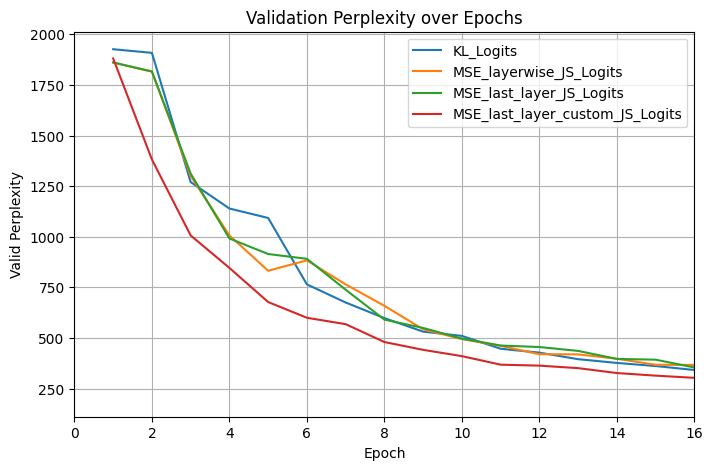

In [ ]:
# Figure 4. Comparison valid perplexity between the baseline and methods which use JS-Divergence
import matplotlib.pyplot as plt

valid_ppl_lists = [
    KL_Logits,
    MSE_layerwise_JS_Logits,
    MSE_last_layer_JS_Logits,
    MSE_last_layer_custom_JS_Logits
]

valid_ppl_name_lists = [
    "KL_Logits",
    "MSE_layerwise_JS_Logits",
    "MSE_last_layer_JS_Logits",
    "MSE_last_layer_custom_JS_Logits"
]
plt.figure(figsize=(8, 5))

for i, ppl_list in enumerate(valid_ppl_lists):
    num_epochs = len(ppl_list)
    x = list(range(1, num_epochs + 1))
    plt.plot(x, ppl_list, label=f'{valid_ppl_name_lists[i]}')


plt.xlabel('Epoch')
plt.ylabel('Valid Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.xlim(0,16)
plt.show()

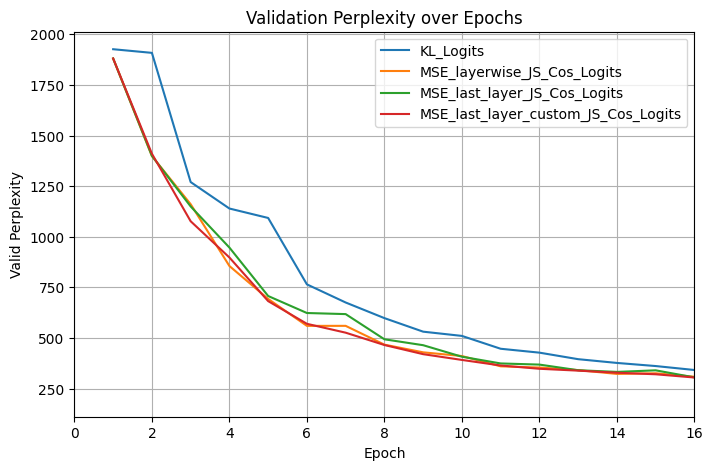

In [ ]:
# Figure 5. Comparison valid perplexity between the baseline and methods which use JS-Divergence and cosine similarity loss for logits
import matplotlib.pyplot as plt

valid_ppl_lists = [
    KL_Logits,
    MSE_layerwise_JS_Cos_Logits,
    MSE_last_layer_JS_Cos_Logits,
    MSE_last_layer_custom_JS_Cos_Logits
]

valid_ppl_name_lists = [
    "KL_Logits",
    "MSE_layerwise_JS_Cos_Logits",
    "MSE_last_layer_JS_Cos_Logits",
    "MSE_last_layer_custom_JS_Cos_Logits"
]
plt.figure(figsize=(8, 5))

for i, ppl_list in enumerate(valid_ppl_lists):
    num_epochs = len(ppl_list)
    x = list(range(1, num_epochs + 1))
    plt.plot(x, ppl_list, label=f'{valid_ppl_name_lists[i]}')


plt.xlabel('Epoch')
plt.ylabel('Valid Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.xlim(0,16)
plt.show()

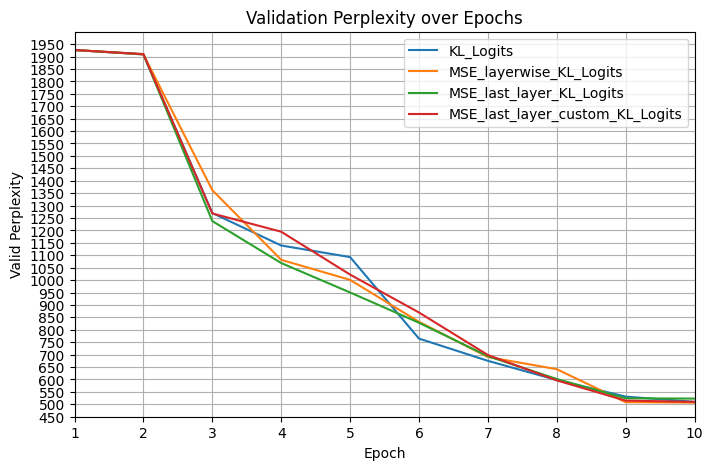

In [ ]:
# Figure 6. Comparison valid perplexity between the baseline and methods which use KL-Divergence
import matplotlib.pyplot as plt
import numpy as np

valid_ppl_lists = [
    KL_Logits,
    MSE_layerwise_KL_Logits,
    MSE_last_layer_KL_Logits,
    MSE_last_layer_custom_KL_Logits
]

valid_ppl_name_lists = [
    "KL_Logits",
    "MSE_layerwise_KL_Logits",
    "MSE_last_layer_KL_Logits",
    "MSE_last_layer_custom_KL_Logits"
]
plt.figure(figsize=(8, 5))

for i, ppl_list in enumerate(valid_ppl_lists):
    num_epochs = len(ppl_list)
    x = list(range(1, num_epochs + 1))
    plt.plot(x, ppl_list, label=f'{valid_ppl_name_lists[i]}')


plt.xlabel('Epoch')
plt.ylabel('Valid Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.xlim(1,10)
plt.ylim(450, 2000)
plt.yticks(range(450, 2000, 50))
plt.show()

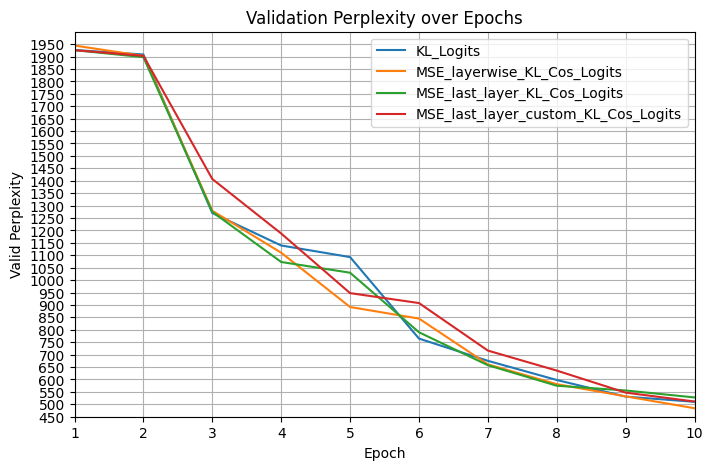

In [ ]:
# Figure 7. Comparison valid perplexity between the baseline and methods which use KL-Divergence
import matplotlib.pyplot as plt
import numpy as np

valid_ppl_lists = [
    KL_Logits,
    MSE_layerwise_KL_Cos_Logits,
    MSE_last_layer_KL_Cos_Logits,
    MSE_last_layer_custom_KL_Cos_Logits
]

valid_ppl_name_lists = [
    "KL_Logits",
    "MSE_layerwise_KL_Cos_Logits",
    "MSE_last_layer_KL_Cos_Logits",
    "MSE_last_layer_custom_KL_Cos_Logits"
]
plt.figure(figsize=(8, 5))

for i, ppl_list in enumerate(valid_ppl_lists):
    num_epochs = len(ppl_list)
    x = list(range(1, num_epochs + 1))  # epoch 1부터 시작
    plt.plot(x, ppl_list, label=f'{valid_ppl_name_lists[i]}')


plt.xlabel('Epoch')
plt.ylabel('Valid Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.xlim(1,10)
plt.ylim(450, 2000)
plt.yticks(range(450, 2000, 50))
plt.show()